# Setup section

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvidia-smi

Thu Nov  7 15:23:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Download repositories

!sudo rm -dr GPUcomputing
!git clone https://github.com/S3gmentati0nFault/GPUcomputing.git
!mkdir logs

rm: cannot remove 'GPUcomputing': No such file or directory
Cloning into 'GPUcomputing'...
remote: Enumerating objects: 766, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 766 (delta 239), reused 340 (delta 174), pack-reused 347 (from 1)
Receiving objects: 100% (766/766), 2.81 MiB | 10.14 MiB/s, done.
Resolving deltas: 100% (396/396), done.


In [ ]:
%cd GPUcomputing/utils/nvcc4jupyter-master/
!python3 -m build
%load_ext nvcc4jupyter
%cd /content/

/content/GPUcomputing/utils/nvcc4jupyter-master
/usr/bin/python3: No module named build
Source files will be saved in "./src".
/content


In [ ]:
# DeviceQuery dell'attuale device (su Colab!)

!nvcc -arch=sm_75 /content/GPUcomputing/utils/deviceQuery.cu -o deviceQuery
!./deviceQuery


CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla T4"
  CUDA Driver Version / Runtime Version          12.2 / 12.2
  GPU arch name:                                 Turing
  CUDA Capability Major/Minor version number:    7.5
  Total amount of global memory:                 15102 MBytes (15835660288 bytes)
  (40) Multiprocessors, ( 64) CUDA Cores/MP:     2560 CUDA Cores
  GPU Max Clock rate:                            1590 MHz (1.59 GHz)
  Memory Clock rate:                             5001 Mhz
  Memory Bus Width:                              256-bit
  L2 Cache Size:                                 4194304 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory                65536

In [ ]:
# Installation of the Valgrind utility

!sudo apt install valgrind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gdb libbabeltrace1 libc6-dbg libdebuginfod-common libdebuginfod1 libipt2
  libsource-highlight-common libsource-highlight4v5
Suggested packages:
  gdb-doc gdbserver valgrind-dbg valgrind-mpi kcachegrind alleyoop valkyrie
The following NEW packages will be installed:
  gdb libbabeltrace1 libc6-dbg libdebuginfod-common libdebuginfod1 libipt2
  libsource-highlight-common libsource-highlight4v5 valgrind
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 32.3 MB of archives.
After this operation, 111 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libdebuginfod-common all 0.186-1build1 [7,878 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libbabeltrace1 amd64 1.5.8-2build1 [160 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libdebuginfod1 amd6

# Configuration

In [ ]:
%%cuda_group_save --name "sharedMacros.h" --group "COMMON"

#ifndef SHARED_MACROS_H
#define SHARED_MACROS_H

#define DEBUGGING 0
#define SIZE 20000
#define MAX_WEIGHT 50000
#define BLOCK_SIZE 1024
#define PROBABILITY .0025
#define TESTING 1
#define TEST "/content/tests/east.txt"
#define TEST_SIZE 3
#define FIXED_SEED 51286
#define LOGPATH "/content/result_"
#define NO_VALUE -42
#define TIME_ARRAY_SIZE 20

#endif

In [ ]:
%%cuda_group_save --name "readGraph.h" --group "COMMON"

#ifndef READ_GRAPH_H
#define READ_GRAPH_H

#include <fstream>
#include <string>
#include <iostream>
#include <sstream>
#include <vector>

#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

struct Edge {
    int src, dest, weight;

    Edge() {
        this->src = 0;
        this->dest = 0;
        this->weight = 0;
    }

    Edge(int src, int dest, int weight) {
        this->src = src;
        this->dest = dest;
        this->weight = weight;
    }

    void print() {
        cout << this->src << " " << this->dest << " " << this->weight << endl;
    }
};



struct CPUGraph {
    int nodeSize, edgeSize;
    vector<Edge> edges;

    CPUGraph(int nodeSize, int edgeSize) {
        this->nodeSize = nodeSize;
        this->edgeSize = edgeSize;
        this->edges = vector<Edge>(edgeSize - 1);
    }

    void print() {
        cout << this->nodeSize << "   " << this->edgeSize << endl;
        for (int i = 0; i < this->edgeSize - 1; i++) {
            this->edges[i].print();
        }
    }
};

Graph *initializeGraph(string line, bool GPUenabled);
void readEdge(string line, vector<uint> *edges, vector<int> *weights, GraphStruct *str);
void readEdgeCPU(string line, vector<Edge> *edges, uint pos);
Graph *rgraph(string path, bool GPUenabled);
CPUGraph *rgraphCPU(string path);

#endif

In [ ]:
%%cuda_group_save --name "readGraph.cu" --group "COMMON"

#include <fstream>
#include <string>
#include <iostream>
#include <sstream>

#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"
#include "readGraph.h"

using namespace std;

Graph *initializeGraph(string line, bool GPUenabled) {
    stringstream ss(line);
    string element;
    uint nodeSize;
    uint edgeSize;

    ss >> element;
    nodeSize = stoi(element);
    ss >> element;
    edgeSize = stoi(element);

    Graph *graph = new Graph(nodeSize, edgeSize, GPUenabled);
    return graph;
}

void readEdge(string line, vector<uint> *edges, vector<int> *weights, GraphStruct *str) {
    stringstream ss(line);
    string element;
    node source, destination;
    int weight;

    ss >> element;
    source = stoi(element) - 1;
    ss >> element;
    destination = stoi(element) - 1;
    ss >> element;
    weight = stoi(element);

    str->cumDegs[source + 1]++;

    edges[source].push_back(destination);
    weights[source].push_back(weight);
}

void readEdgeCPU(string line, CPUGraph *graph, uint pos) {
    stringstream ss(line);
    string element;
    node source, destination;
    int weight;

    ss >> element;
    source = stoi(element) - 1;
    ss >> element;
    destination = stoi(element) - 1;
    ss >> element;
    weight = stoi(element);

    graph->edges[pos] = Edge(source, destination, weight);
}

Graph *rgraph(string path, bool GPUenabled) {
    ifstream inFile;
    string line;
    Graph *graph;

    inFile.open(path);

    if (!inFile) {
        cout << "Unable to open file";
        exit(1);
    }

    getline(inFile, line);
    graph = initializeGraph(line, GPUenabled);
    GraphStruct *str = graph->getStruct();
    uint nodeSize = str->nodeSize;
    uint edgeSize = str->edgeSize;
    printf("%d\t%d\n", nodeSize, edgeSize);
    vector<uint> *edges = new vector<uint>[edgeSize];
	  vector<int> *weights = new vector<int>[edgeSize];

    while (getline(inFile, line)) {
        readEdge(line, edges, weights, str);
    }

    for (node i = 0; i < nodeSize; ++i) {
        str->cumDegs[i + 1] += str->cumDegs[i];
    }

    for (node i = 0; i < nodeSize; ++i) {
        memcpy((str->neighs + str->cumDegs[i]), edges[i].data(), sizeof(uint) * edges[i].size());
		    memcpy((str->weights + str->cumDegs[i]), weights[i].data(), sizeof(int) * weights[i].size());
    }

    printf("Closing the file and freeing memory\n");

    inFile.close();
    delete[] edges;
    edges = NULL;
    delete[] weights;
    weights = NULL;

/*
    graph->print(true);
    print_d <<<1, 1>>> (str, 1);
    CHECK(cudaDeviceSynchronize());
*/
    return graph;
}

CPUGraph *rgraphCPU(string path) {
    ifstream inFile;
    string line;

    inFile.open(path);

    if (!inFile) {
        cout << "Unable to open file";
        exit(1);
    }

    getline(inFile, line);
    stringstream ss(line);
    string element;
    uint nodeSize;
    uint edgeSize;

    ss >> element;
    nodeSize = stoi(element);
    ss >> element;
    edgeSize = stoi(element);
    CPUGraph *graph = new CPUGraph(nodeSize, edgeSize);

    uint i = 0;
    while (getline(inFile, line)) {
        readEdgeCPU(line, graph, i);
        i++;
    }

    printf("Closing the file and freeing memory\n");

    inFile.close();

    return graph;
}

In [ ]:
!ls
!unzip tests.zip

deviceQuery  GPUcomputing  logs  result_cpu  result_gpuU  sample_data  src  tests.zip
Archive:  tests.zip
   creating: tests/
  inflating: tests/lakes.txt         
  inflating: tests/cal.txt           
  inflating: tests/bay.txt           
  inflating: tests/col.txt           
  inflating: tests/small.txt         
  inflating: tests/east.txt          
  inflating: tests/fla.txt           
  inflating: tests/ny.txt            


## GPU experimental approach

In [ ]:
%%cuda_group_save --name "mstGPUE.cu" --group "GPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>
#include <fstream>
#include <string>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"
#include "../COMMON/readGraph.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];
}

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getRoot (uint i, uint *d_flag, uint *d_colors) {
    return max(0, d_flag[d_colors[i]]);
}

uint getRoot (uint i, uint *flag, uint *colors) {
    return max(0, flag[colors[i]]);
}


__device__ uint binarySearch (uint *d_cumDegs, uint neighPosition, uint cumDegSize) {
    uint left = 0;
    uint right = cumDegSize - 1;

    if (d_cumDegs[right] <= neighPosition) {
        return right;
    }

    while (left <= right) {
        uint mid = (left + right) / 2;
        if (d_cumDegs[mid] <= neighPosition) {
            left = mid + 1;
        }
        else {
            right = mid - 1;
        }
    }

    if (left == right) {
        return left;
    }
    return left - 1;
}








/*****
* Kernel that finds the cheapest edge in the adjacency list of every node
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void findCheapest (GraphStruct *str, uint *d_candidates) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        int edgeWeight = d_getWeight(str, idx, i);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else if (edgeWeight == minimumWeight &&
                 d_getNeigh(str, idx, i) < d_getNeigh(str, idx, minimum)) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}







/*****
* Kernel that removes the mirrored edges from the graph. A mirrored edge is
* simply an edge pointing from the source to the destination and vice versa in
* an oriented graph, the removal logic is to cut the edge with the lowest source
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void mirroredEdgesRemoval (GraphStruct *str, uint *d_candidates, unsigned long long int *d_weight) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint destinationOffset = d_candidates[idx];
    node destination = d_getNeigh(str, idx, destinationOffset);
    if (idx < destination) {
        uint sourceOffset = d_candidates[destination];
        node destinationNeigh = d_getNeigh(str, destination, sourceOffset);

        // The vertex cannot be a candidate anymore because it would create a cycle
        if (destinationNeigh == idx) {
            d_candidates[idx] = UINT_MAX;
        }
    }

    if (d_candidates[idx] != UINT_MAX) {
        atomicAdd(d_weight, d_getWeight(str, idx, d_candidates[idx]));
    }
}







/*****
* Helper device function that recursively colors the nodes of the graph
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
* @param i - The index of the node to be colored
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__device__ uint *d_recursiveColorationHelper (GraphStruct *str, uint *d_candidates, node i, uint *d_colors) {
    uint color = UINT_MAX;
    if (d_candidates[i] == UINT_MAX) {
        color = i;
    }
    else {
        node neigh = d_getNeigh(str, i, d_candidates[i]);
        color = d_recursiveColorationHelper(str, d_candidates, neigh, d_colors)[neigh];
    }

    if (color != UINT_MAX) {
        d_colors[i] = color;
    }
    return d_colors;
}








/*****
* Kernel that recognizes the connected components in the graph and colors them
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__global__ void colorationProcess(GraphStruct *str, uint *d_candidates, uint *d_colors) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    d_recursiveColorationHelper(str, d_candidates, idx, d_colors);
}







__global__ void svIdentification (GraphStruct *str, uint *d_colors, uint *d_candidates, uint *d_flag) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    if (d_colors[idx] == idx) {
        d_flag[idx] = 1;
    }
}





//*** SCAN FUNCTIONS ***//

__global__ void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  // load input into shared memory
  temp[2 * thid] =  (2 * idx < n) ? g_idata[2 * idx] : 0;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? g_idata[2 * idx + 1] : 0;
  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("UPSWEEP\n");
  //}

  //printf("%d >> left: %d   right: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);

  for (int d =smemSize>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
    }
    offset *= 2;
  }

  //printf("%d >> right: %d   left: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  }

  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("DOWNSWEEP\n");
  //}

  for (int d = 1; d < smemSize; d *= 2) // traverse down tree & build scan
  {
      offset >>= 1;
    __syncthreads();

    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        //printf("%d >> ai: %d   bi: %d   temp[ai]: %d   temp[bi]: %d\n", thid, ai, bi, temp[ai], temp[bi]);
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
    //if (2 * idx == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid]);
    //}
    //if (2 * idx + 1 == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid + 1]);
    //}
  }

  //printf("%d >> right: %d   left: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);


  __syncthreads();
  if (idx <= (n / 2)) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}


void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}


__global__ void cfinal_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  //printf("%d: ls - %d  rs - %d  aux - %d\n", idx, g_odata[2 * idx], g_odata[2 * idx + 1], aux[blockIdx.x - 1]);

  uint sum = 0;
  for (uint i = 0; i < blockIdx.x; ++i) {
      sum += aux[i];
  }

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += sum;
      return;
  }

  g_odata[2 * idx] += sum;
  g_odata[2 * idx + 1] += sum;
}

//****************//







__global__ void cumulatedDegreeUpdateCopy(GraphStruct *str, uint *d_cumDegs, uint *d_colors, uint *d_flag) {
    // One thread per edge
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the thread is out of bounds returns immediately
    if (idx >= str->edgeSize) {
        return;
    }

    // The thread is the destination of the considered edge
    node destination = str->neighs[idx];
    uint destColor = d_colors[destination];

    // I look for the origin of the edge using the cumulated degrees array
    uint origin = binarySearch(str->cumDegs, idx, str->nodeSize + 1);
    uint originColor = d_colors[origin];

    // Find the roots => the super-vertices
    node oSuperVertex = d_getRoot(origin, d_flag, d_colors);

    //printf("%d(%d)   destination: %d(%d)   origin: %d(%d)\n", idx, destination, destColor, origin, originColor);

    // If the colors of the two vertices are different then they belong to different components
    if (destColor != originColor) {
        atomicAdd(&(d_cumDegs[oSuperVertex]), 1);
    }
}




__global__ void graphContractionCopy(GraphStruct *str, uint *d_colors, uint *d_flag,
                                 uint *d_cumDegs, node *d_newNeighs, uint *d_newWeights) {
    // One index per edge
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->edgeSize) {
        return;
    }

    // The index is the destination of the considered edge
    node destination = str->neighs[idx];
    uint destColor = d_colors[destination];

    // I look for the origin of the edge using the cumulated degrees array
    uint origin = binarySearch(str->cumDegs, idx, str->nodeSize + 1);
    uint originColor = d_colors[origin];

    // Find the roots => the super-vertices
    node oSuperVertex = d_getRoot(origin, d_flag, d_colors);
    node dSuperVertex = d_getRoot(destination, d_flag, d_colors);

    //printf("%d(%d)   destination: %d(%d)   origin: %d(%d)\n", idx, destination, destColor, origin, originColor);

    // If the colors of the two vertices are different then they belong to different components
    if (destColor != originColor) {
        // I take the weight
        int weight = str->weights[idx];

        // Compute the comulatedDegrees increment
        uint position = atomicAdd(&(d_cumDegs[oSuperVertex]), 1);

        // Update the vectors
        d_newNeighs[position] = dSuperVertex;
        d_newWeights[position] = weight;
    }
}


int main () {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = PROBABILITY;
    bool GPUEnabled = 1;
    Graph *graphPointer;

    if (TESTING) {
        string path(TEST);
        printf("Generating graph from file\n");
        graphPointer = rgraph(path, true);
    }
    else {
        graphPointer = new Graph(SIZE, GPUEnabled);
        graphPointer->randGraph(prob, true, maxWeight, eng);

        if (!graphPointer->isConnected()) {
            cout << "The graph is not connected" << endl;
            return -1;
        }
    }


    uint iterations = 0;


    // Configuration of the GPU kernel
    uint blockDim = BLOCK_SIZE;
    uint *candidates;


    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float spliTime = 0;
    float totalTime = 0;


    // Variables calculating the MST weight
    unsigned long long int mstWeight = 0;
    unsigned long long int *d_mstWeight;
    CHECK(cudaMalloc((void **)&d_mstWeight, sizeof(unsigned long long int)));
    CHECK(cudaMemcpy(d_mstWeight, &mstWeight, sizeof(unsigned long long int), cudaMemcpyHostToDevice));


    // Main block of the algorithm
    while (graphPointer->getStruct()->nodeSize > 1) {
        // Initialization of the variables associated with the graph
        GraphStruct *str = graphPointer->getStruct();
        uint size = str->nodeSize;
        uint edgeSize = str->edgeSize;
        cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";
        uint gridDim = (size + blockDim - 1) / blockDim;
        if (DEBUGGING && size < 15 && str->edgeSize < 100) {
            graphPointer->print(true);
            print_d<<<1, 1>>>(str, 1);
            CHECK(cudaDeviceSynchronize());
        }
        candidates = new uint[size];

        // First setp of the algorithm
        uint *d_candidates;
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));

        uint searchGrid = (edgeSize + blockDim - 1) / blockDim;
        cout << "Launching kernel FIND CHEAPEST -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        findCheapest<<<gridDim, blockDim>>>(str, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;




        // ~Debugging~ print the cheapest edge for every vertex
        if (DEBUGGING && size < 15) {
            cout << "The cheapest edge for every vertex" << endl;
            CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> " << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
            }
            cout << "\n\n\n";
        }
        /*******************/



        // Second step of the algorithm
        cout << "Launching kernel MIRRORED EDGES REMOVAL -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        mirroredEdgesRemoval<<<gridDim, blockDim>>>(str, d_candidates, d_mstWeight);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&mstWeight, d_mstWeight, sizeof(unsigned long long int), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        /********************/

        // ~Debugging~ print the cheapest edge for every vertex update
        if (DEBUGGING && size < 15) {
            cout << "Update of the cheapest edge for every vertex" << endl;
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> ";
                if (candidates[i] != UINT_MAX) {
                    cout << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
                }
                else {
                    cout << "NULL" << endl;
                }
            }
            printf ("%llu\n", mstWeight);
        }
        /*****************************/

        cout << "The MST weight at the end of iteration " << iterations + 1 << " is: " << mstWeight << endl;



        // Third step of the algorithm
        cout << "Launching kernel COLORATION PROCESS -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        // Initialize the color array
        uint *colors = new uint[size];
        uint *d_colors;
        CHECK(cudaMalloc((void**)&d_colors, size * sizeof(uint)));
        CHECK(cudaMemset(d_colors, UINT_MAX, size * sizeof(uint)));
        /**************************************************/

        cudaEventRecord(start);
        colorationProcess<<<gridDim, blockDim>>>(str, d_candidates, d_colors);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(colors, d_colors, size * sizeof(uint), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The coloration procedure took: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;

        // Print the coloring
        if (DEBUGGING) {
            uint *checkColoring = new uint[size];

            for (uint i = 0; i < size; i++) {
                checkColoring[i] = 0;
            }

            for (uint i = 0; i < size; i++) {
                checkColoring[colors[i]]++;
            }

            uint nonZeroColors = 0;
            for (uint i = 0; i < size; i++) {
                if (checkColoring[i] != 0) {
                    nonZeroColors++;
                }
            }

            cout << "There is a total of " << nonZeroColors << " colors" << endl;

            cout << "\n\n\n";
        }
        /*******************/

        /**
         * If the coloring coming out of the last kernel contains only one color
         * then it means that the edge added in the last step was the one needed
         * to merge the partial trees
         **/
        uint color = colors[0];
        bool uniqueColor = true;
        for (uint i = 1; i < size; i++) {
            if (colors[i] != color) {
                uniqueColor = false;
                break;
            }
        }
        if (uniqueColor) {
            cout << "THE CALCULATION OF THE MST IS COMPLETE\n";
            cout << "THE MST WEIGHT IS: " << mstWeight << endl;
            printf("Total elapsed time: %.5f seconds\n\n", totalTime);

            // Cuda event dealloc
            CHECK(cudaEventDestroy(start));
            CHECK(cudaEventDestroy(stop));

            // Cuda memory deallocation
            CHECK(cudaFree(d_candidates));
            CHECK(cudaFree(d_colors));
            CHECK(cudaFree(d_mstWeight));

            // Host memory deallocation
            delete[] candidates;
            delete[] colors;
            delete graphPointer;

            // Logging results
            string path(LOGPATH + string("gpuE"));

            ofstream logfile(path, ios_base::app);

            if (logfile.is_open()){
                cout << "Writing to file " << path << endl;
                logfile << mstWeight << "\n" << totalTime << "\n";
                logfile.close();
            }
            else {
                cout << "Unable to open file";
            }

            return 0;
        }
        /***********/





        // Fourth step of the algorithm
        cout << "Doing a round of scan on the flag vector, size: " << size << endl;
        uint *flag = new uint[size];
        uint *cFlag = new uint[size];
        uint *d_flag, *d_ogFlag;

        // setup di d_ogFlag
        CHECK(cudaMalloc((void**)&d_ogFlag, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_ogFlag, 0, (size) * sizeof(uint)));
        cudaEventRecord(start);
        svIdentification <<< gridDim, blockDim >>> (str, d_colors, d_candidates, d_ogFlag);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Building the flag array took:   %.5f seconds\n", spliTime);
        totalTime += spliTime;

        if (DEBUGGING) {
            CHECK(cudaMemcpy(cFlag, d_ogFlag, size * sizeof(uint), cudaMemcpyDeviceToHost));
        }

        // SMEM kernel configuration
        uint smemSize = 2 * blockDim;
        uint smem = smemSize * sizeof(uint);
        uint numSmemBlock = (size + smemSize - 1) / smemSize;

        // Setup the auxiliary array
        uint *aux, *d_aux;
        aux = new uint[numSmemBlock];
        CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock) * sizeof(uint)));
        CHECK(cudaMemset(d_aux, 0, (numSmemBlock) * sizeof(uint)));

        // Setup of the d_flag array
        CHECK(cudaMalloc((void**)&d_flag, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_flag, 0, (size) * sizeof(uint)));

        printf("prescan procedure on the flag array of size: %d ...\n", size);
        cudaEventRecord(start);
        prescan <<<  numSmemBlock, blockDim, smem >>> (d_flag, d_ogFlag, d_aux, size, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The first prescan procedure took:   %.5f seconds\n", spliTime);

        totalTime += spliTime;

        // Put everything together
        printf("final summation procedure...\n");
        cudaEventRecord(start);
        cfinal_sum <<< gridDim, blockDim >>> (d_flag, d_aux, size);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The final summation procedure took:   %.5f seconds\n\n", spliTime);

        totalTime += spliTime;

        CHECK(cudaMemcpy(flag, d_flag, size * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            cpuScan(cFlag, 0, size);

            for (uint i = 0; i < size - 1; i++) {
                if (cFlag[i] != flag[i]) {
                    cout << "I due array sono diversi in posizione " << i << "   " << cFlag[i] << "   " << flag[i] << endl;
                    return -1;
                }
            }

            delete[] cFlag;
        }
        cout << "The contracted graph will contain " << flag[size - 1] << " supervertices\n\n" << endl;
        // Spring Cleaning
        delete[] (aux);
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_ogFlag));




        // Fifth step of the algorithm

        // Allocating resources for the new cumulated degrees array
        uint newNodeSize = flag[size - 1];
        uint cumDegSize = newNodeSize + 1;
        uint *cumDegs = new uint[cumDegSize];
        uint *d_cumDegs;
        CHECK(cudaMalloc((void**)&d_cumDegs, (cumDegSize) * sizeof(uint)));
        CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));
        /***********************************/

        cout << "Launching kernel CUMULATED DEGREE UPDATE -- (" << blockDim << ", 1, 1) -- (" << searchGrid << ", 1, 1)" << endl;

        cudaEventRecord(start);
        cumulatedDegreeUpdateCopy<<<searchGrid, blockDim>>>(str, d_cumDegs, d_colors, d_flag);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing the computation of the cumulated degrees took: %.5f seconds\n\n", spliTime);
        CHECK(cudaMemcpy(cumDegs, d_cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyDeviceToHost));







        // Perform another prefix sum on the cumDegrees array
        aux = new uint[numSmemBlock];
        CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock) * sizeof(uint)));
        CHECK(cudaMemset(d_aux, 0, (numSmemBlock) * sizeof(uint)));

        uint *cCumDegs;

        if (DEBUGGING) {
            cCumDegs = new uint[cumDegSize];
            for (uint i = 0; i < cumDegSize; i++) {
                cCumDegs[i] = cumDegs[i];
            }
        }

        // Setup d_ogCumDegs
        uint *d_ogCumDegs;
        CHECK(cudaMalloc((void **) &d_ogCumDegs, cumDegSize * sizeof(uint)));
        CHECK(cudaMemcpy(d_ogCumDegs, cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyHostToDevice));

        printf("prescan procedure on the cumDegs array of size: %d ...\n", size);
        cudaEventRecord(start);
        prescan <<<  numSmemBlock, blockDim, smem >>> (d_cumDegs, d_ogCumDegs, d_aux, cumDegSize, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The first prescan procedure took:   %.5f seconds\n", spliTime);

        totalTime += spliTime;

        // Put everything together
        printf("final summation procedure...\n");
        cudaEventRecord(start);
        cfinal_sum <<< gridDim, blockDim >>> (d_cumDegs, d_aux, cumDegSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The final summation procedure took:   %.5f seconds\n\n", spliTime);

        totalTime += spliTime;

        CHECK(cudaMemcpy(cumDegs, d_cumDegs, cumDegSize * sizeof(uint), cudaMemcpyDeviceToHost));
        if (DEBUGGING) {
            cpuScan(cCumDegs, 0, cumDegSize);

            for (uint i = 0; i < cumDegSize - 1; i++) {
                if (cCumDegs[i] != cumDegs[i]) {
                    cout << "I due array sono diversi in posizione " << i << endl;
                    cout << cCumDegs[i] << "   " << cumDegs[i];
                    return -1;
                }
            }
        }
        cout << "The contracted graph will contain " << cumDegs[cumDegSize - 1] << " edges" << endl;
        cout << "The old graph structure contained " << str->edgeSize << " edges\n\n" << endl;

        // Spring cleaning
        free(aux);
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_ogCumDegs));




        // Allocating space for the arrays in the newly contracted graph
        uint newEdgeSize = cumDegs[cumDegSize - 1];
        node *newNeighs = new node[newEdgeSize];
        uint *newWeights = new uint[newEdgeSize];

        uint *d_newNeighs, *d_newWeights;
        CHECK(cudaMalloc((void **)&d_newNeighs, newEdgeSize * sizeof(node)));
        CHECK(cudaMalloc((void **)&d_newWeights, newEdgeSize * sizeof(uint)));
        CHECK(cudaMemset(d_newNeighs, 0, newEdgeSize * sizeof(node)));
        CHECK(cudaMemset(d_newWeights, 0, newEdgeSize * sizeof(uint)));

        cout << "Launching kernel GRAPH CONSTRUCTION -- (" << blockDim << ", 1, 1) -- (" << searchGrid << ", 1, 1)" << endl;
        cudaEventRecord(start);
        graphContractionCopy<<<searchGrid, blockDim>>>(str, d_colors, d_flag, d_cumDegs, d_newNeighs, d_newWeights);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        printf("The construction of the new neighbour and weight arrays took: %.5f seconds\n\n", milliseconds/1000);
        spliTime += milliseconds / 1000.0;
        CHECK(cudaMemcpy(newNeighs, d_newNeighs, newEdgeSize * sizeof(node), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(newWeights, d_newWeights, newEdgeSize * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            node *checkNewNeighs = new node[newEdgeSize];
            uint *checkNewWeights = new uint[newEdgeSize];
            // Copy the contents of cumDegs into a new array
            for (uint i = 0; i < cumDegSize; i++) {
                cCumDegs[i] = cumDegs[i];
            }

            cudaEventRecord(start);
            for (uint i = 0; i < size; i++) {
                uint color = colors[i];
                node superVertex = getRoot(i, flag, colors);

                for (uint j = 0; j < str->deg(i); j++) {
                    node neigh = str->getNeigh(i, j);
                    uint neighColor = colors[neigh];

                    if (color != neighColor) {
                        int weight = str->getWeight(i, j);
                        uint position = cCumDegs[superVertex];
                        checkNewNeighs[position] = getRoot(neigh, flag, colors);
                        checkNewWeights[position] = weight;
                        cCumDegs[superVertex]++;
                    }
                }
            }

            //for (uint i = 0; i < newEdgeSize; i++) {
                //if (newNeighs[i] != checkNewNeighs[i] || newWeights[i] != checkNewWeights[i]) {
                    //cout << "I due array sono diversi in posizione " << i << endl;
                    //return -1;
                //}
            //}

            delete[] cCumDegs;
        }

        // Reconstructing the graph
        graphPointer->copyConstructor(newNodeSize, newEdgeSize, newNeighs, newWeights, cumDegs);

        //graphPointer->print(true);

        printf("----------------------------------\n\n");
        /***********************************************/




        // Updating the iteration information
        totalTime += spliTime;
        iterations++;
        /*****************************************/


        // Cuda memory deallocation
        CHECK(cudaFree(d_candidates));
        CHECK(cudaFree(d_colors));
        CHECK(cudaFree(d_flag));
        CHECK(cudaFree(d_cumDegs));
        CHECK(cudaFree(d_newNeighs));
        CHECK(cudaFree(d_newWeights));
        /****************************/

        // Host memory deallocation
        delete[] candidates;
        delete[] colors;
        delete[] flag;
        delete[] cumDegs;
        delete[] newNeighs;
        delete[] newWeights;
        /******************/
    }

    return 0;
}

In [ ]:
# Compilazione ed esecuzione
# GPU-e
!nvcc -arch=sm_75 GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/COMMON/readGraph.cu src/GPU/mstGPUE.cu -o mstGPUE
!./mstGPUE

ptxas warning : Stack size for entry function '_Z17colorationProcessP11GraphStructPjS1_' cannot be statically determined
Generating graph from file
3598623	8778114
Closing the file and freeing memory
Processing a graph of size: 3598623 with 8778114 edges.

Launching kernel FIND CHEAPEST -- (1024, 1, 1) -- (3515, 1, 1)
Finding the cheapest edge for every vertex took: 0.03318 seconds

Launching kernel MIRRORED EDGES REMOVAL -- (1024, 1, 1) -- (3515, 1, 1)
Removing the mirrored edges required: 0.00392 seconds

The MST weight at the end of iteration 1 is: 3600949096
Launching kernel COLORATION PROCESS -- (1024, 1, 1) -- (3515, 1, 1)
The coloration procedure took: 0.00854 seconds

Doing a round of scan on the flag vector, size: 3598623
Building the flag array took:   0.00854 seconds
prescan procedure on the flag array of size: 3598623 ...
The first prescan procedure took:   0.00080 seconds
final summation procedure...
The final summation procedure took:   0.00447 seconds

The contracted gra

In [ ]:
!nvprof ./mstGPUE > nvprof_gpuE.txt

==47614== NVPROF is profiling process 47614, command: ./mstGPUE
==47614== Profiling application: ./mstGPUE
==47614== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   51.93%  59.429ms        11  5.4026ms  150.21us  33.172ms  findCheapest(GraphStruct*, unsigned int*)
                   19.19%  21.961ms        83  264.59us  1.5680us  2.9845ms  [CUDA memcpy DtoH]
                    5.93%  6.7910ms        11  617.36us  4.6400us  4.7082ms  colorationProcess(GraphStruct*, unsigned int*, unsigned int*)
                    5.72%  6.5421ms        10  654.21us  99.199us  3.2898ms  graphContractionCopy(GraphStruct*, unsigned int*, unsigned int*, unsigned int*, unsigned int*, unsigned int*)
                    4.82%  5.5206ms        11  501.87us  4.1590us  3.8447ms  mirroredEdgesRemoval(GraphStruct*, unsigned int*, __int64*)
                    4.82%  5.5121ms        20  275.61us  2.3040us  4.4437ms  cfinal_sum(unsigned int*, un

In [ ]:
!ncu ./mstGPUE > ncu_gpuE.txt

## Work efficient scan

In [ ]:
%%cuda_group_save --name "scanTesting.cu" --group "TESTING"

// Header file di C++
#include <iostream>

// Header file C
#include <time.h>
#include <cstdlib>
#include <ctime>

// Custom files
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

__global__ void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  temp[2*thid] = g_idata[2*idx]; // load input into shared memory
  temp[2*thid+1] = g_idata[2*idx+1];

  for (int d = n>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset*(2*thid+1)-1;
      int bi = offset*(2*thid+2)-1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
    }
    offset *= 2;
  }

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  } // clear the last element

  for (int d = 1; d < n; d *= 2) // traverse down tree & build scan
  {
    __syncthreads();
    if (thid < d && offset > 0)
    {
      int ai = offset*(2*thid+1)-1;
      int bi = offset*(2*thid+2)-1;
      if (bi < smemSize && ai < smemSize) {
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
    offset >>= 1;
  }


  __syncthreads();
  if (idx <= (n / 2) - 1) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}

void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}


__global__ void final_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  //printf("%d: ls - %d  rs - %d  aux - %d\n", idx, g_odata[2 * idx], g_odata[2 * idx + 1], aux[blockIdx.x - 1]);

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += aux[blockIdx.x];
      return;
  }
  g_odata[2 * idx] += aux[blockIdx.x];
  g_odata[2 * idx + 1] += aux[blockIdx.x];
}


/*
 * MAIN: test on parallel reduction
 */
int main(void) {
  uint *cpuArray, *gpuArray, *d_gpuArray, *gpuOutput, *d_gpuOutput, *aux, *d_aux;
  uint blockSize = 128;
  uint smemSize = 2 * blockSize;
  uint n = 1500;

  uint numSmemBlock = n / smemSize;
  uint numBlock = (n + blockSize - 1) / blockSize;
  uint gpuScanSize = numSmemBlock * smemSize;
  uint residualSize = n - gpuScanSize;

  // Memory allocation for the Host side
  cpuArray = (uint *) malloc(n * sizeof(uint));
  gpuArray = (uint *) malloc(n * sizeof(uint));
  gpuOutput = (uint *) malloc(n * sizeof(uint));
  aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));

  // Memory allocation for the Device side
  CHECK(cudaMalloc((void **) &d_gpuArray, gpuScanSize * sizeof(uint)));
  CHECK(cudaMalloc((void **) &d_gpuOutput, n * sizeof(uint)));
  CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));

  printf("\n****  test on parallel scan  ****\n");
	printf("  Vector length: %d\n", n);

  cudaEvent_t start, stop;
	cudaEventCreate(&start);
	cudaEventCreate(&stop);

  // Generate the original array
  srand(0);
	for (uint i = 0; i < n; i++){
     cpuArray[i] = 1;
     gpuArray[i] = cpuArray[i];
  }

	printf("\n  CPU procedure...\n");
	double go = seconds();
  for (uint i = 1; i < n; i++) {
      cpuArray[i] += cpuArray[i - 1];
  }
	double CPUtime = seconds() - go;
	printf("    Elapsed time: %f (sec) \n", CPUtime);

  // Copy the contents of gpuArray in the Device memory
  CHECK(cudaMemcpy(d_gpuArray, gpuArray, gpuScanSize * sizeof(uint), cudaMemcpyHostToDevice));
  CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));

  printf("\n  block scan...\n");

  uint smem = smemSize * sizeof(uint);
  printf("\n  first prescan procedure on the Device: %d elements...\n", gpuScanSize);
  cudaEventRecord(start);
  prescan<<<  numSmemBlock, blockSize, smem >>>(d_gpuOutput, d_gpuArray, d_aux, n, smemSize);
  printf("\n  second scan procedure on the Host: %d elements...\n", residualSize);
  cpuScan(gpuArray, gpuScanSize, n);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
  float milliseconds;
	cudaEventElapsedTime(&milliseconds, start, stop);
	double GPUtime = milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

  // Copy the contents of the aux array into Host memory and perform another scan
  printf("\n  third scan procedure on the Host: %d elements...\n", numSmemBlock);
  CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
  cudaEventRecord(start);
  cpuScan(aux, 0, numSmemBlock + 1);
  CHECK(cudaEventRecord(stop));
  CHECK(cudaEventSynchronize(stop));
  CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUtime += milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

  if (DEBUGGING) {
      for (uint i = 0; i < numSmemBlock; i++) {
          printf("Block(%d): %d\n", i, aux[i]);
      }
  }

  // Copy the portions of the array computed on the Host to Device memory
  CHECK(cudaMemcpy(d_aux, aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyHostToDevice));
  CHECK(cudaMemcpy(&(d_gpuOutput[gpuScanSize]), &(gpuArray[gpuScanSize]), residualSize * sizeof(uint), cudaMemcpyHostToDevice));

  printf("\n  final summation procedure...\n");
  cudaEventRecord(start);
  final_sum<<< numBlock, blockSize >>>(d_gpuOutput, d_aux, n);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUtime += milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);

 	printf("\nTotal elapsed time:   %.5f (sec)\n", GPUtime);

	double speedup = CPUtime/GPUtime;
	printf("    Speedup %.1f\n", speedup);

  CHECK(cudaMemcpy(gpuOutput, d_gpuOutput, n * sizeof(uint), cudaMemcpyDeviceToHost));

  if (DEBUGGING && n < 200) {
      for (uint i = 0; i < n; i++) {
          cout << gpuOutput[i] << endl;
      }
  }

  for (uint i = 0; i < n - 1; i++) {
      if (gpuOutput[i + 1] != cpuArray[i]) {
          printf("%d: %d\t%d\n", i - 1, gpuOutput[i - 1], cpuArray[i - 1]);
          printf("%d: %d\t%d\n", i, gpuOutput[i], cpuArray[i]);
          printf("%d: %d\t%d\n", i + 1, gpuOutput[i + 1], cpuArray[i + 1]);
          return -1;
      }
  }

  printf("%d - %d\n", gpuOutput[n - 1], cpuArray[n - 2]);
  printf("È andato tutto bene\n");

  // Host memory deallocation
  free(cpuArray);
  free(gpuArray);
  free(gpuOutput);
  free(aux);

  // Device memory deallocation
  CHECK(cudaFree(d_gpuArray));
  CHECK(cudaFree(d_gpuOutput));
  CHECK(cudaFree(d_aux));

	return 0;
}

In [ ]:
!nvcc -arch=sm_75 src/TESTING/scanTesting.cu -o scanTesting
!./scanTesting


****  test on parallel scan  ****
  Vector length: 1500

  CPU procedure...
    Elapsed time: 0.000006 (sec) 

  block scan...

  first prescan procedure on the Device: 1280 elements...

  second scan procedure on the Host: 220 elements...
   elapsed time:   0.00024 (sec)

  third scan procedure on the Host: 5 elements...
   elapsed time:   0.00000 (sec)
Block(0): 0
Block(1): 256
Block(2): 512
Block(3): 768
Block(4): 1024

  final summation procedure...
   elapsed time:   0.00003 (sec)


Total elapsed time:   0.00028 (sec)
    Speedup 0.0
1499 - 1499
È andato tutto bene


## Work efficient scan that can work with any array size

In [ ]:
%%cuda_group_save --name "scanTestingUpgrade.cu" --group "TESTING"

// Header file di C++
#include <iostream>

// Header file C
#include <time.h>
#include <cstdlib>
#include <ctime>
#include <math.h>

// Custom files
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

__global__ void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  // load input into shared memory
  temp[2 * thid] =  (2 * idx < n) ? g_idata[2 * idx] : 0;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? g_idata[2 * idx + 1] : 0;
  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("UPSWEEP\n");
  //}

  //printf("%d >> left: %d   right: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);

  for (int d =smemSize>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
    }
    offset *= 2;
  }

  //printf("%d >> right: %d   left: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  }

  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("DOWNSWEEP\n");
  //}

  for (int d = 1; d < smemSize; d *= 2) // traverse down tree & build scan
  {
      offset >>= 1;
    __syncthreads();

    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        //printf("%d >> ai: %d   bi: %d   temp[ai]: %d   temp[bi]: %d\n", thid, ai, bi, temp[ai], temp[bi]);
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
    //if (2 * idx == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid]);
    //}
    //if (2 * idx + 1 == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid + 1]);
    //}
  }

  //printf("%d >> right: %d   left: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);


  __syncthreads();
  if (idx <= (n / 2)) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}

void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}


__global__ void final_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  //printf("%d: ls - %d  rs - %d  aux - %d\n", idx, g_odata[2 * idx], g_odata[2 * idx + 1], aux[blockIdx.x - 1]);

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += aux[blockIdx.x];
      return;
  }
  g_odata[2 * idx] += aux[blockIdx.x];
  g_odata[2 * idx + 1] += aux[blockIdx.x];
}


/*
 * MAIN: test on parallel reduction
 */
int main(void) {
  uint *cpuArray, *gpuArray, *gpuArrayNew, *d_gpuArrayNew, *d_gpuArray, *gpuOutput, *d_gpuOutput, *aux, *d_aux;
  uint blockSize = 1024;
  uint smemSize = 2 * blockSize;
  uint n = 500001;

  uint numSmemBlock = n / smemSize;
  uint numBlock = (n + blockSize - 1) / blockSize;
  uint gpuScanSize = numSmemBlock * smemSize;
  uint residualSize = n - gpuScanSize;

  // Memory allocation for the Host side
  gpuArrayNew = (uint *) malloc(n * sizeof(uint));
  cpuArray = (uint *) malloc(n * sizeof(uint));
  gpuArray = (uint *) malloc(n * sizeof(uint));
  gpuOutput = (uint *) malloc(n * sizeof(uint));
  aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));

  // Memory allocation for the Device side
  CHECK(cudaMalloc((void **) &d_gpuArray, gpuScanSize * sizeof(uint)));
  CHECK(cudaMalloc((void **) &d_gpuOutput, n * sizeof(uint)));
  CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));

  printf("\n****  test on parallel scan  ****\n");
	printf("  Vector length: %d\n", n);

  cudaEvent_t start, stop;
	cudaEventCreate(&start);
	cudaEventCreate(&stop);

  // Generate the original array
  srand(0);
	for (uint i = 0; i < n; i++){
     cpuArray[i] = rand() % 100;
     //cpuArray[i] = 1;
     gpuArray[i] = cpuArray[i];
     gpuArrayNew[i] = cpuArray[i];
  }

	printf("\n  CPU procedure...\n");
	double go = seconds();
  for (uint i = 1; i < n; i++) {
      cpuArray[i] += cpuArray[i - 1];
  }
	double CPUtime = seconds() - go;
	printf("    Elapsed time: %f (sec) \n", CPUtime);

  // Copy the contents of gpuArray in the Device memory
  CHECK(cudaMemcpy(d_gpuArray, gpuArray, gpuScanSize * sizeof(uint), cudaMemcpyHostToDevice));
  CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));

  printf("\n  block scan...\n");

  uint smem = smemSize * sizeof(uint);
  printf("\n  first prescan procedure on the Device: %d elements...\n", gpuScanSize);
  cudaEventRecord(start);
  prescan<<<  numSmemBlock, blockSize, smem >>>(d_gpuOutput, d_gpuArray, d_aux, n, smemSize);
  printf("\n  second scan procedure on the Host: %d elements...\n", residualSize);
  cpuScan(gpuArray, gpuScanSize, n);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
  float milliseconds;
	cudaEventElapsedTime(&milliseconds, start, stop);
	double GPUtime = milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

  // Copy the contents of the aux array into Host memory and perform another scan
  printf("\n  third scan procedure on the Host: %d elements...\n", numSmemBlock);
  CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
  cudaEventRecord(start);
  cpuScan(aux, 0, numSmemBlock + 1);
  CHECK(cudaEventRecord(stop));
  CHECK(cudaEventSynchronize(stop));
  CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUtime += milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

  if (DEBUGGING && numSmemBlock < 15) {
      for (uint i = 0; i < numSmemBlock; i++) {
          printf("Block(%d): %d\n", i, aux[i]);
      }
  }

  // Copy the portions of the array computed on the Host to Device memory
  CHECK(cudaMemcpy(d_aux, aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyHostToDevice));
  CHECK(cudaMemcpy(&(d_gpuOutput[gpuScanSize]), &(gpuArray[gpuScanSize]), residualSize * sizeof(uint), cudaMemcpyHostToDevice));

  printf("\n  final summation procedure...\n");
  cudaEventRecord(start);
  final_sum<<< numBlock, blockSize >>>(d_gpuOutput, d_aux, n);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUtime += milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);

 	printf("\nTotal elapsed time:   %.5f (sec)\n", GPUtime);

  CHECK(cudaMemcpy(gpuOutput, d_gpuOutput, n * sizeof(uint), cudaMemcpyDeviceToHost));

  /*
  if (DEBUGGING && n < 200) {
      for (uint i = 0; i < n; i++) {
          cout << gpuOutput[i] << endl;
      }
  }
  */

  for (uint i = 0; i < n - 1; i++) {
      if (gpuOutput[i + 1] != cpuArray[i]) {
          printf("%d: %d\t%d\n", i - 1, gpuOutput[i - 1], cpuArray[i - 1]);
          printf("%d: %d\t%d\n", i, gpuOutput[i], cpuArray[i]);
          printf("%d: %d\t%d\n", i + 1, gpuOutput[i + 1], cpuArray[i + 1]);
          return -1;
      }
  }

  printf("%d - %d\n", gpuOutput[n - 1], cpuArray[n - 2]);
  printf("È andato tutto bene\n");

  CHECK(cudaFree(d_aux));
  free(aux);




  printf("TEST DEL NUOVO KERNEL");

  double GPUTimeNew = 0;

  // Copy the contents of gpuArray in the Device memory
  numSmemBlock = (n + smemSize - 1) / smemSize;
  aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));
  CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
  CHECK(cudaMalloc((void **) &d_gpuArrayNew, n * sizeof(uint)));
  CHECK(cudaMemcpy(d_gpuArrayNew, gpuArrayNew, n * sizeof(uint), cudaMemcpyHostToDevice));
  CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));
  CHECK(cudaMemset(d_gpuOutput, 0, n * sizeof(uint)));

  printf("\n  block scan...\n");

  smem = smemSize * sizeof(uint);
  printf("\n  prescan procedure on: %d elements...\n", n);
  cudaEventRecord(start);
  prescan<<<  numSmemBlock, blockSize, smem >>>(d_gpuOutput, d_gpuArrayNew, d_aux, n, smemSize);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUTimeNew = milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

  /*
  for (uint i = 0; i < numSmemBlock + 1; ++i) {
      printf("%d\n", aux[i]);
  }
  */

  printf("\n  another prescan procedure on: %d elements...\n", numSmemBlock + 1);
  uint *d_aaux;
  CHECK(cudaMalloc((void **) &d_aaux, sizeof(uint)));
  cudaEventRecord(start);
  prescan<<<  1, blockSize, smem >>>(d_aux, d_aux, d_aaux, numSmemBlock + 1, smemSize);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUTimeNew = milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);


  CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
  if (DEBUGGING) {
      for (uint i = 0; i < numSmemBlock + 1; i++) {
          printf("Block(%d): %d\n", i, aux[i]);
      }
  }

  printf("\n  final summation procedure...\n");
  cudaEventRecord(start);
  final_sum<<< numBlock, blockSize >>>(d_gpuOutput, d_aux, n);
  CHECK(cudaDeviceSynchronize());
	CHECK(cudaEventRecord(stop));
	CHECK(cudaEventSynchronize(stop));
	CHECK(cudaGetLastError());
	cudaEventElapsedTime(&milliseconds, start, stop);
	GPUTimeNew += milliseconds / 1000.0;
	printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);

  CHECK(cudaMemcpy(gpuOutput, d_gpuOutput, n * sizeof(uint), cudaMemcpyDeviceToHost));

  /*
  for (uint i = 0; i < n; ++i) {
      printf("%d\n", gpuOutput[i]);
  }
  */

 	printf("\nTotal elapsed time:   %.5f (sec)\n", GPUTimeNew);

  for (uint i = 0; i < n - 1; i++) {
      if (gpuOutput[i + 1] != cpuArray[i]) {
          printf("%d: %d\t%d\n", i - 1, gpuOutput[i - 1], cpuArray[i - 1]);
          printf("%d: %d\t%d\n", i, gpuOutput[i], cpuArray[i]);
          printf("%d: %d\t%d\n", i + 1, gpuOutput[i + 1], cpuArray[i + 1]);
          return -1;
      }
  }

  printf("%d - %d\n", gpuOutput[n - 1], cpuArray[n - 2]);
  printf("È andato tutto bene\n");

  printf("Speedup with respect to the CPU: %.5f\nSpeedup with respect to the old GPU impl: %.5f", CPUtime / GPUTimeNew, GPUtime / GPUTimeNew);

  // Host memory deallocation
  free(cpuArray);
  free(gpuArray);
  free(gpuOutput);
  free(aux);

  // Device memory deallocation
  CHECK(cudaFree(d_gpuArray));
  CHECK(cudaFree(d_gpuOutput));
  CHECK(cudaFree(d_aux));

	return 0;
}

In [ ]:
!nvcc -arch=sm_75 src/TESTING/scanTestingUpgrade.cu -o scanTestingUpgrade
!./scanTestingUpgrade


****  test on parallel scan  ****
  Vector length: 500001

  CPU procedure...
    Elapsed time: 0.001797 (sec) 

  block scan...

  first prescan procedure on the Device: 499712 elements...

  second scan procedure on the Host: 289 elements...
   elapsed time:   0.00025 (sec)

  third scan procedure on the Host: 244 elements...
   elapsed time:   0.00000 (sec)

  final summation procedure...
   elapsed time:   0.00006 (sec)


Total elapsed time:   0.00032 (sec)
24745984 - 24745984
È andato tutto bene
TEST DEL NUOVO KERNEL
  block scan...

  prescan procedure on: 500001 elements...
   elapsed time:   0.00013 (sec)

  another prescan procedure on: 246 elements...
   elapsed time:   0.00003 (sec)
Block(0): 0
Block(1): 102716
Block(2): 204244
Block(3): 307416
Block(4): 409245
Block(5): 509061
Block(6): 610259
Block(7): 711011
Block(8): 813989
Block(9): 916448
Block(10): 1018009
Block(11): 1119958
Block(12): 1219613
Block(13): 1322218
Block(14): 1423626
Block(15): 1522298
Block(16): 162329

## Dynamic parallelism

In [ ]:
%%cuda_group_save --name "dynaParallelism.cu" --group "TESTING"

#include <stdio.h>

__global__ void exclamationPoint () {
    printf("!\n");
    return;
}

__global__ void world () {
    printf("world");
    exclamationPoint <<< 1, 1 >>> ();
    return;
}

__global__ void hello () {
    printf("Hello ");
    world <<< 1, 1 >>> ();
    return;
}

int main() {
    uint blockDim = 32;
    uint size = 101;
    uint *array = new uint[size];
    uint *d_array, *d_aux, *d_auxOffset;
    hello <<< 1, 1 >>> ();
    cudaDeviceSynchronize();
    return 0;
}

In [ ]:
!nvcc -arch=sm_75 -rdc=true -lcudadevrt src/TESTING/dynaParallelism.cu -o dynaParallelism
!./dynaParallelism

Hello world!


## Texture based fetches

In [ ]:
%%cuda_group_save --name "mfTexture.cu" --group "TESTING"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];
}

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getPosition(GraphStruct *str, node i, uint offset) {
    return str->cumDegs[i] + offset;
}


__global__ void findCheapest (GraphStruct *str, uint *d_candidates) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        int edgeWeight = d_getWeight(str, idx, i);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else if (edgeWeight == minimumWeight &&
                 d_getNeigh(str, idx, i) < d_getNeigh(str, idx, minimum)) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}

__global__ void findCheapestTexture (GraphStruct *str, uint *d_candidates, cudaTextureObject_t wtex, cudaTextureObject_t ntex) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        uint pos = d_getPosition(str, idx, i);
        int edgeWeight = tex1Dfetch<int>(wtex, pos);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else {
            uint neigh = tex1Dfetch<int>(ntex, pos);
            pos = d_getPosition(str, idx, minimum);
            uint miNeigh = (minimum == UINT_MAX) ?  UINT_MAX : tex1Dfetch<int>(ntex, pos);

            if (edgeWeight == minimumWeight && neigh < miNeigh) {
                minimumWeight = edgeWeight;
                minimum = i;
            }
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}

int main() {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = PROBABILITY;
    bool GPUEnabled = 1;
    Graph *graphPointer;
    Graph graph(SIZE, GPUEnabled);
    graphPointer = &graph;
  	graphPointer->randGraph(prob, true, maxWeight, eng);
    /**************************************************/


    // Checking if the random graph is connected
    if (!graphPointer->isConnected()) {
        cout << "The graph is not connected" << endl;
        return -1;
    }
    /************/

    // Initialization of the variables associated with the graph
    GraphStruct *str = graphPointer->getStruct();
    uint size = str->nodeSize;
    uint edgeSize = str->edgeSize;
    cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";
    uint *candidates = new uint[size];
    uint *CPUCandidates = new uint[size];

    // First setp of the algorithm
    uint *d_candidates;
    CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
    CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));

    uint blockDim = BLOCK_SIZE;
    uint gridDim = (size + blockDim - 1) / blockDim;

    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float cpuTime, gpuTime, gpuETime;

    // create texture object
    cudaResourceDesc weightsDesc;
    memset(&weightsDesc, 0, sizeof(weightsDesc));
    weightsDesc.resType = cudaResourceTypeLinear;
    weightsDesc.res.linear.devPtr = str->weights;
    weightsDesc.res.linear.desc.f = cudaChannelFormatKindSigned;
    weightsDesc.res.linear.desc.x = 32; // bits per channel
    weightsDesc.res.linear.sizeInBytes = edgeSize * sizeof(uint);

    cudaResourceDesc neighDesc;
    memset(&neighDesc, 0, sizeof(neighDesc));
    neighDesc.resType = cudaResourceTypeLinear;
    neighDesc.res.linear.devPtr = str->weights;
    neighDesc.res.linear.desc.f = cudaChannelFormatKindUnsigned;
    neighDesc.res.linear.desc.x = 32; // bits per channel
    neighDesc.res.linear.sizeInBytes = edgeSize * sizeof(uint);

    cudaTextureDesc weightsTexDesc, neighTexDesc;
    memset(&weightsTexDesc, 0, sizeof(weightsTexDesc));
    memset(&neighTexDesc, 0, sizeof(neighTexDesc));
    weightsTexDesc.readMode = cudaReadModeElementType;
    neighTexDesc.readMode = cudaReadModeElementType;

    // create texture object: we only have to do this once!
    cudaTextureObject_t weightsTex, neighsTex;
    cudaCreateTextureObject(&weightsTex, &weightsDesc, &weightsTexDesc, NULL);
    cudaCreateTextureObject(&neighsTex, &neighDesc, &neighTexDesc, NULL);

    printf("CPU procedure...\n");
	  double go = seconds();
    for (uint i = 0; i < size; i++) {
        int min = INT_MAX;
        uint minOffset = 0;
        for (uint j = 0; j < str->deg(i); j++) {
            if (str->getWeight(i, j) < min) {
                min = str->getWeight(i, j);
                minOffset = j;
            }
        }
        CPUCandidates[i] = minOffset;
    }
    cpuTime = seconds() - go;
    printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", cpuTime);

    cudaEventRecord(start);
    findCheapest <<<gridDim, blockDim>>> (str, d_candidates);
    cudaEventRecord(stop);
    CHECK(cudaDeviceSynchronize());
    CHECK(cudaEventSynchronize(stop));
    CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));
    cudaEventElapsedTime(&milliseconds, start, stop);
    gpuTime = milliseconds / 1000.0;
    printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", gpuTime);

    for (uint i = 0; i < size; i++) {
        if (CPUCandidates[i] != candidates[i]) {
            printf("The two vectors are different at position %d\n", i);
            return -1;
        }
    }

    printf("The speedup is %.3f\n", cpuTime/gpuTime);

    cudaEventRecord(start);
    findCheapestTexture <<<gridDim, blockDim>>> (str, d_candidates, weightsTex, neighsTex);
    cudaEventRecord(stop);
    CHECK(cudaDeviceSynchronize());
    CHECK(cudaEventSynchronize(stop));
    CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));
    cudaEventElapsedTime(&milliseconds, start, stop);
    gpuETime = milliseconds / 1000.0;
    printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", gpuETime);

    for (uint i = 0; i < size; i++) {
        if (CPUCandidates[i] != candidates[i]) {
            printf("The two vectors are different at position %d\n", i);
            printf("%d - %d\n", CPUCandidates[i], candidates[i]);
            return -1;
        }
    }

    printf("The speedup is with respect to the CPU is %.3f\n", cpuTime/gpuETime);
    printf("The speedup is with respect to the GPU is %.3f\n", gpuTime/gpuETime);

    // destroy texture object
    //cudaDestroyTextureObject(tex);
}

In [ ]:
!nvcc -arch=sm_75 -rdc=true -lcudadevrt GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/TESTING/mfTexture.cu -o mfTexture
!./mfTexture

Processing a graph of size: 50000 with 25004636 edges.

CPU procedure...
Finding the cheapest edge for every vertex took: 0.15420 seconds

Finding the cheapest edge for every vertex took: 0.03561 seconds

The speedup is 4.330
Finding the cheapest edge for every vertex took: 0.02305 seconds

The speedup is with respect to the CPU is 6.691
The speedup is with respect to the GPU is 1.545


## Segmented scan based fetch

In [ ]:
%%cuda_group_save --name "newFetch.cu" --group "TESTING"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];
}

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getPosition(GraphStruct *str, node i, uint offset) {
    return str->cumDegs[i] + offset;
}


__global__ void findMinimumForVertex(GraphStruct *str, uint *d_aux, uint *d_auxOffset, int smemSize, node vertex)
{
  printf("%d\n", vertex);
  extern __shared__ int temp[];
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;
  int n = d_deg(str, vertex);

  // Zero relative to the start of the array
  int relativeZero = str->cumDegs[vertex];

  // load input into shared memory
  temp[2 * thid] = (2 * idx < n) ? (int) (2 * idx) : NO_VALUE;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? (int) (2 * idx + 1) : NO_VALUE;


  // build sum in place up the tree
  for (int d = smemSize>>1; d > 0; d >>= 1)
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
          int aiWeight = (temp[ai] != NO_VALUE) ? str->weights[relativeZero + temp[ai]] : INT_MAX;
          int biWeight = (temp[bi] != NO_VALUE) ? str->weights[relativeZero + temp[bi]] : INT_MAX;
          temp[bi] = (aiWeight < biWeight) ? temp[ai] : temp[bi];
      }
    }
    offset *= 2;
  }

  printf("%d\n", vertex);
  if (vertex == 0) {
      if (idx == 0) {
          printf("%d\n", n);
      }
      printf("temp[2 * %d]: %d    temp[2 * %d + 1]: %d\n", thid, temp[2 * thid], thid, temp[2 * thid + 1]);
  }

  if (thid == 0)
  {
    d_aux[blockIdx.x + d_auxOffset[vertex]] = temp[smemSize - 1];
  }
}

__global__ void findMinimum(GraphStruct *str, uint *d_aux, uint *d_auxOffset, uint *d_candidates) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= str->nodeSize) {
        return;
    }

    int min = INT_MAX;
    for (uint i = 0; i < (d_deg(str, idx) + (2 * blockDim.x) - 1) / (2 * blockDim.x); i++) {
        //printf("%d\n", d_aux[d_auxOffset[idx] + i]);
        int weight = d_getWeight(str, idx, d_aux[d_auxOffset[idx] + i]);
        if (weight < min) {
            min = weight;
            d_candidates[idx] = d_aux[d_auxOffset[idx] + i];
        }
    }
}

__global__ void findCheapestTexture (GraphStruct *str, uint *d_candidates, cudaTextureObject_t wtex, cudaTextureObject_t ntex) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        uint pos = d_getPosition(str, idx, i);
        int edgeWeight = tex1Dfetch<int>(wtex, pos);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else {
            uint neigh = tex1Dfetch<int>(ntex, pos);
            pos = d_getPosition(str, idx, minimum);
            uint miNeigh = (minimum == UINT_MAX) ?  UINT_MAX : tex1Dfetch<int>(ntex, pos);

            if (edgeWeight == minimumWeight && neigh < miNeigh) {
                minimumWeight = edgeWeight;
                minimum = i;
            }
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}

int main() {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = PROBABILITY;
    bool GPUEnabled = 1;
    Graph *graphPointer;
    Graph graph(SIZE, GPUEnabled);
    graphPointer = &graph;
  	graphPointer->randGraph(prob, true, maxWeight, eng);
    /**************************************************/


    // Checking if the random graph is connected
    if (!graphPointer->isConnected()) {
        cout << "The graph is not connected" << endl;
        return -1;
    }
    /************/

    // Initialization of the variables associated with the graph
    GraphStruct *str = graphPointer->getStruct();
    uint size = str->nodeSize;
    uint edgeSize = str->edgeSize;
    cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";
    uint *candidates = new uint[size];
    uint *CPUCandidates = new uint[size];

    // First setp of the algorithm
    uint *d_candidates;
    CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
    CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));

    uint blockDim = BLOCK_SIZE;
    uint gridDim = (size + blockDim - 1) / blockDim;

    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float cpuTime, gpuTime, gpuETime;

    // create texture object
    cudaResourceDesc weightsDesc;
    memset(&weightsDesc, 0, sizeof(weightsDesc));
    weightsDesc.resType = cudaResourceTypeLinear;
    weightsDesc.res.linear.devPtr = str->weights;
    weightsDesc.res.linear.desc.f = cudaChannelFormatKindSigned;
    weightsDesc.res.linear.desc.x = 32; // bits per channel
    weightsDesc.res.linear.sizeInBytes = edgeSize * sizeof(uint);

    cudaResourceDesc neighDesc;
    memset(&neighDesc, 0, sizeof(neighDesc));
    neighDesc.resType = cudaResourceTypeLinear;
    neighDesc.res.linear.devPtr = str->weights;
    neighDesc.res.linear.desc.f = cudaChannelFormatKindUnsigned;
    neighDesc.res.linear.desc.x = 32; // bits per channel
    neighDesc.res.linear.sizeInBytes = edgeSize * sizeof(uint);

    cudaTextureDesc weightsTexDesc, neighTexDesc;
    memset(&weightsTexDesc, 0, sizeof(weightsTexDesc));
    memset(&neighTexDesc, 0, sizeof(neighTexDesc));
    weightsTexDesc.readMode = cudaReadModeElementType;
    neighTexDesc.readMode = cudaReadModeElementType;

    // create texture object: we only have to do this once!
    cudaTextureObject_t weightsTex, neighsTex;
    cudaCreateTextureObject(&weightsTex, &weightsDesc, &weightsTexDesc, NULL);
    cudaCreateTextureObject(&neighsTex, &neighDesc, &neighTexDesc, NULL);

    printf("CPU procedure...\n");
	  double go = seconds();
    for (uint i = 0; i < size; i++) {
        int min = INT_MAX;
        uint minOffset = 0;
        for (uint j = 0; j < str->deg(i); j++) {
            if (str->getWeight(i, j) < min) {
                min = str->getWeight(i, j);
                minOffset = j;
            }
        }
        CPUCandidates[i] = minOffset;
    }
    cpuTime = seconds() - go;
    printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", cpuTime);

        // Compute the ratio between the outdegree and the smem size
        uint smemSize = 2 * blockDim;
        uint auxSize = 0;

        // Compute the ratio between the outdegree and the smem size

        printf("smemSize: %d   blockDim: %d   size: %d   edgeSize: %d\n", smemSize, blockDim, size, edgeSize);

        // Compute the size of the auxiliary array
        for (uint i = 0; i < size; i++) {
            uint outdegree = str->deg(i);
            auxSize += (outdegree + smemSize - 1) / smemSize;
        }
        printf("auxSize: %d\n", auxSize);


        // Allocating resources for the support arrays
        uint *aux, *auxOffset, *d_auxOffset, *d_aux;
        candidates = new uint[size];
        aux = (uint *) malloc(auxSize * sizeof(uint));
        auxOffset = (uint *) malloc(size * sizeof(uint));
        CHECK(cudaMalloc((void **) &d_aux, auxSize * sizeof(uint)));
        CHECK(cudaMemset(d_aux, INT_MAX, auxSize * sizeof(uint)));

        // Copy the contents of auxOffset to device memory
        CHECK(cudaMalloc((void **) &d_auxOffset, size * sizeof(uint)));
        for (node i = 0; i < size; i++) {
            auxOffset[i] = (i == 0) ? 0 : auxOffset[i - 1] + (str->deg(i - 1) + smemSize - 1) / smemSize;
        }
        CHECK(cudaMemcpy(d_auxOffset, auxOffset, size * sizeof(uint), cudaMemcpyHostToDevice));

        cudaEventRecord(start);
        for (node i = 0; i < size; i++) {
            uint gridSize = (str->deg(i) + smemSize - 1) / smemSize;
            int smem = smemSize * sizeof(uint);

            printf("%d > str->cumDegs[i]: %d   auxOffset[i]: %d   str->deg(i): %d   gridSize: %d\n", i, str->cumDegs[i], auxOffset[i], str->deg(i), gridSize);

            if (str->deg(i) >= blockDim) {
                findMinimumForVertex <<< gridSize, blockDim, smem >>> (str, d_aux, d_auxOffset, smemSize, i);
            }
        }
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        gpuETime = milliseconds / 1000.0;
        printf("Doing a preliminary minimum search took: %.5f seconds\n\n", milliseconds / 1000.0);

        CHECK(cudaMemcpy(aux, d_aux, auxSize * sizeof(uint), cudaMemcpyDeviceToHost));

        uint nanValues = 0;
        for (uint i = 0; i < auxSize; i++) {
            //printf("aux[%d]: %d\n", i, aux[i]);
            if (aux[i] == UINT_MAX) {
                nanValues++;
            }
        }
        printf("There are %d NaN values out of %d\n", nanValues, auxSize);
return 0;
        // For every vertex pick the lightest edge
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));
        cudaEventRecord(start);
        findMinimum <<< gridDim, blockDim >>> (str, d_aux, d_auxOffset, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        gpuETime += milliseconds / 1000.0;
        printf("Picking the minimum for every vertex: %.5f seconds\n\n", milliseconds / 1000.0);

        CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));

        printf("Using parallel scan took %.5f seconds\n\n", gpuETime);

    for (uint i = 0; i < size; i++) {
        if (str->getWeight(i, CPUCandidates[i]) < str->getWeight(i, candidates[i])) {
            printf("The two vectors are different at position %d\n", i);
            printf("%d - %d\n", CPUCandidates[i], candidates[i]);
            return -1;
        }
    }

    cudaEventRecord(start);
    findCheapestTexture <<<gridDim, blockDim>>> (str, d_candidates, weightsTex, neighsTex);
    cudaEventRecord(stop);
    CHECK(cudaDeviceSynchronize());
    CHECK(cudaEventSynchronize(stop));
    CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));
    cudaEventElapsedTime(&milliseconds, start, stop);
    gpuTime = milliseconds / 1000.0;
    printf("Using the textures to find the cheapest edge took: %.5f seconds\n\n", gpuTime);

    for (uint i = 0; i < size; i++) {
        if (CPUCandidates[i] != candidates[i]) {
            printf("The two vectors are different at position %d\n", i);
            printf("%d - %d\n", CPUCandidates[i], candidates[i]);
            return -1;
        }
    }

    printf("The speedup is with respect to the CPU is %.3f\n", cpuTime/gpuETime);
    printf("The speedup is with respect to the GPU is %.3f\n", gpuTime/gpuETime);

    // destroy texture object
    //cudaDestroyTextureObject(tex);
}

In [ ]:
!nvcc -arch=sm_75 -rdc=true -lcudadevrt GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/TESTING/newFetch.cu -o newFetch
!./newFetch

## Read graph from file

In [ ]:
%%cuda_group_save --name "readGraph.cu" --group "TESTING"

#include <fstream>
#include <string>
#include <iostream>
#include <sstream>

#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

Graph *initializeGraph(string line) {
    stringstream ss(line);
    string element;
    uint nodeSize;
    uint edgeSize;

    ss >> element;
    nodeSize = stoi(element);
    ss >> element;
    edgeSize = stoi(element);

    Graph *graph = new Graph(nodeSize, edgeSize, 1);
    return graph;
}

void readEdge(string line, vector<uint> *edges, vector<int> *weights, GraphStruct *str) {
    stringstream ss(line);
    string element;
    node source, destination;
    int weight;

    ss >> element;
    source = stoi(element) - 1;
    ss >> element;
    destination = stoi(element) - 1;
    ss >> element;
    weight = stoi(element);

    str->cumDegs[source + 1]++;

    edges[source].push_back(destination);
    weights[source].push_back(weight);
}

int main() {
    ifstream inFile;
    string path = "/content/small.txt";
    string line;
    Graph *graph;

    inFile.open(path);

    if (!inFile) {
        cout << "Unable to open file";
        exit(1);
    }

    getline(inFile, line);
    graph = initializeGraph(line);
    GraphStruct *str = graph->getStruct();
    uint nodeSize = str->nodeSize;
    uint edgeSize = str->edgeSize;
    printf("%d\t%d\n", nodeSize, edgeSize);
    vector<uint> *edges = new vector<uint>[edgeSize];
	  vector<int> *weights = new vector<int>[edgeSize];

    while (getline(inFile, line)) {
        readEdge(line, edges, weights, str);
    }

    for (node i = 0; i < nodeSize; ++i) {
        str->cumDegs[i + 1] += str->cumDegs[i];
        str->outdegrees[i] = str->cumDegs[i + 1] - str->cumDegs[i];
    }

    for (node i = 0; i < nodeSize; ++i) {
        memcpy((str->neighs + str->cumDegs[i]), edges[i].data(), sizeof(uint) * edges[i].size());
		    memcpy((str->weights + str->cumDegs[i]), weights[i].data(), sizeof(int) * weights[i].size());
    }

    graph->print(true);
    print_d <<<1, 1>>> (str, 1);

    inFile.close();

    delete graph;
    graph = NULL;
    delete[] edges;
    edges = NULL;
    delete[] weights;
    weights = NULL;

    return graph;
}

In [ ]:
!nvcc -arch=sm_75 -rdc=true -lcudadevrt GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/TESTING/readGraph.cu -o readGraph
!./readGraph

src/TESTING/readGraph.cu(61): warning #177-D: variable "i" was declared but never referenced
      uint i = 0;
           ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

11	12
** Graph (num node: 11, num edges: 12)
         (min deg: 0, max deg: 0, mean deg: 0, connected: 1)
   node(0)[1]-> 1(803) 
   node(1)[1]-> 0(803) 
   node(2)[1]-> 3(158) 
   node(3)[1]-> 2(158) 
   node(4)[1]-> 5(774) 
   node(5)[1]-> 4(774) 
   node(6)[1]-> 7(1531) 
   node(7)[1]-> 6(1531) 
   node(8)[2]-> 9(1673) 10(1400) 
   node(9)[1]-> 8(1673) 
   node(10)[0]-> 

** Graph (num node: 11, num edges: 12)
  node(0)[1]-> 1(803) 
  node(1)[1]-> 0(803) 
  node(2)[1]-> 3(158) 
  node(3)[1]-> 2(158) 
  node(4)[1]-> 5(774) 
  node(5)[1]-> 4(774) 
  node(6)[1]-> 7(1531) 
  node(7)[1]-> 6(1531) 
  node(8)[2]-> 9(1673) 10(1400) 
  node(9)[1]-> 8(1673) 
  node(10)[0]-> 



## Other tests

In [ ]:
%%cuda_group_save --name "mst.h" --group "GPU"
#ifndef MST_H
#define MST_H

cudaResourceDesc generateCudaDescriptor(GraphStruct *str, uint field, uint size, size_t type, cudaChannelFormatKind chDesc) {
    cudaResourceDesc descriptor;
    memset(&descriptor, 0, sizeof(descriptor));
    descriptor.resType = cudaResourceTypeLinear;
    if (field == 0) {
        descriptor.res.linear.devPtr = str->weights;
    }
    else if (field == 1) {
        descriptor.res.linear.devPtr = str->outdegrees;
    }
    else if (field == 2) {
        descriptor.res.linear.devPtr = str->cumDegs;
    }
    else {
        descriptor.res.linear.devPtr = str->neighs;
    }
    descriptor.res.linear.desc.f = chDesc;
    descriptor.res.linear.desc.x = 32; // bits per channel
    descriptor.res.linear.sizeInBytes = size * type;

    return descriptor;
}

cudaTextureDesc generateTextureDescriptor() {
    cudaTextureDesc texDesc;
    memset(&texDesc, 0, sizeof(texDesc));
    texDesc.readMode = cudaReadModeElementType;

    return texDesc;
}

__device__
node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

#endif

In [ ]:
%%cuda_group_save --name "mst.cu" --group "GPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>

// Header file C
#include <time.h>
#include <limits.h>
#include <stdio.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"
#include "../COMMON/readGraph.h"
#include "mst.h"

using namespace std;

cudaTextureObject_t wtex, otex, ntex, cdtex;

void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}

uint getRoot (uint i, uint *svIds, uint *colors) {
    return max(0, svIds[colors[i]]);
}



__device__
uint d_getRoot (uint i, uint *d_svIds, uint *d_colors) {
    return max(0, d_svIds[d_colors[i]]);
}




__global__
void findCheapest(GraphStruct *str, cudaTextureObject_t ntex, cudaTextureObject_t otex, cudaTextureObject_t wtex, cudaTextureObject_t cdtex, uint *d_candidates) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;


    // Check the boundary condition
    if (idx >= str->nodeSize) {
        return;
    }

    uint medge = 0;
    int wmin = INT_MAX;
    uint nmin = 0;

    uint edge = tex1Dfetch<uint>(cdtex, idx);
    uint loopEnd = edge + tex1Dfetch<uint>(otex, idx);
    while (edge < loopEnd) {
        int weight = tex1Dfetch<int>(wtex, edge);
        uint neigh = tex1Dfetch<uint>(ntex, edge);


        if (weight < wmin) {
            wmin = weight;
            medge = edge;
            nmin = neigh;
        }
        else if (weight == wmin && neigh < nmin) {
            wmin = weight;
            medge = edge;
            nmin = neigh;
        }

        ++edge;
    }

    d_candidates[idx] = medge;
}

__global__
void findCheapestUnified(GraphStruct *str, uint *d_candidates) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;


    // Check the boundary condition
    if (idx >= str->nodeSize) {
        return;
    }

    uint medge = 0;
    int wmin = INT_MAX;
    uint nmin = 0;

    uint edge = str->cumDegs[idx];
    uint loopEnd = edge + str->outdegrees[idx];
    while (edge < loopEnd) {
        int weight = str->weights[edge];
        node neigh = str->neighs[edge];

        if (weight < wmin) {
            wmin = weight;
            medge = edge;
            nmin = neigh;
        }
        else if (weight == wmin && neigh < nmin) {
            wmin = weight;
            medge = edge;
            nmin = neigh;
        }

        ++edge;
    }

    d_candidates[idx] = medge;
}






__global__
void removeMirroredEdges(GraphStruct *str, cudaTextureObject_t ntex, uint *d_candidates) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx > str->nodeSize) {
        return;
    }

    uint edge = d_candidates[idx];
    node neigh = tex1Dfetch<node>(ntex, edge);
    uint nedge = d_candidates[neigh];
    node nneigh = tex1Dfetch<node>(ntex, nedge);

    if (nneigh == idx && neigh > idx) {
        d_candidates[idx] = UINT_MAX;
    }
}

__global__
void removeMirroredEdgesUnified (GraphStruct *str, uint *d_candidates, unsigned long long int *d_weight) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint dedge = d_candidates[idx];
    node destination = str->neighs[dedge];
    if (idx < destination) {
        uint sedge = d_candidates[destination] == UINT_MAX;
        if (sedge == UINT_MAX) {
            return;
        }
        node destinationNeigh = str->neighs[sedge];

        // The vertex cannot be a candidate anymore because it would create a cycle
        if (destinationNeigh == idx) {
            d_candidates[idx] = UINT_MAX;
        }
    }

    uint cedge = d_candidates[idx];
    if (d_candidates[idx] != UINT_MAX) {
        atomicAdd(d_weight, str->weights[cedge]);
    }
}






__device__
uint *d_recursiveColorationHelper (GraphStruct *str, uint *d_candidates, node i, uint *d_colors) {
    uint color = UINT_MAX;
    uint edge = d_candidates[i];
    if (edge == UINT_MAX) {
        color = i;
    }
    else {
        node neigh = str->neighs[edge];
        color = d_recursiveColorationHelper(str, d_candidates, neigh, d_colors)[neigh];
    }


    if (color != UINT_MAX) {
        d_colors[i] = color;
    }
    return d_colors;
}

__global__
void colorationProcess (GraphStruct *str, uint *d_candidates, uint *d_colors) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    d_recursiveColorationHelper(str, d_candidates, idx, d_colors);
}








__global__
void svIdentification (GraphStruct *str, uint *d_colors, uint *d_candidates, uint *d_isSupervertex) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    if (d_colors[idx] == idx && str->outdegrees[idx] > 0) {
        d_isSupervertex[idx] = 1;
    }
}





__global__
void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  // load input into shared memory
  temp[2 * thid] =  (2 * idx < n) ? g_idata[2 * idx] : 0;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? g_idata[2 * idx + 1] : 0;
  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("UPSWEEP\n");
  //}

  //printf("%d >> left: %d   right: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);

  for (int d =smemSize>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
    }
    offset *= 2;
  }

  //printf("%d >> right: %d   left: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  }

  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("DOWNSWEEP\n");
  //}

  for (int d = 1; d < smemSize; d *= 2) // traverse down tree & build scan
  {
      offset >>= 1;
    __syncthreads();

    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        //printf("%d >> ai: %d   bi: %d   temp[ai]: %d   temp[bi]: %d\n", thid, ai, bi, temp[ai], temp[bi]);
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
    //if (2 * idx == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid]);
    //}
    //if (2 * idx + 1 == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid + 1]);
    //}
  }

  //printf("%d >> right: %d   left: %d\n", thid, temp[2 * thid], temp[2 * thid + 1]);


  __syncthreads();
  if (idx <= (n / 2)) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}



__global__
void final_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  //printf("%d: ls - %d  rs - %d  aux - %d\n", idx, g_odata[2 * idx], g_odata[2 * idx + 1], aux[blockIdx.x - 1]);

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += aux[blockIdx.x];
      return;
  }
  g_odata[2 * idx] += aux[blockIdx.x];
  g_odata[2 * idx + 1] += aux[blockIdx.x];
}




__global__
void countNewEdges(GraphStruct *str, cudaTextureObject_t ntex, cudaTextureObject_t otex, cudaTextureObject_t cdtex, uint *d_colors, uint *d_svIds, uint *newOutdegrees) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint edge = tex1Dfetch<uint>(cdtex, idx);
    uint loopEnd = edge + tex1Dfetch<uint>(otex, idx);
    uint newEdges = 0;
    uint color = d_colors[idx];
    while (edge < loopEnd) {
        node neigh = tex1Dfetch<node>(ntex, edge);

        if (d_colors[neigh] != color) {
            ++newEdges;
        }
        ++edge;
    }

    node sv = d_getRoot(idx, d_svIds, d_colors);
    atomicAdd(&newOutdegrees[sv], newEdges);
}

__global__
void countNewEdgesUnified(GraphStruct *str, uint *d_colors, uint *d_svIds, uint *newOutdegrees) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint edge = str->cumDegs[idx];
    uint loopEnd = edge + str->outdegrees[idx];
    uint newEdges = 0;
    uint color = d_colors[idx];
    while (edge < loopEnd) {
        node neigh = str->neighs[edge];

        if (d_colors[neigh] != color) {
            ++newEdges;
        }
        ++edge;
    }

    node sv = d_getRoot(idx, d_svIds, d_colors);
    atomicAdd(&newOutdegrees[sv], newEdges);
}




__global__
void graphContraction(GraphStruct *str, cudaTextureObject_t ntex, cudaTextureObject_t otex, cudaTextureObject_t cdtex, cudaTextureObject_t wtex,
                      uint *newNeighs, uint *newWeights, uint *d_colors, uint *d_newCumDegs, uint *d_svIds) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint edge = tex1Dfetch<uint>(cdtex, idx);
    uint loopEnd = edge + tex1Dfetch<uint>(otex, idx);
    uint color = d_colors[idx];

    while (edge < loopEnd) {
        node neigh = tex1Dfetch<node>(ntex, edge);

        if (d_colors[neigh] != color) {
            node osv = d_getRoot(idx, d_svIds, d_colors);
            node dsv = d_getRoot(neigh, d_svIds, d_colors);
            uint position = atomicAdd(&(d_newCumDegs[osv]), 1);
            newNeighs[position] = dsv;
            newWeights[position] = tex1Dfetch<int>(wtex, edge);
        }
        ++edge;
    }
}

__global__
void graphContractionUnified(GraphStruct *str, uint *newNeighs, uint *newWeights, uint *d_colors, uint *d_newCumDegs, uint *d_svIds) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint edge = str->cumDegs[idx];
    uint loopEnd = edge + str->outdegrees[idx];
    uint color = d_colors[idx];

    while (edge < loopEnd) {
        node neigh = str->neighs[edge];

        if (d_colors[neigh] != color) {
            node osv = d_getRoot(idx, d_svIds, d_colors);
            node dsv = d_getRoot(neigh, d_svIds, d_colors);
            uint position = atomicAdd(&(d_newCumDegs[osv]), 1);
            newNeighs[position] = dsv;
            newWeights[position] = str->weights[edge];
        }
        ++edge;
    }
}


int main() {
    // Generation of a random graph
    Graph *graph;

    if (TESTING) {
        string path("/content/ny.txt");
        printf("Generating graph from file\n");
        graph = rgraph(path, true);
    }
    else {
        std::random_device rd;
        std::default_random_engine eng(FIXED_SEED);
        uint maxWeight = MAX_WEIGHT;
        float prob = PROBABILITY;
        bool GPUEnabled = 1;
        graph = new Graph(SIZE, GPUEnabled);
        graph->randGraph(prob, true, maxWeight, eng);

        if (!graph->isConnected()) {
            cout << "The graph is not connected" << endl;
            return -1;
        }
    }


    uint iterations = 1;


    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    uint tArraySize = TIME_ARRAY_SIZE;
    float milliseconds;
    float *timings = new float[tArraySize];
    float *timingsUnified = new float[tArraySize];
    for (uint i = 0; i < tArraySize; ++i) {
        timings[i] = 0.0;
        timingsUnified[i] = 0.0;
    }


    // Variables calculating the MST weight
    unsigned long long int mstWeight = 0;
    unsigned long long int *d_mstWeight;
    CHECK(cudaMalloc((void**)&d_mstWeight, sizeof(unsigned long long int)));
    CHECK(cudaMemset(d_mstWeight, 0, sizeof(unsigned long long int)));

    // Initializing the variables associated with the graph
    GraphStruct *str = graph->getStruct();
    uint nodeSize = str->nodeSize;
    uint edgeSize = str->edgeSize;
    printf("Processing a graph containing %d nodes and %d edges\n\n", nodeSize, edgeSize);

    do {
        // Initializing the variables associated with the kernel structure
        uint blockDim = BLOCK_SIZE;
        uint gridDim = (nodeSize + blockDim - 1) / blockDim;

        // Initialize some of the variables for the first phase.
        uint *candidates, *d_candidates, *offsetCandidates, *d_offsetCandidates;
        candidates = new uint[nodeSize];
        offsetCandidates = new uint[nodeSize];
        CHECK(cudaMalloc((void**)&d_candidates, nodeSize * sizeof(uint)));
        CHECK(cudaMalloc((void**)&d_offsetCandidates, nodeSize * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, nodeSize * sizeof(uint)));
        CHECK(cudaMemset(d_offsetCandidates, 0, nodeSize * sizeof(uint)));

        // Generating resource descriptors
        cudaResourceDesc weightDesc = generateCudaDescriptor(str, 0, edgeSize, sizeof(int), cudaChannelFormatKindSigned);
        cudaResourceDesc outdegreeDesc = generateCudaDescriptor(str, 1, nodeSize, sizeof(uint), cudaChannelFormatKindUnsigned);
        cudaResourceDesc cdDesc = generateCudaDescriptor(str, 2, nodeSize + 1, sizeof(uint), cudaChannelFormatKindUnsigned);
        cudaResourceDesc neighDesc = generateCudaDescriptor(str, 3, edgeSize, sizeof(node), cudaChannelFormatKindUnsigned);

        // Generating the texture objects
        cudaTextureDesc wtexDesc = generateTextureDescriptor();
        cudaTextureDesc otexDesc = generateTextureDescriptor();
        cudaTextureDesc ntexDesc = generateTextureDescriptor();
        cudaTextureDesc cdtexDesc = generateTextureDescriptor();

        // Create the texture objects
        cudaTextureObject_t wtex, otex, ntex, cdtex;
        CHECK(cudaCreateTextureObject(&wtex, &weightDesc, &wtexDesc, NULL));
        CHECK(cudaCreateTextureObject(&otex, &outdegreeDesc, &otexDesc, NULL));
        CHECK(cudaCreateTextureObject(&ntex, &neighDesc, &ntexDesc, NULL));
        CHECK(cudaCreateTextureObject(&cdtex, &cdDesc, &cdtexDesc, NULL));





        printf("Launching a kernel FIND CHEAPEST using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        findCheapest <<< gridDim, blockDim >>> (str, ntex, otex, wtex, cdtex, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaGetLastError();
        cudaEventElapsedTime(&milliseconds, start, stop);
        timings[0] = milliseconds / 1000.0;
        printf("Finding the cheapest edge for every vertex took:   %.5f seconds\n\n", timings[0]);

        timings[tArraySize - 1] += timings[0];
        timings[1] += timings[0];

        printf("Launching the unfied version of the kernel using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        findCheapestUnified <<< gridDim, blockDim >>> (str, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaGetLastError();
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("Finding the cheapest edge using unified memory took for unified version: %.5f seconds\n", timingsUnified[0]);
        printf("SPEEDUP:   %.5f\n", timings[0] / timingsUnified[0]);

        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timingsUnified[1] += timingsUnified[0];

        CHECK(cudaMemcpy(candidates, d_candidates, nodeSize * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            for (node i = 0; i < nodeSize; ++i) {
                node nmin = 0;
                int wmin = INT_MAX;
                uint medge = 0;
                uint edge = str->cumDegs[i];
                uint loopEnd = edge + str->outdegrees[i];

                while (edge < loopEnd) {
                    node neigh = str->neighs[edge];
                    int weight = str->weights[edge];

                    if (weight < wmin) {
                        wmin = weight;
                        medge = edge;
                        nmin = neigh;
                    }
                    else if (weight == wmin && neigh < nmin) {
                        wmin = weight;
                        medge = edge;
                        nmin = neigh;
                    }

                    ++edge;
                }

                if (medge != candidates[i]) {
                    printf("The two arrays differ in position %d    CPU:%d(%d)    GPU:%d(%d)\n\n\n", i, medge, str->weights[medge], candidates[i], str->weights[candidates[i]]);
                    return -1;
                }
            }

            printf("The two arrays are identical\n\n\n");
        }






        // Launching a kernel to remove loops
        printf("Launching a kernel MIRRORED EDGE REMOVAL using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        removeMirroredEdges <<< gridDim, blockDim >>> (str, ntex, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timings[0] = milliseconds / 1000.0;
        printf("Removing loops took:   %.5f seconds\n\n", timings[0]);

        timings[tArraySize - 1] += timings[0];
        timings[2] += timings[0];


        CHECK(cudaMemcpy(d_candidates, candidates, nodeSize * sizeof(uint), cudaMemcpyHostToDevice));
        printf("Launching the unfied version of the kernel using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        removeMirroredEdgesUnified <<< gridDim, blockDim >>> (str, d_candidates, d_mstWeight);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("Removing loops in unified memory took:   %.5f seconds\n\n", timingsUnified[0]);
        printf("SPEEDUP: %.5f\n", timings[0] / timingsUnified[0]);

        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timingsUnified[2] += timingsUnified[0];

        if (DEBUGGING) {
            uint *nanVertices = new uint[nodeSize];
            uint j = 0;
            for (node i = 0; i < nodeSize; ++i) {
                uint edge = candidates[i];
                node neigh = str->neighs[edge];

                uint nedge = candidates[neigh];
                node nneigh = str->neighs[nedge];

                if (nneigh == i && neigh > i) {
                    nanVertices[j] = i;
                    ++j;
                }
            }

            printf("The array contains %d NaN values\n", j);

            CHECK(cudaMemcpy(candidates, d_candidates, nodeSize * sizeof(uint), cudaMemcpyDeviceToHost));

            for (uint i = 0, j = 0; i < nodeSize; ++i) {
                if (candidates[i] == UINT_MAX) {
                    if (nanVertices[j] != i) {
                        printf("The positions containing NaN do not match   CPU:%d    GPU:%d\n\n\n", nanVertices[j], candidates[j]);
                        return -1;
                    }
                    ++j;
                }
            }

            printf("There are NaNs in every position necessary\n\n\n");
            delete[] nanVertices;

            /*
            for (uint i = 0; i < nodeSize; ++i) {
                if (candidates[i] == UINT_MAX) {
                    continue;
                }
                printf("%d >> %d %d(%d)\n", i, candidates[i], str->neighs[candidates[i]], str->weights[candidates[i]]);
            }
            printf("\n\n\n");
            */
        }



        // Initialization of the variables associated with the recursive
        // coloration kernel
        uint *colors, *d_colors;
        colors = new uint[nodeSize];
        CHECK(cudaMalloc((void**)&d_colors, nodeSize * sizeof(uint)));
        CHECK(cudaMemset(d_colors, UINT_MAX, nodeSize * sizeof(uint)));


        ////////////////////////
        // TODO -- FIX THE COLORATION PROCEDURE TO MAKE IT GO FASTER
        ////////////////////////
        // Launching a kernel to remove loops
        printf("Launching a kernel COLORATION PROCESS using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        colorationProcess <<< gridDim, blockDim >>> (str, d_candidates, d_colors);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The recursive coloration procedure took:   %.5f seconds\n\n", timingsUnified[0]);

        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timingsUnified[4] += timingsUnified[0];

        if (DEBUGGING) {
            CHECK(cudaMemcpy(colors, d_colors, nodeSize * sizeof(uint), cudaMemcpyDeviceToHost));

            uint rootNumber = 0;
            for (uint i = 0; i < nodeSize; ++i) {
                if (colors[i] == i) {
                    ++rootNumber;
                }

                if (colors[i] == UINT_MAX) {
                    printf("Unexpected value at position %d\n", i);
                    return -1;
                }
            }
            printf("The number of roots is %d\n\n\n", rootNumber);
        }


        // Initialization of the variables for the flag array construction
        uint *isSupervertex, *d_isSupervertex;
        isSupervertex = new uint[nodeSize];
        CHECK(cudaMalloc((void**)&d_isSupervertex, nodeSize * sizeof(uint)));
        CHECK(cudaMemset(d_isSupervertex, false, nodeSize * sizeof(uint)));

        printf("Launching a kernel SUPERVERTEX IDENTIFICATION using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        svIdentification <<< gridDim, blockDim >>> (str, d_colors, d_candidates, d_isSupervertex);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The supervertex identification procedure took: %.5f seconds\n\n", timingsUnified[0]);

        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timingsUnified[5] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        if (DEBUGGING) {
            CHECK(cudaMemcpy(isSupervertex, d_isSupervertex, nodeSize * sizeof(uint), cudaMemcpyDeviceToHost));

            for (node i = 0; i < nodeSize; ++i) {
                if (colors[i] == i && isSupervertex[i] != 1) {
                    printf("The expected supervertex flag (1) is absent at position %d\n", i);
                    return -1;
                }
            }
        }




        // Smem definition
        uint smemSize = 2 * blockDim;
        uint numSmemBlock = (nodeSize + smemSize - 1) / smemSize;

        // Supervertex ids and aux vector definition
        uint *svIds, *aux, *d_svIds, *d_aux;
        svIds = new uint[nodeSize];
        aux = new uint[numSmemBlock];
        CHECK(cudaMalloc((void**)&d_svIds, nodeSize * sizeof(uint)));
        CHECK(cudaMalloc((void**)&d_aux, numSmemBlock * sizeof(uint)));

        // Prescan procedure on the vertex array
        uint smem = smemSize * sizeof(uint);
        printf("prescan procedure on the isSupervertex array of size: %d ...\n", nodeSize);
        cudaEventRecord(start);
        prescan <<<  numSmemBlock, blockDim, smem >>> (d_svIds, d_isSupervertex, d_aux, nodeSize, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The first prescan procedure took:   %.5f seconds\n", timingsUnified[0]);

        timingsUnified[6] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        // Prescan procedure on the aux array to do the sum of the offsets for the various blocks
        printf("prescan procedure on the aux array of size: %d ...\n", numSmemBlock + 1);
        uint *d_aaux;
        CHECK(cudaMalloc((void **) &d_aaux, sizeof(uint)));
        cudaEventRecord(start);
        prescan <<<  1, blockDim, smem >>> (d_aux, d_aux, d_aaux, numSmemBlock + 1, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The second prescan procedure took:   %.5f seconds\n", timingsUnified[0]);

        timingsUnified[7] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        // Put everything together
        printf("final summation procedure...\n");
        cudaEventRecord(start);
        final_sum <<< gridDim, blockDim >>> (d_svIds, d_aux, nodeSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The final summation procedure took:   %.5f seconds\n\n", timingsUnified[0]);

        timingsUnified[8] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        CHECK(cudaMemcpy(svIds, d_svIds, nodeSize * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            uint *checkSupervertexIds = new uint[nodeSize];
            for (node i = 0; i < nodeSize; ++i) {
                checkSupervertexIds[i] = isSupervertex[i];
            }
            cpuScan(checkSupervertexIds, 0, nodeSize);
            for (node i = 0; i < nodeSize; ++i) {
                if (svIds[i] != checkSupervertexIds[i]) {
                    printf("The naming for the supervertices does not match at position %d   CPU: %d   GPU: %d\n\n\n", i, checkSupervertexIds[i], svIds[i]);
                    return -1;
                }
            }
            printf("The two arrays are identical and the maximum vertex id is %d\n\n\n", svIds[nodeSize - 1]);
            delete[] checkSupervertexIds;
        }

        // Freeing the auxiliary vectors for later reuse
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_aaux));
        delete[] aux;



        // Setting up the newOutdegrees array for the counting kernel
        uint newNodeSize = svIds[nodeSize - 1];
        uint *newOutdegrees, *d_newOutdegrees;
        newOutdegrees = new uint[newNodeSize];
        CHECK(cudaMalloc((void**)&d_newOutdegrees, newNodeSize * sizeof(uint)));
        CHECK(cudaMemset(d_newOutdegrees, 0, newNodeSize * sizeof(uint)));

        // Launching a kernel to count outgoing edges in the new graph
        printf("Launching a kernel COUNT NEW EDGES using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        countNewEdges <<< gridDim, blockDim >>> (str, ntex, otex, cdtex, d_colors, d_svIds, d_newOutdegrees);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timings[0] = milliseconds / 1000.0;
        printf("Counting the number of edges crossing components took:   %.5f seconds\n\n", timings[0]);

        timings[tArraySize - 1] += timings[0];
        timings[4] += timings[0];

        // Resetting the newOutdegrees array
        CHECK(cudaMemset(d_newOutdegrees, 0, newNodeSize * sizeof(uint)));

        // Doing a relaunch with UMEM to check performance
        printf("Launching the unified version of the kernel using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        countNewEdgesUnified <<< gridDim, blockDim >>> (str, d_colors, d_svIds, d_newOutdegrees);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("Counting the number of edges crossing components took:   %.5f seconds\n\n", timingsUnified[0]);
        printf("SPEEDUP: %.5f\n", timings[0] / timingsUnified[0]);

        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timingsUnified[9] += timingsUnified[0];

        CHECK(cudaMemcpy(newOutdegrees, d_newOutdegrees, newNodeSize * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            uint *outDegreesCheck = new uint[newNodeSize];

            for (uint i = 0; i < newNodeSize; ++i) {
                outDegreesCheck[i] = 0;
            }

            for (node i = 0; i < nodeSize; ++i) {
                uint numEdges = 0;
                uint color = colors[i];
                for (uint j = 0; j < str->outdegrees[i]; ++j) {
                    node neigh = str->neighs[str->cumDegs[i] + j];
                    if (color != colors[neigh]) {
                        ++numEdges;
                    }
                }

                node sv = getRoot(i, svIds, colors);
                outDegreesCheck[sv] += numEdges;
            }

            for (node i = 0; i < newNodeSize; ++i) {
                if (newOutdegrees[i] != outDegreesCheck[i]) {
                    printf("The number of edges crossing components does not match at position %d   CPU: %d   GPU: %d\n\n\n", i, outDegreesCheck[i], newOutdegrees[i]);
                    return -1;
                }
            }
            printf("The two arrays are identical\n\n\n");
            delete[] outDegreesCheck;
        }






        // Smem redefinition
        numSmemBlock = (newNodeSize + smemSize) / smemSize;

        // Supervertex ids and aux vector definition
        uint *newCumDegs, *d_newCumDegs;
        newCumDegs = new uint[newNodeSize + 1];
        aux = new uint[numSmemBlock];
        CHECK(cudaMalloc((void**)&d_newCumDegs, (newNodeSize + 1) * sizeof(uint)));
        CHECK(cudaMalloc((void**)&d_aux, numSmemBlock * sizeof(uint)));

        // Prescan procedure on the vertex array
        smem = smemSize * sizeof(uint);
        printf("prescan procedure on the newOutdegrees array of size: %d ...\n", nodeSize);
        cudaEventRecord(start);
        prescan <<<  numSmemBlock, blockDim, smem >>> (d_newCumDegs, d_newOutdegrees, d_aux, newNodeSize, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The first prescan procedure took:   %.5f seconds\n", timingsUnified[0]);

        timingsUnified[10] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        // Prescan procedure on the aux array to do the sum of the offsets for the various blocks
        printf("prescan procedure on the aux array of size: %d ...\n", numSmemBlock + 1);
        CHECK(cudaMalloc((void **) &d_aaux, sizeof(uint)));
        cudaEventRecord(start);
        prescan <<<  1, blockDim, smem >>> (d_aux, d_aux, d_aaux, numSmemBlock + 1, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The second prescan procedure took:   %.5f seconds\n", timingsUnified[0]);

        timingsUnified[11] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        // Put everything together
        printf("final summation procedure...\n");
        cudaEventRecord(start);
        final_sum <<< gridDim, blockDim >>> (d_newCumDegs, d_aux, newNodeSize + 1);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The final summation procedure took:   %.5f seconds\n\n", timingsUnified[0]);

        timingsUnified[12] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        timings[tArraySize - 1] += timingsUnified[0];

        CHECK(cudaMemcpy(newCumDegs, d_newCumDegs, (newNodeSize + 1) * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            uint *checkCumDegs = new uint[newNodeSize + 1];
            for (node i = 0; i < newNodeSize; ++i) {
                checkCumDegs[i] = newOutdegrees[i];
            }
            printf("\n\n\n");
            cpuScan(checkCumDegs, 0, newNodeSize);
            for (node i = 0; i < newNodeSize; ++i) {
                if (newCumDegs[i] != checkCumDegs[i]) {
                    printf("The naming for the supervertices does not match at position %d   CPU: %d   GPU: %d\n\n\n", i, checkCumDegs[i], newCumDegs[i]);
                    return -1;
                }
            }
            printf("The two arrays are identical\n\n\n");
            delete[] checkCumDegs;
        }

        // Freeing the auxiliary vectors for later reuse
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_aaux));
        delete[] aux;




        // Contraction step
        // Generation of the new arrays
        uint *newNeighs, *d_newNeighs, *newWeights, *d_newWeights;
        uint newEdgeSize = newCumDegs[newNodeSize];
        newNeighs = new uint[newEdgeSize];
        newWeights = new uint[newEdgeSize];
        CHECK(cudaMalloc((void**)&d_newNeighs, newEdgeSize * sizeof(uint)));
        CHECK(cudaMalloc((void**)&d_newWeights, newEdgeSize * sizeof(uint)));

        printf("Launching a kernel GRAPH CONTRACTION using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        graphContraction <<< gridDim, blockDim >>> (str, ntex, otex, cdtex, wtex, d_newNeighs, d_newWeights, d_colors, d_newCumDegs, d_svIds);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timings[0] = milliseconds / 1000.0;
        printf("The final contraction step took:   %.5f seconds\n\n", timings[0]);

        timings[5] += timings[0];
        timings[tArraySize - 1] += timings[0];

        // Resetting the various arrays
        CHECK(cudaMemset(d_newNeighs, 0, newEdgeSize * sizeof(uint)));
        CHECK(cudaMemset(d_newWeights, 0, newEdgeSize * sizeof(uint)));
        CHECK(cudaMemcpy(d_newCumDegs, newCumDegs, (newNodeSize + 1) * sizeof(uint), cudaMemcpyHostToDevice));

        printf("Launching the unified version of the kernel using %d blocks of %d threads\n", gridDim, blockDim);
        cudaEventRecord(start);
        graphContractionUnified <<< gridDim, blockDim >>> (str, d_newNeighs, d_newWeights, d_colors, d_newCumDegs, d_svIds);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        timingsUnified[0] = milliseconds / 1000.0;
        printf("The final contraction step took:   %.5f seconds\n\n", timingsUnified[0]);

        timingsUnified[13] += timingsUnified[0];
        timingsUnified[tArraySize - 1] += timingsUnified[0];
        printf("SPEEDUP: %.5f\n", timings[0] / timingsUnified[0]);

        if (DEBUGGING) {
            CHECK(cudaMemcpy(newNeighs, d_newNeighs, newEdgeSize * sizeof(uint), cudaMemcpyDeviceToHost));
            CHECK(cudaMemcpy(newWeights, d_newWeights, newEdgeSize * sizeof(uint), cudaMemcpyDeviceToHost));

            uint *checkNeighs = new uint[newEdgeSize];
            uint *checkWeights = new uint[newEdgeSize];
            uint *checkCumDegs = new uint[newNodeSize + 1];
            for (node i = 0; i < newNodeSize; ++i) {
                checkCumDegs[i] = newCumDegs[i];
            }

            for (node i = 0; i < nodeSize; ++i) {
                uint color = colors[i];
                for (uint j = 0; j < str->outdegrees[i]; ++j) {
                    node neigh = str->neighs[str->cumDegs[i] + j];
                    if (color != colors[neigh]) {
                        node osv = getRoot(i, svIds, colors);
                        node dsv = getRoot(neigh, svIds, colors);
                        uint position = checkCumDegs[osv];
                        checkNeighs[position] = dsv;
                        checkWeights[position] = str->weights[str->cumDegs[i] + j];
                        ++checkCumDegs[osv];
                    }
                }
            }

            for (node i = 0; i < newEdgeSize; ++i) {
                if (newNeighs[i] != checkNeighs[i] || newWeights[i] != checkWeights[i]) {
                    printf("The newNeighs array does not match at position %d   CPU: %d   GPU: %d\n\n\n", i, checkNeighs[i], newNeighs[i]);
                    return -1;
                }
            }
            printf("The two vectors are the same\n");
            delete[] checkNeighs;
            delete[] checkWeights;
            delete[] checkCumDegs;
        }



        nodeSize = 0;

        // Free device memory
        CHECK(cudaFree(d_candidates));
        CHECK(cudaFree(d_colors));
        CHECK(cudaFree(d_offsetCandidates));

        // Free host memory
        delete[] candidates;
        delete[] offsetCandidates;
        delete[] colors;

    } while (nodeSize > 1);

    printf("Total execution time:\n");
    printf("    Total execution time for texture-based implementation:   %.5f seconds\n", timings[tArraySize - 1]);
    printf("    \tTime spent fetching the minimum:   %.5f seconds\n", timings[1]);
    printf("    \tTime spent removing loops:   %.5f seconds\n", timings[2]);
    printf("    \tTime spent finding connected components:   %.5f seconds\n", timings[3]);
    printf("    \tTime spent counting the new edges:   %.5f seconds\n", timings[4]);
    printf("    \tTime spent doing the contraction operation:   %.5f seconds\n", timings[5]);
    printf("\n\n\n");
    printf("    Total execution time for UMEM-based implementation:   %.5f seconds\n", timingsUnified[tArraySize - 1]);
    printf("    \tTime spent fetching the minimum:   %.5f seconds\n", timingsUnified[1]);
    printf("    \tTime spent removing loops:   %.5f seconds\n", timingsUnified[2]);
    printf("    \tTime spent finding connected components:   %.5f seconds\n", timingsUnified[4]);
    printf("    \tTime spent renaming the supervertices:   %.5f seconds\n", timingsUnified[5] + timingsUnified[6] + timingsUnified[7] + timingsUnified[8]);
    printf("    \t  Of which %.5f s spent finding the roots of the connected components\n", timingsUnified[5]);
    printf("    \t       And %.5f s spent doing a first prescan procedure on array isSupervertex\n", timingsUnified[6]);
    printf("    \t       And %.5f s spent doing a second prescan procedure on the auxiliary array\n", timingsUnified[7]);
    printf("    \t       And %.5f s spent doing a final sum on the isSupervertex array\n\n", timingsUnified[8]);
    printf("    \tTime spent counting the new edges:   %.5f seconds\n", timingsUnified[9]);
    printf("    \tTime spent building a new cumDegs array:   %.5f seconds\n", timingsUnified[10] + timingsUnified[11] + timingsUnified[12]);
    printf("    \t  Of which %.5f s spent doing a first prescan procedure on array newOutdegrees\n", timingsUnified[10]);
    printf("    \t       And %.5f s spent doing a first prescan procedure on the auxiliary array\n", timingsUnified[11]);
    printf("    \t       And %.5f s spent doing a final sum on the newCumDegs array\n\n", timingsUnified[12]);
    printf("    \tTime spent on the graph contraction:   %.5f seconds\n", timingsUnified[13]);
    printf("\n\n\n");
    printf("TOTAL SPEEDUP: %.5f%%", 100 * (timings[tArraySize - 1] / timingsUnified[tArraySize - 1]));


    // Destroy texture objects
    CHECK(cudaDestroyTextureObject(wtex));
    CHECK(cudaDestroyTextureObject(otex));
    CHECK(cudaDestroyTextureObject(ntex));
    CHECK(cudaDestroyTextureObject(cdtex));

    // Destroy event listeners
    CHECK(cudaEventDestroy(start));
    CHECK(cudaEventDestroy(stop));

    return 0;
}

## GPU efficient new minimum-find kernel

In [ ]:
%%cuda_group_save --name "mstGPUEmfk.cu" --group "GPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];
}

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getRoot (uint i, uint *d_flag, uint *d_colors) {
    return max(0, d_flag[d_colors[i]]);
}

uint getRoot (uint i, uint *flag, uint *colors) {
    return max(0, flag[colors[i]]);
}

__device__ uint d_getPosition(GraphStruct *str, node i, uint offset) {
    return str->cumDegs[i] + offset;
}


__device__ uint binarySearch (uint *d_cumDegs, uint neighPosition, uint cumDegSize) {
    uint left = 0;
    uint right = cumDegSize - 1;

    if (d_cumDegs[right] <= neighPosition) {
        return right;
    }

    while (left <= right) {
        uint mid = (left + right) / 2;
        if (d_cumDegs[mid] <= neighPosition) {
            left = mid + 1;
        }
        else {
            right = mid - 1;
        }
    }

    if (left == right) {
        return left;
    }
    return left - 1;
}








__global__ void findMinimumForVertex(GraphStruct *str, uint *d_aux, uint *d_auxOffset, int smemSize, node vertex)
{
  extern __shared__ int temp[];
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;
  int n = d_deg(str, vertex);

  // Zero relative to the start of the array
  int relativeZero = str->cumDegs[vertex];

  // load input into shared memory
  temp[2 * thid] = (2 * idx < n) ? (int) (2 * idx) : NO_VALUE;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? (int) (2 * idx + 1) : NO_VALUE;


  // build sum in place up the tree
  for (int d = smemSize>>1; d > 0; d >>= 1)
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
          int aiWeight = (temp[ai] != NO_VALUE) ? str->weights[relativeZero + temp[ai]] : INT_MAX;
          int biWeight = (temp[bi] != NO_VALUE) ? str->weights[relativeZero + temp[bi]] : INT_MAX;
          temp[bi] = (aiWeight < biWeight) ? temp[ai] : temp[bi];
      }
    }
    offset *= 2;
  }


  if (thid == 0)
  {
    d_aux[blockIdx.x + d_auxOffset[vertex]] = temp[smemSize - 1];
  }
}

__global__ void findMinimum(GraphStruct *str, uint *d_aux, uint *d_auxOffset, uint *d_candidates) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= str->nodeSize) {
        return;
    }

    int min = INT_MAX;
    for (uint i = 0; i < (d_deg(str, idx) + (2 * blockDim.x) - 1) / (2 * blockDim.x); i++) {
        //printf("%d\n", d_aux[d_auxOffset[idx] + i]);
        int weight = d_getWeight(str, idx, d_aux[d_auxOffset[idx] + i]);
        if (weight < min) {
            min = weight;
            d_candidates[idx] = d_aux[d_auxOffset[idx] + i];
        }
    }
}

/*****
* Kernel that finds the cheapest edge in the adjacency list of every node
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void findCheapest (GraphStruct *str, uint *d_candidates) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        int edgeWeight = d_getWeight(str, idx, i);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else if (edgeWeight == minimumWeight &&
                 d_getNeigh(str, idx, i) < d_getNeigh(str, idx, minimum)) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}















/*****
* Kernel that removes the mirrored edges from the graph. A mirrored edge is
* simply an edge pointing from the source to the destination and vice versa in
* an oriented graph, the removal logic is to cut the edge with the lowest source
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void mirroredEdgesRemoval (GraphStruct *str, uint *d_candidates, int *d_weight) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint destinationOffset = d_candidates[idx];
    node destination = d_getNeigh(str, idx, destinationOffset);
    if (idx < destination) {
        uint sourceOffset = d_candidates[destination];
        node destinationNeigh = d_getNeigh(str, destination, sourceOffset);

        // The vertex cannot be a candidate anymore because it would create a cycle
        if (destinationNeigh == idx) {
            d_candidates[idx] = UINT_MAX;
        }
    }

    if (d_candidates[idx] != UINT_MAX) {
        atomicAdd(d_weight, d_getWeight(str, idx, d_candidates[idx]));
    }
}







/*****
* Helper device function that recursively colors the nodes of the graph
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
* @param i - The index of the node to be colored
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__device__ uint *d_recursiveColorationHelper (GraphStruct *str, uint *d_candidates, node i, uint *d_colors) {
    uint color = UINT_MAX;
    if (d_candidates[i] == UINT_MAX) {
        color = i;
    }
    else {
        node neigh = d_getNeigh(str, i, d_candidates[i]);
        color = d_recursiveColorationHelper(str, d_candidates, neigh, d_colors)[neigh];
    }

    if (color != UINT_MAX) {
        d_colors[i] = color;
    }
    return d_colors;
}








/*****
* Kernel that recognizes the connected components in the graph and colors them
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__global__ void colorationProcess(GraphStruct *str, uint *d_candidates, uint *d_colors) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    d_recursiveColorationHelper(str, d_candidates, idx, d_colors);
}







//*** SCAN FUNCTIONS ***//

__global__ void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  // load input into shared memory
  temp[2 * thid] =  (2 * idx < n) ? g_idata[2 * idx] : 0;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? g_idata[2 * idx + 1] : 0;
  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("UPSWEEP\n");
  //}

  for (int d = n>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
      //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
        //printf("temp[idx]: %d\n", temp[thid]);
      //}
    }
    offset *= 2;
  }

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  } // clear the last element

  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("DOWNSWEEP\n");
  //}

  for (int d = 1; d < n; d *= 2) // traverse down tree & build scan
  {
    __syncthreads();
    if (thid < d && offset > 0)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
    //if (2 * idx == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid]);
    //}
    //if (2 * idx + 1 == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid + 1]);
    //}
    offset >>= 1;
  }


  __syncthreads();
  if (idx <= (n / 2)) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}

void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}


__global__ void final_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  //printf("%d: ls - %d  rs - %d  aux - %d\n", idx, g_odata[2 * idx], g_odata[2 * idx + 1], aux[blockIdx.x - 1]);

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += aux[blockIdx.x];
      return;
  }
  g_odata[2 * idx] += aux[blockIdx.x];
  g_odata[2 * idx + 1] += aux[blockIdx.x];
}

//****************//





__global__ void cumulatedDegreeUpdate(GraphStruct *str, uint *d_cumDegs, uint *d_colors, uint *d_flag) {
    // One thread per edge
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= str->nodeSize) {
        return;
    }

    uint color = d_colors[idx];
    node svSuccessor = d_getRoot(idx, d_flag, d_colors);
    uint sum = 0;

    for (uint i = 0; i < d_deg(str, idx); i++) {
        node neigh = d_getNeigh(str, idx, i);
        uint neighColor = d_colors[neigh];

        if (color != neighColor) {
            sum++;
        }
    }

    atomicAdd(&(d_cumDegs[svSuccessor]), sum);
}







__global__ void cumulatedDegreeUpdateCopy(GraphStruct *str, uint *d_cumDegs, uint *d_colors, uint *d_flag) {
    // One thread per edge
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the thread is out of bounds returns immediately
    if (idx >= str->edgeSize) {
        return;
    }

    // The thread is the destination of the considered edge
    node destination = str->neighs[idx];
    uint destColor = d_colors[destination];

    // I look for the origin of the edge using the cumulated degrees array
    uint origin = binarySearch(str->cumDegs, idx, str->nodeSize + 1);
    uint originColor = d_colors[origin];

    // Find the roots => the super-vertices
    node oSuperVertex = d_getRoot(origin, d_flag, d_colors);

    //printf("%d(%d)   destination: %d(%d)   origin: %d(%d)\n", idx, destination, destColor, origin, originColor);

    // If the colors of the two vertices are different then they belong to different components
    if (destColor != originColor) {
        atomicAdd(&(d_cumDegs[oSuperVertex]), 1);
    }
}




__global__ void graphContractionCopy(GraphStruct *str, uint *d_colors, uint *d_flag,
                                 uint *d_cumDegs, node *d_newNeighs, uint *d_newWeights) {
    // One index per edge
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->edgeSize) {
        return;
    }

    // The index is the destination of the considered edge
    node destination = str->neighs[idx];
    uint destColor = d_colors[destination];

    // I look for the origin of the edge using the cumulated degrees array
    uint origin = binarySearch(str->cumDegs, idx, str->nodeSize + 1);
    uint originColor = d_colors[origin];

    // Find the roots => the super-vertices
    node oSuperVertex = d_getRoot(origin, d_flag, d_colors);
    node dSuperVertex = d_getRoot(destination, d_flag, d_colors);

    //printf("%d(%d)   destination: %d(%d)   origin: %d(%d)\n", idx, destination, destColor, origin, originColor);

    // If the colors of the two vertices are different then they belong to different components
    if (destColor != originColor) {
        // I take the weight
        int weight = str->weights[idx];

        // Compute the comulatedDegrees increment
        uint position = atomicAdd(&(d_cumDegs[oSuperVertex]), 1);

        // Update the vectors
        d_newNeighs[position] = dSuperVertex;
        d_newWeights[position] = weight;
    }
}


int main () {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = PROBABILITY;
    bool GPUEnabled = 1;
    Graph *graphPointer;
    Graph graph(SIZE, GPUEnabled);
    graphPointer = &graph;
  	graphPointer->randGraph(prob, true, maxWeight, eng);
    /**************************************************/


    // Checking if the random graph is connected
    if (!graphPointer->isConnected()) {
        cout << "The graph is not connected" << endl;
        return -1;
    }
    /************/


    uint iterations = 0;
    uint blockDim = BLOCK_SIZE;


    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float spliTime = 0;
    float totalTime = 0;
    float firstPhase = 0;
    float secondPhase = 0;
    float thirdPhase = 0;
    float fourthPhase = 0;
    float fifthPhase = 0;
    /******************/


    // Variables calculating the MST weight
    int mstWeight = 0;
    int *d_mstWeight;
    CHECK(cudaMalloc((void **)&d_mstWeight, sizeof(int)));
    CHECK(cudaMemcpy(d_mstWeight, &mstWeight, sizeof(int), cudaMemcpyHostToDevice));
    /******************************************************************************/


    // Main block of the algorithm
    while (graphPointer->getStruct()->nodeSize > 1) {
        // Initialization of the variables associated with the graph
        GraphStruct *str = graphPointer->getStruct();
        uint size = str->nodeSize;
        uint edgeSize = str->edgeSize;
        cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";

        uint gridDim = (size + blockDim - 1) / blockDim;
        uint searchGrid = (edgeSize + blockDim - 1) / blockDim;

        if (DEBUGGING && size < 15 && str->edgeSize < 100) {
            graphPointer->print(true);
            print_d<<<1, 1>>>(str, 1);
            CHECK(cudaDeviceSynchronize());
        }
        /******************************/



        // Compute the ratio between the outdegree and the smem size
        uint smemSize = 2 * blockDim;
        uint auxSize = 0;

        // Compute the ratio between the outdegree and the smem size

        printf("smemSize: %d   blockDim: %d   size: %d   edgeSize: %d\n", smemSize, blockDim, size, edgeSize);

        // Compute the size of the auxiliary array
        for (uint i = 0; i < size; i++) {
            uint outdegree = str->deg(i);
            auxSize += (outdegree + smemSize - 1) / smemSize;
        }
        printf("auxSize: %d\n", auxSize);



        // Allocating resources for the support arrays
        uint *aux, *auxOffset, *candidates, *d_auxOffset, *d_aux, *d_candidates;
        candidates = new uint[size];
        aux = (uint *) malloc(auxSize * sizeof(uint));
        auxOffset = (uint *) malloc(size * sizeof(uint));
        CHECK(cudaMalloc((void **) &d_aux, auxSize * sizeof(uint)));
        CHECK(cudaMemset(d_aux, INT_MAX, auxSize * sizeof(uint)));

        // Copy the contents of auxOffset to device memory
        CHECK(cudaMalloc((void **) &d_auxOffset, size * sizeof(uint)));
        for (node i = 0; i < size; i++) {
            auxOffset[i] = (i == 0) ? 0 : auxOffset[i - 1] + (str->deg(i - 1) + smemSize - 1) / smemSize;
        }
        CHECK(cudaMemcpy(d_auxOffset, auxOffset, size * sizeof(uint), cudaMemcpyHostToDevice));

        cudaEventRecord(start);
        for (node i = 0; i < size; i++) {
            uint gridSize = (str->deg(i) + smemSize - 1) / smemSize;
            int smem = smemSize * sizeof(uint);

            //printf("%d > str->cumDegs[i]: %d   auxOffset[i]: %d   str->deg(i): %d   gridSize: %d\n", i, str->cumDegs[i], auxOffset[i], str->deg(i), gridSize);

            findMinimumForVertex <<< gridSize, blockDim, smem >>> (str, d_aux, d_auxOffset, smemSize, i);
        }
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing a preliminary minimum search took: %.5f seconds\n\n", milliseconds / 1000.0);

        CHECK(cudaMemcpy(aux, d_aux, auxSize * sizeof(uint), cudaMemcpyDeviceToHost));

        uint nanValues = 0;
        for (uint i = 0; i < auxSize; i++) {
            //printf("aux[%d]: %d\n", i, aux[i]);
            if (aux[i] == UINT_MAX) {
                nanValues++;
            }
        }
        printf("There are %d NaN values out of %d\n", nanValues, auxSize);


        // For every vertex pick the lightest edge
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));
        cudaEventRecord(start);
        findMinimum<<< gridDim, blockDim >>>(str, d_aux, d_auxOffset, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime += milliseconds / 1000.0;
        printf("Picking the minimum for every vertex: %.5f seconds\n\n", milliseconds / 1000.0);

        CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));

        printf("The procedure took in total %.5f seconds\n\n", spliTime);



/*
        // First setp of the algorithm
        uint *d_candidates, *candidates;
        candidates = new uint[size];
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));

        cout << "Launching kernel FIND CHEAPEST -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        findCheapest<<<gridDim, blockDim>>>(str, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", spliTime);

        CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));
*/

        totalTime += spliTime;
        firstPhase += spliTime;

        if (DEBUGGING) {
            for (node i = 0; i < size; i++) {
                int min =  INT_MAX;
                uint mindex = 0;
                for (uint j = 0; j < str->deg(i); j++) {
                    if (str->getWeight(i, j) < min) {
                        mindex = j;
                        min = str->getWeight(i, j);
                    }
                }

                if (str->getWeight(i, mindex) < str->getWeight(i, candidates[i])) {
                    printf("The GPU sequence is picking worse weights %d   CPU: %d(%d)    GPU: %d(%d)\n", i, mindex, str->getWeight(i, mindex), candidates[i], str->getWeight(i, candidates[i]));
                    return -1;
                }

                //printf("%d >> CPU: %d    GPU: %d\n", i, mindex, candidates[i]);
                //printf("%d >> CPU: %d(%d)   GPU: %d(%d)\n", i, str->getNeigh(i, mindex), str->getWeight(i, mindex), str->getNeigh(i, candidates[i]), str->getWeight(i, candidates[i]));
            }
        }





        free(aux);
        free(auxOffset);
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_auxOffset));




        // ~Debugging~ print the cheapest edge for every vertex
        if (DEBUGGING && size < 15) {
            cout << "The cheapest edge for every vertex" << endl;
            CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> " << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
            }
            cout << "\n\n\n";
        }
        /*******************/



        // Second step of the algorithm
        cout << "Launching kernel MIRRORED EDGES REMOVAL -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        mirroredEdgesRemoval<<<gridDim, blockDim>>>(str, d_candidates, d_mstWeight);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&mstWeight, d_mstWeight, sizeof(int), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        secondPhase += spliTime;
        /********************/

        // ~Debugging~ print the cheapest edge for every vertex update
        if (DEBUGGING && size < 15) {
            cout << "Update of the cheapest edge for every vertex" << endl;
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> ";
                if (candidates[i] != UINT_MAX) {
                    cout << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
                }
                else {
                    cout << "NULL" << endl;
                }
            }
            printf ("%d\n", mstWeight);
        }
        /*****************************/

        cout << "The MST weight at the end of iteration " << iterations + 1 << " is: " << mstWeight << endl;



        // Third step of the algorithm
        cout << "Launching kernel COLORATION PROCESS -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        // Initialize the color array
        uint *colors = new uint[size];
        uint *d_colors;
        CHECK(cudaMalloc((void**)&d_colors, size * sizeof(uint)));
        CHECK(cudaMemset(d_colors, UINT_MAX, size * sizeof(uint)));
        /**************************************************/

        cudaEventRecord(start);
        colorationProcess<<<gridDim, blockDim>>>(str, d_candidates, d_colors);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(colors, d_colors, size * sizeof(uint), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        thirdPhase += spliTime;

        // Print the coloring
        if (DEBUGGING) {
            uint *checkColoring = new uint[size];

            for (uint i = 0; i < size; i++) {
                checkColoring[i] = 0;
            }

            for (uint i = 0; i < size; i++) {
                checkColoring[colors[i]]++;
            }

            uint nonZeroColors = 0;
            for (uint i = 0; i < size; i++) {
                if (checkColoring[i] != 0) {
                    nonZeroColors++;
                }
            }

            cout << "There is a total of " << nonZeroColors << " colors" << endl;

            cout << "\n\n\n";
        }
        /*******************/

        /**
         * If the coloring coming out of the last kernel contains only one color
         * then it means that the edge added in the last step was the one needed
         * to merge the partial trees
         **/
        uint color = colors[0];
        bool uniqueColor = true;
        for (uint i = 1; i < size; i++) {
            if (colors[i] != color) {
                uniqueColor = false;
                break;
            }
        }
        if (uniqueColor) {
            cout << "THE CALCULATION OF THE MST IS COMPLETE\n";
            cout << "THE MST WEIGHT IS: " << mstWeight << endl;
            printf("Total elapsed time: %.5f seconds\n\n", totalTime);
            printf("The time distribution is the following:\n\tFirst phase: %.5f\n\tSecond phase: %.5f\n\tThird phase: %.5f\n\tFourth phase: %.5f\n\tFifth phase: %.5f\n", firstPhase, secondPhase, thirdPhase, fourthPhase, fifthPhase);

            // Cuda memory deallocation
            CHECK(cudaEventDestroy(start));
            CHECK(cudaEventDestroy(stop));
            CHECK(cudaFree(d_candidates));
            CHECK(cudaFree(d_colors));

            // Host memory deallocation
            delete[] candidates;
            delete[] colors;

            return 0;
        }
        /***********/




        // Fourth step of the algorithm
        cout << "Doing a round of scan on the flag vector, size: " << size << endl;
        uint *flag = new uint[size];
        uint *cFlag = new uint[size];
        for (uint i = 0; i < size; i++) {
            flag[i] = (colors[i] == i) ? 1 : 0;
            cFlag[i] = flag[i];
        }
        uint *d_flag;

        CHECK(cudaMalloc((void**)&d_flag, (size) * sizeof(uint)));

        if (size < smemSize) {
            cout << "Resorting to a round of CPU scan" << endl;
            cudaEventRecord(start);
            cpuScan(flag, 0, size);
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            float milliseconds;
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime = milliseconds / 1000.0;
            printf("Time required for a round of CPU scan on the flag array:   %.5f (sec)\n", spliTime);
            totalTime += spliTime;
            fourthPhase += spliTime;
            CHECK(cudaMemcpy(d_flag, flag, (size) * sizeof(uint), cudaMemcpyHostToDevice));
        }
        else {
            uint *d_aux, *aux, *d_ogFlag;

            uint numSmemBlock = (size + smemSize - 1) / smemSize;
            uint numBlock = (size + blockDim - 1) / blockDim;

            aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));

            CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMalloc((void **) &d_ogFlag, size * sizeof(uint)));

            CHECK(cudaMemcpy(d_ogFlag, flag, (size) * sizeof(uint), cudaMemcpyHostToDevice));

            CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMemset(d_flag, 0, (size) * sizeof(uint)));

            // Copy the contents of gpuArray in the Device memory
            CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));

            printf("\n  block scan...\n");

            size_t smem = smemSize * sizeof(uint);
            printf("\n  prescan procedure on: %d elements...\n", size);
            cudaEventRecord(start);
            prescan<<<  numSmemBlock, blockDim, smem >>>(d_flag, d_ogFlag, d_aux, size, smemSize);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime = milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
            printf("\n  CPU scan procedure of the aux array: %d elements...\n", numSmemBlock + 1);
            cudaEventRecord(start);
            cpuScan(aux, 0, numSmemBlock + 1);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            CHECK(cudaMemcpy(d_aux, aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyHostToDevice));

            printf("\n  final summation procedure...\n");
            cudaEventRecord(start);
            final_sum<<< numBlock, blockDim >>>(d_flag, d_aux, size);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);
            printf("\nTotal elapsed time:   %.5f (sec)\n", spliTime);

            totalTime += spliTime;
            fourthPhase += spliTime;
            CHECK(cudaMemcpy(flag, d_flag, (size) * sizeof(uint), cudaMemcpyDeviceToHost));

            free(aux);
            CHECK(cudaFree(d_aux));
            CHECK(cudaFree(d_ogFlag));
        }

        if (DEBUGGING) {
            for (uint i = 1; i < size; i++) {
                cFlag[i] += cFlag[i - 1];
            }

            for (uint i = 0; i < size - 1; i++) {
                if (cFlag[i] != flag[i + 1]) {
                    cout << "I due array sono diversi in posizione " << i << endl;
                    return -1;
                }
            }
        }
        delete[] cFlag;
        cout << "The contracted graph will contain " << flag[size - 1] << " supervertices\n\n" << endl;





        // Fifth step of the algorithm

        // Allocating resources for the new cumulated degrees array
        uint newNodeSize = flag[size - 1];
        uint cumDegSize = newNodeSize + 1;
        uint *cumDegs = new uint[cumDegSize];
        uint *d_cumDegs;
        CHECK(cudaMalloc((void**)&d_cumDegs, (cumDegSize) * sizeof(uint)));
        CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));
        /***********************************/

        cout << "Launching kernel CUMULATED DEGREE UPDATE -- (" << blockDim << ", 1, 1) -- (" << searchGrid << ", 1, 1)" << endl;

        cudaEventRecord(start);
        cumulatedDegreeUpdateCopy<<< searchGrid, blockDim >>>(str, d_cumDegs, d_colors, d_flag);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing the computation of the cumulated degrees took: %.5f seconds\n\n", spliTime);
        CHECK(cudaMemcpy(cumDegs, d_cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyDeviceToHost));

        // ~Debugging~ looking for errors in the cumulated degrees array
        if (DEBUGGING) {
            uint *checkDegs = new uint[cumDegSize];
            for (uint i = 0; i < cumDegSize; i++) {
                checkDegs[i] = 0;
            }
            for (uint i = 0; i < size; i++) {
                uint color = colors[i];
                node svSuccessor = getRoot(i, flag, colors);
                uint sum = 0;

                for (uint j = 0; j < str->deg(i); j++) {
                    node neigh = str->getNeigh(i, j);
                    uint neighColor = colors[neigh];

                    if (color != neighColor) {
                        sum++;
                    }
                }

                checkDegs[svSuccessor] += sum;
            }
            for (uint i = 0; i < cumDegSize; i++) {
                if (cumDegs[i] != checkDegs[i]) {
                    cout << i << ": cumDegs - " << cumDegs[i + 1] << "\tcheckDegs - " << checkDegs[i] << endl;
                    return -1;
                }
            }
            cout << "The CPU check vector and the GPU computed one are the same\n\n" << endl;
            delete[] checkDegs;
        }
        /********************/




        // Perform another prefix sum on the cumDegrees array
        cout << "Doing a round of scan on the cumDegs vector, size: " << cumDegSize << endl;

        uint *cCumDegs = new uint[cumDegSize];
        for (uint i = 0; i < cumDegSize; i++) {
            cCumDegs[i] = cumDegs[i];
        }

        if (cumDegSize < smemSize) {
            cout << "Resorting to a round of CPU scan" << endl;
            cpuScan(cumDegs, 0, cumDegSize);
            CHECK(cudaMemcpy(d_cumDegs, cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyHostToDevice));
        }
        else {
            uint *d_aux, *aux, *d_ogCumDegs;

            uint numSmemBlock = (cumDegSize + smemSize - 1) / smemSize;
            uint numBlock = (cumDegSize + blockDim - 1) / blockDim;
            uint gpuScanSize = numSmemBlock * smemSize;
            uint residualSize = cumDegSize - gpuScanSize;

            aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));

            CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMalloc((void **) &d_ogCumDegs, cumDegSize * sizeof(uint)));

            CHECK(cudaMemcpy(d_ogCumDegs, cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyHostToDevice));

            CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));

            printf("\n  block scan...\n");

            uint smem = smemSize * sizeof(uint);
            printf("\n  first prescan procedure on the Device: %d elements...\n", cumDegSize);
            cudaEventRecord(start);
            prescan<<<  numSmemBlock, blockDim, smem >>>(d_cumDegs, d_ogCumDegs, d_aux, cumDegSize, smemSize);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            float milliseconds;
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime = milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            // Copy the contents of the aux array into Host memory and perform another scan
            printf("\n  CPU scan procedure of the aux array: %d elements...\n", numSmemBlock);
            CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
            cudaEventRecord(start);
            cpuScan(aux, 0, numSmemBlock + 1);
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            // Copy the portions of the array computed on the Host to Device memory
            CHECK(cudaMemcpy(d_aux, aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyHostToDevice));

            printf("\n  final summation procedure...\n");
            cudaEventRecord(start);
            final_sum<<< numBlock, blockDim >>>(d_cumDegs, d_aux, cumDegSize);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);

            printf("\nTotal elapsed time:   %.5f (sec)\n", spliTime);

            totalTime += spliTime;
            CHECK(cudaMemcpy(cumDegs, d_cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyDeviceToHost));

            free(aux);
            CHECK(cudaFree(d_aux));
            CHECK(cudaFree(d_ogCumDegs));
        }

        if (DEBUGGING) {
            for (uint i = 1; i < cumDegSize; i++) {
                cCumDegs[i] += cCumDegs[i - 1];
            }

            for (uint i = 0; i < cumDegSize - 1; i++) {
                if (cCumDegs[i] != cumDegs[i + 1]) {
                    cout << "I due array sono diversi in posizione " << i << endl;
                    cout << cCumDegs[i] << "   " << cumDegs[i + 1];
                    return -1;
                }
            }
        }

        cout << "The contracted graph will contain " << cumDegs[cumDegSize - 1] << " edges" << endl;
        cout << "The old graph structure contained " << str->edgeSize << " edges\n\n" << endl;




        // Allocating space for the arrays in the newly contracted graph
        uint newEdgeSize = cumDegs[cumDegSize - 1];
        node *newNeighs = new node[newEdgeSize];
        uint *newWeights = new uint[newEdgeSize];

        uint *d_newNeighs, *d_newWeights;
        CHECK(cudaMalloc((void **)&d_newNeighs, newEdgeSize * sizeof(node)));
        CHECK(cudaMalloc((void **)&d_newWeights, newEdgeSize * sizeof(uint)));
        CHECK(cudaMemset(d_newNeighs, 0, newEdgeSize * sizeof(node)));
        CHECK(cudaMemset(d_newWeights, 0, newEdgeSize * sizeof(uint)));

        cout << "Launching kernel GRAPH CONSTRUCTION -- (" << blockDim << ", 1, 1) -- (" << searchGrid << ", 1, 1)" << endl;
        cudaEventRecord(start);
        graphContractionCopy<<<searchGrid, blockDim>>>(str, d_colors, d_flag, d_cumDegs, d_newNeighs, d_newWeights);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        printf("The construction of the new neighbour and weight arrays took: %.5f seconds\n\n", milliseconds/1000);
        spliTime += milliseconds / 1000.0;
        CHECK(cudaMemcpy(newNeighs, d_newNeighs, newEdgeSize * sizeof(node), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(newWeights, d_newWeights, newEdgeSize * sizeof(uint), cudaMemcpyDeviceToHost));



        // Reconstructing the graph
        graphPointer->copyConstructor(newNodeSize, newEdgeSize, newNeighs, newWeights, cumDegs);

        //graphPointer->print(true);

        printf("----------------------------------\n\n");
        /***********************************************/




        // Updating the iteration information
        totalTime += spliTime;
        fifthPhase += spliTime;
        iterations++;
        /*****************************************/


        // Cuda memory deallocation
        CHECK(cudaFree(d_candidates));
        CHECK(cudaFree(d_colors));
        CHECK(cudaFree(d_flag));
        CHECK(cudaFree(d_cumDegs));
        CHECK(cudaFree(d_newNeighs));
        CHECK(cudaFree(d_newWeights));
        /****************************/

        // Host memory deallocation
        delete[] candidates;
        delete[] colors;
        delete[] flag;
        delete[] cumDegs;
        delete[] newNeighs;
        delete[] newWeights;
        /******************/
    }

    printf("Total elapsed time: %.5f seconds\n\n", totalTime);
    printf("The calculation of the MST took %d iterations\n\n", iterations);
    printf("The total weight of the tree is %d\n", mstWeight);


    CHECK(cudaEventDestroy(start));
    CHECK(cudaEventDestroy(stop));

    return 0;
}

In [ ]:
# Compilazione ed esecuzione

!nvcc -arch=sm_75 GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/GPU/mstGPUEmfk.cu -o mstGPUEmfk
!./mstGPUEmfk

src/GPU/mstGPUEmfk.cu:16:10: fatal error: ../COMMON/sharedMacros.h: No such file or directory
   16 | #include "../COMMON/sharedMacros.h"
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~
compilation terminated.
/bin/bash: line 1: ./mstGPUEmfk: No such file or directory


## Hybrid approach

The code below uses an hybrid approach where a part of the code is working with the GPU and a part of the code is using the CPU, namely:

- Finding the cheapest edge for every node is implemented using a GPU kernel
- The scan operation is implemented with a CPU procedure because it's more efficient than the naive GPU counterpart
- The removal of mirrored edges is implemented using a GPU kernel
- Finding the connected components is done through a recursive GPU kernel
- Calculating the outdegrees for the supervertices is done with a GPU kernel
- The new graph allocation is done through a CPU function

In [ ]:
%%cuda_group_save --name "mstHBD.cu" --group "GPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];
}

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getRoot (uint i, uint *d_flag, uint *d_colors) {
    return max(0, d_flag[d_colors[i]] - 1);
}

uint getRoot (uint i, uint *flag, uint *colors) {
    return max(0, flag[colors[i]] - 1);
}


/*****
* Kernel that finds the cheapest edge in the adjacency list of every node
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void findCheapest (GraphStruct *str, uint *d_candidates) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        int edgeWeight = d_getWeight(str, idx, i);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else if (edgeWeight == minimumWeight &&
                 d_getNeigh(str, idx, i) < d_getNeigh(str, idx, minimum)) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}


/*****
* Kernel that removes the mirrored edges from the graph. A mirrored edge is
* simply an edge pointing from the source to the destination and vice versa in
* an oriented graph, the removal logic is to cut the edge with the lowest source
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void mirroredEdgesRemoval (GraphStruct *str, uint *d_candidates, int *d_weight) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint destinationOffset = d_candidates[idx];
    node destination = d_getNeigh(str, idx, destinationOffset);
    if (idx < destination) {
        uint sourceOffset = d_candidates[destination];
        node destinationNeigh = d_getNeigh(str, destination, sourceOffset);

        // The vertex cannot be a candidate anymore because it would create a cycle
        if (destinationNeigh == idx) {
            d_candidates[idx] = UINT_MAX;
        }
    }

    if (d_candidates[idx] != UINT_MAX) {
        atomicAdd(d_weight, d_getWeight(str, idx, d_candidates[idx]));
    }
}


/*****
* Helper device function that recursively colors the nodes of the graph
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
* @param i - The index of the node to be colored
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__device__ uint *d_recursiveColorationHelper (GraphStruct *str, uint *d_candidates, node i, uint *d_colors) {
    uint color = UINT_MAX;
    if (d_candidates[i] == UINT_MAX) {
        color = i;
    }
    else {
        node neigh = d_getNeigh(str, i, d_candidates[i]);
        color = d_recursiveColorationHelper(str, d_candidates, neigh, d_colors)[neigh];
    }

    if (color != UINT_MAX) {
        d_colors[i] = color;
    }
    return d_colors;
}


/*****
* Kernel that recognizes the connected components in the graph and colors them
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__global__ void colorationProcess(GraphStruct *str, uint *d_candidates, uint *d_colors) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    d_recursiveColorationHelper(str, d_candidates, idx, d_colors);
}


__global__ void cumulatedDegreeUpdate(GraphStruct *str, uint *d_cumDegs, uint *d_colors, uint *d_flag) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= str->nodeSize) {
        return;
    }

    uint color = d_colors[idx];
    node svSuccessor = d_getRoot(idx, d_flag, d_colors) + 1;
    uint sum = 0;

    for (uint i = 0; i < d_deg(str, idx); i++) {
        node neigh = d_getNeigh(str, idx, i);
        uint neighColor = d_colors[neigh];

        if (color != neighColor) {
            sum++;
        }
    }

    atomicAdd(&(d_cumDegs[svSuccessor]), sum);
}


uint *CPUScan(uint *input, uint size) {
    for (uint i = 1; i < size; i++) {
        input[i] = input[i - 1] + input[i];
    }
    return input;
}


int main () {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = .5;
    bool GPUEnabled = 1;
    Graph *graphPointer;
    Graph graph(SIZE, GPUEnabled);
    graphPointer = &graph;
  	graphPointer->randGraph(prob, true, maxWeight, eng);
    /**************************************************/


    // Checking if the random graph is connected
    if (!graphPointer->isConnected()) {
        cout << "The graph is not connected" << endl;
        return -1;
    }
    /************/


    uint iterations = 0;


    // Configuration of the GPU kernel
    uint blockDim = BLOCK_SIZE;
    uint *candidates;
    /***************/


    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float spliTime = 0;
    float totalTime = 0;
    /******************/


    // Variables calculating the MST weight
    int mstWeight = 0;
    int *d_mstWeight;
    CHECK(cudaMalloc((void **)&d_mstWeight, sizeof(int)));
    CHECK(cudaMemcpy(d_mstWeight, &mstWeight, sizeof(int), cudaMemcpyHostToDevice));
    /******************************************************************************/


    // Main block of the algorithm
    while (graphPointer->getStruct()->nodeSize > 1) {
        // Initialization of the variables associated with the graph
        GraphStruct *str = graphPointer->getStruct();
        uint size = str->nodeSize;
        uint edgeSize = str->edgeSize;
        cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";
        uint gridDim = (size + blockDim - 1) / blockDim;
        if (DEBUGGING && size < 15 && str->edgeSize < 100) {
            graphPointer->print(true);
            print_d<<<1, 1>>>(str, 1);
            CHECK(cudaDeviceSynchronize());
        }
        candidates = new uint[size];
        /**************************/

        // First setp of the algorithm
        uint *d_candidates;
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));
        cout << "Launching kernel FIND CHEAPEST -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        findCheapest<<<gridDim, blockDim>>>(str, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        /********************/

        // ~Debugging~ print the cheapest edge for every vertex
        if (DEBUGGING && size < 15) {
            cout << "The cheapest edge for every vertex" << endl;
            CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> " << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
            }
            cout << "\n\n\n";
        }
        /*******************/



        // Second step of the algorithm
        cout << "Launching kernel MIRRORED EDGES REMOVAL -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        mirroredEdgesRemoval<<<gridDim, blockDim>>>(str, d_candidates, d_mstWeight);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&mstWeight, d_mstWeight, sizeof(int), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        /********************/

        // ~Debugging~ print the cheapest edge for every vertex update
        if (DEBUGGING && size < 15) {
            cout << "Update of the cheapest edge for every vertex" << endl;
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> ";
                if (candidates[i] != UINT_MAX) {
                    cout << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
                }
                else {
                    cout << "NULL" << endl;
                }
            }
            printf ("%d\n", mstWeight);
        }
        /*****************************/
        printf ("%d\n", mstWeight);



        // Third step of the algorithm
        cout << "Launching kernel COLORATION PROCESS -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        // Initialize the color array
        uint *colors = new uint[size];
        uint *d_colors;
        CHECK(cudaMalloc((void**)&d_colors, size * sizeof(uint)));
        CHECK(cudaMemset(d_colors, UINT_MAX, size * sizeof(uint)));
        /*********************************************************/

        cudaEventRecord(start);
        colorationProcess<<<gridDim, blockDim>>>(str, d_candidates, d_colors);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(colors, d_colors, size * sizeof(uint), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;

        // Print the coloring
        if (DEBUGGING) {
            uint *checkColoring = new uint[size];

            for (uint i = 0; i < size; i++) {
                checkColoring[i] = 0;
            }

            for (uint i = 0; i < size; i++) {
                checkColoring[colors[i]]++;
            }

            uint nonZeroColors = 0;
            for (uint i = 0; i < size; i++) {
                if (checkColoring[i] != 0) {
                    cout << "color " << i << "\t" << checkColoring[i] << endl;
                    nonZeroColors++;
                }
            }

            cout << "There is a total of " << nonZeroColors << " colors" << endl;

            cout << "\n\n\n";
        }
        /*******************/

        /**
         * If the coloring coming out of the last kernel contains only one color
         * then it means that the edge added in the last step was the one needed
         * to merge the partial trees
         **/
        uint color = colors[0];
        bool uniqueColor = true;
        for (uint i = 1; i < size; i++) {
            if (colors[i] != color) {
                uniqueColor = false;
                break;
            }
        }
        if (uniqueColor) {
            cout << "THE CALCULATION OF THE MST IS COMPLETE\n";
            cout << "THE MST WEIGHT IS: " << mstWeight << endl;
            printf("Total elapsed time: %.5f seconds\n\n", totalTime);

            // Cuda memory deallocation
            CHECK(cudaEventDestroy(start));
            CHECK(cudaEventDestroy(stop));
            CHECK(cudaFree(d_candidates));
            CHECK(cudaFree(d_colors));

            // Host memory deallocation
            delete[] candidates;
            delete[] colors;

            return 0;
        }
        /***********/



        // Fourth step of the algorithm
        cout << "Launching a round of CPU scan\n\n" << endl;
        uint *flag = new uint[size];
        for (uint i = 0; i < size; i++) {
            flag[i] = (colors[i] == i) ? 1 : 0;
        }
        cudaEventRecord(start);
        flag = CPUScan(flag, size);
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing the prefix sum of the auxiliary flag array took: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        if (DEBUGGING) {
            for (uint i = 0; i < size; i++) {
                if (colors[i] == i) {
                    cout << "Mapping color " << i << " to " << getRoot(i, flag, colors) << endl;
                }
            }
        }

        uint *d_flag;

        CHECK(cudaMalloc((void**)&d_flag, (size) * sizeof(uint)));
        CHECK(cudaMemcpy(d_flag, flag, (size) * sizeof(uint), cudaMemcpyHostToDevice));
        /*****************************************************************************/



        // Fifth step of the algorithm

        // Allocating resources for the new cumulated degrees array
        uint newNodeSize = flag[size - 1];
        uint cumDegSize = newNodeSize + 1;
        uint *cumDegs = new uint[cumDegSize];
        uint *d_cumDegs;
        CHECK(cudaMalloc((void**)&d_cumDegs, (cumDegSize) * sizeof(uint)));
        CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));
        /***********************************************************/

        cout << "Launching kernel CUMULATED DEGREE UPDATE -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        cudaEventRecord(start);
        cumulatedDegreeUpdate<<<gridDim, blockDim>>>(str, d_cumDegs, d_colors, d_flag);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing the computation of the cumulated degrees took: %.5f seconds\n\n", spliTime);
        CHECK(cudaMemcpy(cumDegs, d_cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyDeviceToHost));

        // ~Debugging~ looking for errors in the cumulated degrees array
        if (DEBUGGING) {
            uint *checkDegs = new uint[cumDegSize];
            for (uint i = 0; i < cumDegSize; i++) {
                checkDegs[i] = 0;
            }
            for (uint i = 0; i < size; i++) {
                uint color = colors[i];
                node svSuccessor = getRoot(i, flag, colors) + 1;
                uint sum = 0;

                for (uint j = 0; j < str->deg(i); j++) {
                    node neigh = str->getNeigh(i, j);
                    uint neighColor = colors[neigh];

                    if (color != neighColor) {
                        sum++;
                    }
                }

                checkDegs[svSuccessor] += sum;
            }
            for (uint i = 0; i < cumDegSize; i++) {
                if (checkDegs[i] != cumDegs[i]) {
                    cout << i << " " << checkDegs[i] << " " << cumDegs[i] << endl;
                    return -1;
                }
            }
            cout << "The CPU check vector and the GPU computed one are the same" << endl;
            delete[] checkDegs;
        }
        /*********************/


        // Perform another prefix sum on the cumDegrees array
        cout << "Launching a round of CPU scan\n\n" << endl;
        cudaEventRecord(start);
        cumDegs = CPUScan(cumDegs, cumDegSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        printf("Doing the scan of the new cumDegs array took: %.5f seconds\n\n", milliseconds/1000);
        spliTime += milliseconds / 1000.0;

        // ~Debugging~ print the results of the scan operation on the cum degrees array
        if (DEBUGGING) {
            uint j = 0;
            for (uint i = 0; i < cumDegSize; i++) {
                cout << cumDegs[i] << "   ";
                j++;
                if (j == 10) {
                    cout << endl;
                    j = 0;
                }
            }
        }
        /****************/


        // Allocating space for the arrays in the newly contracted graph
        uint newEdgeSize = cumDegs[cumDegSize - 1];
        node *newNeighs = new node[newEdgeSize];
        uint *newWeights = new uint[newEdgeSize];
        /***************************************/

        // Copy the contents of cumDegs into a new array
        uint *cCumDegs = new uint[cumDegSize];
        for (uint i = 0; i < cumDegSize; i++) {
            cCumDegs[i] = cumDegs[i];
        }

        cudaEventRecord(start);
        for (uint i = 0; i < size; i++) {
            uint color = colors[i];
            node superVertex = getRoot(i, flag, colors);

            for (uint j = 0; j < str->deg(i); j++) {
                node neigh = str->getNeigh(i, j);
                uint neighColor = colors[neigh];

                if (color != neighColor) {
                    int weight = str->getWeight(i, j);
                    uint position = cCumDegs[superVertex];
                    newNeighs[position] = getRoot(neigh, flag, colors);
                    newWeights[position] = weight;
                    cCumDegs[superVertex]++;
                }
            }
        }
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        printf("The construction of the new neighbour and weight arrays took: %.5f seconds\n\n", milliseconds/1000);
        spliTime += milliseconds / 1000.0;



        // Reconstructing the graph
        graphPointer->copyConstructor(newNodeSize, newEdgeSize, newNeighs, newWeights, cumDegs);
        printf("----------------------------------\n\n");
        /***********************************************/



        // Updating the iteration information
        totalTime += spliTime;
        iterations++;
        /***********/


        // Cuda memory deallocation
        CHECK(cudaFree(d_candidates));
        CHECK(cudaFree(d_colors));
        CHECK(cudaFree(d_flag));
        CHECK(cudaFree(d_cumDegs));
        /*************************/

        // Host memory deallocation
        delete[] candidates;
        delete[] colors;
        delete[] flag;
        delete[] cumDegs;
        delete[] newNeighs;
        delete[] newWeights;
        delete[] cCumDegs;
        /****************/
    }

    printf("Total elapsed time: %.5f seconds\n\n", totalTime);
    printf("The calculation of the MST took %d iterations\n\n", iterations);
    printf("The total weight of the tree is %d\n", mstWeight);


    CHECK(cudaEventDestroy(start));
    CHECK(cudaEventDestroy(stop));

    return 0;
}

In [ ]:
# Compilazione ed esecuzione

!nvcc -arch=sm_75 GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/GPU/mstHBD.cu -o mstHBD
!./mstHBD


Compilation terminated.
nvcc error   : 'cudafe++' died due to signal 2 
/bin/bash: line 1: ./mstHBD: No such file or directory


## GPU with textures

In [ ]:
%%cuda_group_save --name "mstGPUETex.cu" --group "GPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>

// Header file C
#include <time.h>
#include <limits.h>
#include <fstream>
#include <string>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"
#include "../COMMON/readGraph.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];
}

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getRoot (uint i, uint *d_flag, uint *d_colors) {
    return max(0, d_flag[d_colors[i]]);
}

__device__ uint d_getPosition(GraphStruct *str, node i, uint offset) {
    return str->cumDegs[i] + offset;
}

uint getRoot (uint i, uint *flag, uint *colors) {
    return max(0, flag[colors[i]]);
}


__device__ uint binarySearch (uint *d_cumDegs, uint neighPosition, uint cumDegSize) {
    uint left = 0;
    uint right = cumDegSize - 1;

    if (d_cumDegs[right] <= neighPosition) {
        return right;
    }

    while (left <= right) {
        uint mid = (left + right) / 2;
        if (d_cumDegs[mid] <= neighPosition) {
            left = mid + 1;
        }
        else {
            right = mid - 1;
        }
    }

    if (left == right) {
        return left;
    }
    return left - 1;
}





__global__ void findCheapestTexture (GraphStruct *str, uint *d_candidates, cudaTextureObject_t wtex, cudaTextureObject_t ntex) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;

    uint loopEnd = d_getPosition(str, idx, d_deg(str, idx));

    // Find the cheapest edge in each adjacency list
    for (uint i = d_getPosition(str, idx, 0); i < loopEnd; i++) {
        int edgeWeight = tex1Dfetch<int>(wtex, i);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else {
            uint neigh = tex1Dfetch<int>(ntex, i);
            uint miNeigh = (minimum == UINT_MAX) ?  UINT_MAX : tex1Dfetch<int>(ntex, minimum);

            if (edgeWeight == minimumWeight && neigh < miNeigh) {
                minimumWeight = edgeWeight;
                minimum = i;
            }
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum - str->cumDegs[idx];
}















/*****
* Kernel that removes the mirrored edges from the graph. A mirrored edge is
* simply an edge pointing from the source to the destination and vice versa in
* an oriented graph, the removal logic is to cut the edge with the lowest source
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void mirroredEdgesRemoval (GraphStruct *str, uint *d_candidates, unsigned long long int *d_weight) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint destinationOffset = d_candidates[idx];
    node destination = d_getNeigh(str, idx, destinationOffset);
    if (idx < destination) {
        uint sourceOffset = d_candidates[destination];
        node destinationNeigh = d_getNeigh(str, destination, sourceOffset);

        // The vertex cannot be a candidate anymore because it would create a cycle
        if (destinationNeigh == idx) {
            d_candidates[idx] = UINT_MAX;
        }
    }

    if (d_candidates[idx] != UINT_MAX) {
        atomicAdd(d_weight, d_getWeight(str, idx, d_candidates[idx]));
    }
}







/*****
* Helper device function that recursively colors the nodes of the graph
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
* @param i - The index of the node to be colored
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__device__ uint *d_recursiveColorationHelper (GraphStruct *str, uint *d_candidates, node i, uint *d_colors) {
    uint color = UINT_MAX;
    if (d_candidates[i] == UINT_MAX) {
        color = i;
    }
    else {
        node neigh = d_getNeigh(str, i, d_candidates[i]);
        color = d_recursiveColorationHelper(str, d_candidates, neigh, d_colors)[neigh];
    }

    if (color != UINT_MAX) {
        d_colors[i] = color;
    }
    return d_colors;
}

/*****
* Kernel that recognizes the connected components in the graph and colors them
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__global__ void colorationProcess(GraphStruct *str, uint *d_candidates, uint *d_colors) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    d_recursiveColorationHelper(str, d_candidates, idx, d_colors);
}







//*** SCAN FUNCTIONS ***//

__global__ void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  // load input into shared memory
  temp[2 * thid] =  (2 * idx < n) ? g_idata[2 * idx] : 0;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? g_idata[2 * idx + 1] : 0;
  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("UPSWEEP\n");
  //}

  for (int d = n>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
      //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
        //printf("temp[idx]: %d\n", temp[thid]);
      //}
    }
    offset *= 2;
  }

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  } // clear the last element

  //if (2 * idx == n - 1 || 2 * idx + 1 == n - 1) {
      //printf("DOWNSWEEP\n");
  //}

  for (int d = 1; d < n; d *= 2) // traverse down tree & build scan
  {
    __syncthreads();
    if (thid < d && offset > 0)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
    //if (2 * idx == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid]);
    //}
    //if (2 * idx + 1 == n - 1) {
        //printf("temp[n - 1]: %d\n", temp[2 * thid + 1]);
    //}
    offset >>= 1;
  }


  __syncthreads();
  if (idx <= (n / 2)) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}

void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}


__global__ void final_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  //printf("%d: ls - %d  rs - %d  aux - %d\n", idx, g_odata[2 * idx], g_odata[2 * idx + 1], aux[blockIdx.x - 1]);

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += aux[blockIdx.x];
      return;
  }
  g_odata[2 * idx] += aux[blockIdx.x];
  g_odata[2 * idx + 1] += aux[blockIdx.x];
}

//****************//


__global__ void cumulatedDegreeUpdateTexture(GraphStruct *str, uint *d_cumDegs, uint *d_colors, uint *d_flag, cudaTextureObject_t ntex) {
    // One thread per vertex
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= str->nodeSize) {
        return;
    }

    uint color = d_colors[idx];
    node svSuccessor = d_getRoot(idx, d_flag, d_colors);
    uint sum = 0;

    uint loopEnd = d_getPosition(str, idx, d_deg(str, idx));
    for (uint i = d_getPosition(str, idx, 0); i < loopEnd; ++i) {
        node neigh = tex1Dfetch<int>(ntex, i);
        uint neighColor = d_colors[neigh];

        if (color != neighColor) {
            ++sum;
        }
    }

    atomicAdd(&(d_cumDegs[svSuccessor]), sum);
}




__global__ void graphContractionTexture(GraphStruct *str, uint *d_colors, uint *d_flag,
                                 uint *d_cumDegs, node *d_newNeighs, uint *d_newWeights,
                                 cudaTextureObject_t wtex, cudaTextureObject_t ntex) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint color = d_colors[idx];
    node superVertex = d_getRoot(idx, d_flag, d_colors);

    uint loopEnd = d_getPosition(str, idx, d_deg(str, idx));
    for (uint i = d_getPosition(str, idx, 0); i < loopEnd; i++) {
        node neigh = tex1Dfetch<uint>(ntex, i);
        uint neighColor = d_colors[neigh];

        if (color != neighColor) {
            node weight = tex1Dfetch<int>(wtex, i);
            uint position = atomicAdd(&(d_cumDegs[superVertex]), 1);
            d_newNeighs[position] = d_getRoot(neigh, d_flag, d_colors);
            d_newWeights[position] = weight;
        }
    }
}


int main () {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = PROBABILITY;
    bool GPUEnabled = 1;
    Graph *graphPointer;
    if (TESTING) {
        string path(TEST);
        printf("Generating graph from file\n");
        graphPointer = rgraph(path, true);
    }
    else {
        graphPointer = new Graph(SIZE, GPUEnabled);
        graphPointer->randGraph(prob, true, maxWeight, eng);

        if (!graphPointer->isConnected()) {
            cout << "The graph is not connected" << endl;
            return -1;
        }
    }


    uint iterations = 0;
    uint blockDim = BLOCK_SIZE;
    uint smemSize = 2 * blockDim;


    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float spliTime = 0;
    float totalTime = 0;
    float firstPhase = 0;
    float secondPhase = 0;
    float thirdPhase = 0;
    float fourthPhase = 0;
    float fifthPhase = 0;
    /******************/


    // Variables calculating the MST weight
    unsigned long long int mstWeight = 0;
    unsigned long long int *d_mstWeight;
    CHECK(cudaMalloc((void **)&d_mstWeight, sizeof(unsigned long long int)));
    CHECK(cudaMemcpy(d_mstWeight, &mstWeight, sizeof(unsigned long long int), cudaMemcpyHostToDevice));
    /******************************************************************************/


    // Main block of the algorithm
    while (graphPointer->getStruct()->nodeSize > 1) {
        // Initialization of the variables associated with the graph
        GraphStruct *str = graphPointer->getStruct();
        uint size = str->nodeSize;
        uint edgeSize = str->edgeSize;
        cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";

        if (DEBUGGING && size < 15 && str->edgeSize < 100) {
            graphPointer->print(true);
            print_d<<<1, 1>>>(str, 1);
            CHECK(cudaDeviceSynchronize());
        }
        /******************************/

        uint gridDim = (size + blockDim - 1) / blockDim;
        uint searchGrid = (edgeSize + blockDim - 1) / blockDim;

        // create texture object
        cudaResourceDesc weightsDesc;
        memset(&weightsDesc, 0, sizeof(weightsDesc));
        weightsDesc.resType = cudaResourceTypeLinear;
        weightsDesc.res.linear.devPtr = str->weights;
        weightsDesc.res.linear.desc.f = cudaChannelFormatKindSigned;
        weightsDesc.res.linear.desc.x = 32; // bits per channel
        weightsDesc.res.linear.sizeInBytes = edgeSize * sizeof(uint);

        cudaResourceDesc neighDesc;
        memset(&neighDesc, 0, sizeof(neighDesc));
        neighDesc.resType = cudaResourceTypeLinear;
        neighDesc.res.linear.devPtr = str->neighs;
        neighDesc.res.linear.desc.f = cudaChannelFormatKindUnsigned;
        neighDesc.res.linear.desc.x = 32; // bits per channel
        neighDesc.res.linear.sizeInBytes = edgeSize * sizeof(uint);

        cudaTextureDesc weightsTexDesc, neighTexDesc;
        memset(&weightsTexDesc, 0, sizeof(weightsTexDesc));
        memset(&neighTexDesc, 0, sizeof(neighTexDesc));
        weightsTexDesc.readMode = cudaReadModeElementType;
        neighTexDesc.readMode = cudaReadModeElementType;

        // create texture object: we only have to do this once!
        cudaTextureObject_t weightsTex, neighsTex;
        cudaCreateTextureObject(&weightsTex, &weightsDesc, &weightsTexDesc, NULL);
        cudaCreateTextureObject(&neighsTex, &neighDesc, &neighTexDesc, NULL);

        uint *candidates, *d_candidates;
        candidates = new uint[size];
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));

        cout << "Launching kernel FIND CHEAPEST TEXTURE -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        findCheapestTexture <<<gridDim, blockDim>>> (str, d_candidates, weightsTex, neighsTex);
        cudaEventRecord(stop);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", spliTime);

        CHECK(cudaMemcpy(candidates, d_candidates, size * sizeof(uint), cudaMemcpyDeviceToHost));

        printf("The procedure took in total %.5f seconds\n\n", spliTime);

        totalTime += spliTime;
        firstPhase += spliTime;

        if (DEBUGGING) {
            for (node i = 0; i < size; i++) {
                int min =  INT_MAX;
                uint mindex = 0;
                for (uint j = 0; j < str->deg(i); j++) {
                    if (str->getWeight(i, j) < min) {
                        mindex = j;
                        min = str->getWeight(i, j);
                    }
                }

                if (str->getWeight(i, mindex) < str->getWeight(i, candidates[i])) {
                    printf("The GPU sequence is picking worse weights %d   CPU: %d(%d)    GPU: %d(%d)\n", i, mindex, str->getWeight(i, mindex), candidates[i], str->getWeight(i, candidates[i]));
                    return -1;
                }

                //printf("%d >> CPU: %d    GPU: %d\n", i, mindex, candidates[i]);
                //printf("%d >> CPU: %d(%d)   GPU: %d(%d)\n", i, str->getNeigh(i, mindex), str->getWeight(i, mindex), str->getNeigh(i, candidates[i]), str->getWeight(i, candidates[i]));
            }
        }

        // ~Debugging~ print the cheapest edge for every vertex
        if (DEBUGGING && size < 15) {
            cout << "The cheapest edge for every vertex" << endl;
            CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> " << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
            }
            cout << "\n\n\n";
        }
        /*******************/



        // Second step of the algorithm
        cout << "Launching kernel MIRRORED EDGES REMOVAL -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        mirroredEdgesRemoval<<<gridDim, blockDim>>>(str, d_candidates, d_mstWeight);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&mstWeight, d_mstWeight, sizeof(int), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        secondPhase += spliTime;
        /********************/

        // ~Debugging~ print the cheapest edge for every vertex update
        if (DEBUGGING && size < 15) {
            cout << "Update of the cheapest edge for every vertex" << endl;
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> ";
                if (candidates[i] != UINT_MAX) {
                    cout << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
                }
                else {
                    cout << "NULL" << endl;
                }
            }
            printf ("%llu\n", mstWeight);
        }
        /*****************************/

        cout << "The MST weight at the end of iteration " << iterations + 1 << " is: " << mstWeight << endl;


        // Third step of the algorithm
        cout << "Launching kernel COLORATION PROCESS -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        // Initialize the color array
        uint *colors = new uint[size];
        uint *d_colors;
        CHECK(cudaMalloc((void**)&d_colors, size * sizeof(uint)));
        CHECK(cudaMemset(d_colors, UINT_MAX, size * sizeof(uint)));
        /**************************************************/

        cudaEventRecord(start);
        colorationProcess<<<gridDim, blockDim>>>(str, d_candidates, d_colors);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(colors, d_colors, size * sizeof(uint), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;
        thirdPhase += spliTime;

        // Print the coloring
        if (DEBUGGING) {
            uint *checkColoring = new uint[size];

            for (uint i = 0; i < size; i++) {
                checkColoring[i] = 0;
            }

            for (uint i = 0; i < size; i++) {
                checkColoring[colors[i]]++;
            }

            uint nonZeroColors = 0;
            for (uint i = 0; i < size; i++) {
                if (checkColoring[i] != 0) {
                    nonZeroColors++;
                }
            }

            cout << "There is a total of " << nonZeroColors << " colors" << endl;

            cout << "\n\n\n";
        }
        /*******************/

        /**
         * If the coloring coming out of the last kernel contains only one color
         * then it means that the edge added in the last step was the one needed
         * to merge the partial trees
         **/
        uint color = colors[0];
        bool uniqueColor = true;
        for (uint i = 1; i < size; i++) {
            if (colors[i] != color) {
                uniqueColor = false;
                break;
            }
        }
        if (uniqueColor) {
            cout << "THE CALCULATION OF THE MST IS COMPLETE\n";
            cout << "THE MST WEIGHT IS: " << mstWeight << endl;
            printf("Total elapsed time: %.5f seconds\n\n", totalTime);
            printf("The time distribution is the following:\n\tFirst phase: %.5f\n\tSecond phase: %.5f\n\tThird phase: %.5f\n\tFourth phase: %.5f\n\tFifth phase: %.5f\n", firstPhase, secondPhase, thirdPhase, fourthPhase, fifthPhase);

            // Cuda memory deallocation
            CHECK(cudaEventDestroy(start));
            CHECK(cudaEventDestroy(stop));
            CHECK(cudaFree(d_candidates));
            CHECK(cudaFree(d_colors));

            // Host memory deallocation
            delete[] candidates;
            delete[] colors;

            string path(LOGPATH + string("gpuT"));

            ofstream logfile(path);

            if (logfile.is_open()){
                logfile << TEST << "\n" << mstWeight << "\n" << totalTime;
                logfile.close();
            }
            else {
                cout << "Unable to open file";
            }

            // Cuda event destruction
            CHECK(cudaEventDestroy(start));
            CHECK(cudaEventDestroy(stop));

            return 0;
        }
        /***********/



        // Fourth step of the algorithm
        cout << "Doing a round of scan on the flag vector, size: " << size << endl;
        uint *flag = new uint[size];
        uint *cFlag = new uint[size];
        for (uint i = 0; i < size; i++) {
            flag[i] = (colors[i] == i) ? 1 : 0;
            cFlag[i] = flag[i];
        }
        uint *d_flag;

        CHECK(cudaMalloc((void**)&d_flag, (size) * sizeof(uint)));

        if (size < smemSize) {
            cout << "Resorting to a round of CPU scan" << endl;
            cudaEventRecord(start);
            cpuScan(flag, 0, size);
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            float milliseconds;
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime = milliseconds / 1000.0;
            printf("Time required for a round of CPU scan on the flag array:   %.5f (sec)\n", spliTime);
            totalTime += spliTime;
            fourthPhase += spliTime;
            CHECK(cudaMemcpy(d_flag, flag, (size) * sizeof(uint), cudaMemcpyHostToDevice));
        }
        else {
            uint *d_aux, *aux, *d_ogFlag;

            uint numSmemBlock = (size + smemSize - 1) / smemSize;
            uint numBlock = (size + blockDim - 1) / blockDim;

            aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));

            CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMalloc((void **) &d_ogFlag, size * sizeof(uint)));

            CHECK(cudaMemcpy(d_ogFlag, flag, (size) * sizeof(uint), cudaMemcpyHostToDevice));

            CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMemset(d_flag, 0, (size) * sizeof(uint)));

            // Copy the contents of gpuArray in the Device memory
            CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));

            printf("\n  block scan...\n");

            size_t smem = smemSize * sizeof(uint);
            printf("\n  prescan procedure on: %d elements...\n", size);
            cudaEventRecord(start);
            prescan<<<  numSmemBlock, blockDim, smem >>>(d_flag, d_ogFlag, d_aux, size, smemSize);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime = milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
            printf("\n  CPU scan procedure of the aux array: %d elements...\n", numSmemBlock + 1);
            cudaEventRecord(start);
            cpuScan(aux, 0, numSmemBlock + 1);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            CHECK(cudaMemcpy(d_aux, aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyHostToDevice));

            printf("\n  final summation procedure...\n");
            cudaEventRecord(start);
            final_sum<<< numBlock, blockDim >>>(d_flag, d_aux, size);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);
            printf("\nTotal elapsed time:   %.5f (sec)\n", spliTime);

            totalTime += spliTime;
            fourthPhase += spliTime;
            CHECK(cudaMemcpy(flag, d_flag, (size) * sizeof(uint), cudaMemcpyDeviceToHost));

            free(aux);
            CHECK(cudaFree(d_aux));
            CHECK(cudaFree(d_ogFlag));
        }

        if (DEBUGGING) {
            for (uint i = 1; i < size; i++) {
                cFlag[i] += cFlag[i - 1];
            }

            for (uint i = 0; i < size - 1; i++) {
                if (cFlag[i] != flag[i + 1]) {
                    cout << "I due array sono diversi in posizione " << i << endl;
                    return -1;
                }
            }
        }
        delete[] cFlag;
        cout << "The contracted graph will contain " << flag[size - 1] << " supervertices\n\n" << endl;





        // Fifth step of the algorithm

        // Allocating resources for the new cumulated degrees array
        uint newNodeSize = flag[size - 1];
        uint cumDegSize = newNodeSize + 1;
        uint *cumDegs = new uint[cumDegSize];
        uint *d_cumDegs;
        CHECK(cudaMalloc((void**)&d_cumDegs, (cumDegSize) * sizeof(uint)));
        CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));
        /***********************************/

        cout << "Launching kernel CUMULATED DEGREE UPDATE -- (" << blockDim << ", 1, 1) -- (" << searchGrid << ", 1, 1)" << endl;

        cudaEventRecord(start);
        cumulatedDegreeUpdateTexture <<< gridDim, blockDim >>> (str, d_cumDegs, d_colors, d_flag, neighsTex);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing the computation of the cumulated degrees took: %.5f seconds\n\n", spliTime);
        CHECK(cudaMemcpy(cumDegs, d_cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyDeviceToHost));




        // Perform another prefix sum on the cumDegrees array
        cout << "Doing a round of scan on the cumDegs vector, size: " << cumDegSize << endl;

        uint *cCumDegs = new uint[cumDegSize];
        for (uint i = 0; i < cumDegSize; i++) {
            cCumDegs[i] = cumDegs[i];
        }

        if (cumDegSize < smemSize) {
            cout << "Resorting to a round of CPU scan" << endl;
            cpuScan(cumDegs, 0, cumDegSize);
            CHECK(cudaMemcpy(d_cumDegs, cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyHostToDevice));
        }
        else {
            uint *d_aux, *aux, *d_ogCumDegs;

            uint numSmemBlock = (cumDegSize + smemSize - 1) / smemSize;
            uint numBlock = (cumDegSize + blockDim - 1) / blockDim;
            uint gpuScanSize = numSmemBlock * smemSize;
            uint residualSize = cumDegSize - gpuScanSize;

            aux = (uint *) malloc((numSmemBlock + 1) * sizeof(uint));

            CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMalloc((void **) &d_ogCumDegs, cumDegSize * sizeof(uint)));

            CHECK(cudaMemcpy(d_ogCumDegs, cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyHostToDevice));

            CHECK(cudaMemset(d_aux, 0, (numSmemBlock + 1) * sizeof(uint)));
            CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));

            printf("\n  block scan...\n");

            uint smem = smemSize * sizeof(uint);
            printf("\n  first prescan procedure on the Device: %d elements...\n", cumDegSize);
            cudaEventRecord(start);
            prescan<<<  numSmemBlock, blockDim, smem >>>(d_cumDegs, d_ogCumDegs, d_aux, cumDegSize, smemSize);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            float milliseconds;
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime = milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            // Copy the contents of the aux array into Host memory and perform another scan
            printf("\n  CPU scan procedure of the aux array: %d elements...\n", numSmemBlock);
            CHECK(cudaMemcpy(aux, d_aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyDeviceToHost));
            cudaEventRecord(start);
            cpuScan(aux, 0, numSmemBlock + 1);
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n", milliseconds / 1000.0);

            // Copy the portions of the array computed on the Host to Device memory
            CHECK(cudaMemcpy(d_aux, aux, (numSmemBlock + 1) * sizeof(uint), cudaMemcpyHostToDevice));

            printf("\n  final summation procedure...\n");
            cudaEventRecord(start);
            final_sum<<< numBlock, blockDim >>>(d_cumDegs, d_aux, cumDegSize);
            CHECK(cudaDeviceSynchronize());
            CHECK(cudaEventRecord(stop));
            CHECK(cudaEventSynchronize(stop));
            CHECK(cudaGetLastError());
            cudaEventElapsedTime(&milliseconds, start, stop);
            spliTime += milliseconds / 1000.0;
            printf("   elapsed time:   %.5f (sec)\n\n", milliseconds / 1000.0);

            printf("\nTotal elapsed time:   %.5f (sec)\n", spliTime);

            totalTime += spliTime;
            CHECK(cudaMemcpy(cumDegs, d_cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyDeviceToHost));

            free(aux);
            CHECK(cudaFree(d_aux));
            CHECK(cudaFree(d_ogCumDegs));
        }

        if (DEBUGGING) {
            for (uint i = 1; i < cumDegSize; i++) {
                cCumDegs[i] += cCumDegs[i - 1];
            }

            for (uint i = 0; i < cumDegSize - 1; i++) {
                if (cCumDegs[i] != cumDegs[i + 1]) {
                    cout << "I due array sono diversi in posizione " << i << endl;
                    cout << cCumDegs[i] << "   " << cumDegs[i + 1];
                    return -1;
                }
            }
        }

        cout << "The contracted graph will contain " << cumDegs[cumDegSize - 1] << " edges" << endl;
        cout << "The old graph structure contained " << str->edgeSize << " edges\n\n" << endl;




        // Allocating space for the arrays in the newly contracted graph
        uint newEdgeSize = cumDegs[cumDegSize - 1];
        node *newNeighs = new node[newEdgeSize];
        uint *newWeights = new uint[newEdgeSize];

        uint *d_newNeighs, *d_newWeights;
        CHECK(cudaMalloc((void **)&d_newNeighs, newEdgeSize * sizeof(node)));
        CHECK(cudaMalloc((void **)&d_newWeights, newEdgeSize * sizeof(uint)));
        CHECK(cudaMemset(d_newNeighs, 0, newEdgeSize * sizeof(node)));
        CHECK(cudaMemset(d_newWeights, 0, newEdgeSize * sizeof(uint)));

        cout << "Launching kernel GRAPH CONSTRUCTION -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        graphContractionTexture <<<gridDim, blockDim>>> (str, d_colors, d_flag, d_cumDegs, d_newNeighs, d_newWeights,  weightsTex, neighsTex);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        printf("The construction of the new neighbour and weight arrays took: %.5f seconds\n\n", milliseconds/1000);
        spliTime += milliseconds / 1000.0;
        CHECK(cudaMemcpy(newNeighs, d_newNeighs, newEdgeSize * sizeof(node), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(newWeights, d_newWeights, newEdgeSize * sizeof(uint), cudaMemcpyDeviceToHost));



        // Reconstructing the graph
        graphPointer->copyConstructor(newNodeSize, newEdgeSize, newNeighs, newWeights, cumDegs);

        //graphPointer->print(true);

        printf("----------------------------------\n\n");
        /***********************************************/




        // Updating the iteration information
        totalTime += spliTime;
        fifthPhase += spliTime;
        iterations++;
        /*****************************************/


        // Cuda memory deallocation
        CHECK(cudaFree(d_candidates));
        CHECK(cudaFree(d_colors));
        CHECK(cudaFree(d_flag));
        CHECK(cudaFree(d_cumDegs));
        CHECK(cudaFree(d_newNeighs));
        CHECK(cudaFree(d_newWeights));
        /****************************/

        // Host memory deallocation
        delete[] candidates;
        delete[] colors;
        delete[] flag;
        delete[] cumDegs;
        delete[] newNeighs;
        delete[] newWeights;
        /******************/
    }

    printf("Total elapsed time: %.5f seconds\n\n", totalTime);
    printf("The calculation of the MST took %d iterations\n\n", iterations);
    printf("The total weight of the tree is %llu\n", mstWeight);


    CHECK(cudaEventDestroy(start));
    CHECK(cudaEventDestroy(stop));

    return 0;
}

In [ ]:
# Compilazione ed esecuzione
# GPU-t
!nvcc -arch=sm_75 GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/COMMON/readGraph.cu src/GPU/mstGPUETex.cu -o mstGPUETex
!./mstGPUETex

src/GPU/mstGPUETex.cu(851): warning #177-D: variable "residualSize" was declared but never referenced
              uint residualSize = cumDegSize - gpuScanSize;
                   ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

ptxas warning : Stack size for entry function '_Z17colorationProcessP11GraphStructPjS1_' cannot be statically determined
Generating graph from file
1070376	2712798
Closing the file and freeing memory
Processing a graph of size: 1070376 with 2712798 edges.

Launching kernel FIND CHEAPEST TEXTURE -- (1024, 1, 1) -- (1046, 1, 1)
Finding the cheapest edge for every vertex took: 0.00704 seconds

The procedure took in total 0.00704 seconds

Launching kernel MIRRORED EDGES REMOVAL -- (1024, 1, 1) -- (1046, 1, 1)
Removing the mirrored edges required: 0.00119 seconds

The MST weight at the end of iteration 1 is: 1041112695
Launching kernel COLORATION PROCESS -- (1024, 1, 1) -- (1046, 1, 1)
Removing the mirrored edges required: 0.00121 s

In [ ]:
!ncu ./mstGPUETex

Streaming output truncated to the last 5000 lines.
==PROF== Profiling "cumulatedDegreeUpdateTexture" - 32: 0%....50%....100% - 9 passes
Doing the computation of the cumulated degrees took: 0.22664 seconds

Doing a round of scan on the cumDegs vector, size: 20194

  block scan...

  first prescan procedure on the Device: 20194 elements...
==PROF== Profiling "prescan" - 33: 0%....50%....100% - 9 passes
   elapsed time:   0.26866 (sec)

  CPU scan procedure of the aux array: 10 elements...
   elapsed time:   0.00000 (sec)

  final summation procedure...
==PROF== Profiling "final_sum" - 34: 0%....50%....100% - 9 passes
   elapsed time:   0.29211 (sec)


Total elapsed time:   0.56077 (sec)
The contracted graph will contain 337714 edges
The old graph structure contained 780550 edges


Launching kernel GRAPH CONSTRUCTION -- (1024, 1, 1) -- (80, 1, 1)
==PROF== Profiling "graphContractionTexture" - 35: 0%....50%....100% - 9 passes
The construction of the new neighbour and weight arrays took: 0.

# RELEASE

# CPU CODE

## Prim

### Definizione MST

In [ ]:
%%cuda_group_save --name "mst.h" --group "CPU"

#ifndef MST_H
#define MST_H

// Header file di C++
#include <vector>

struct mst {
    std::vector<int> *stree;
    long int totalWeight;

    mst() {
        stree = NULL;
        totalWeight = 0;
    }

    ~mst() {
        if (stree != NULL) {
            delete[] stree;
        }
        stree = NULL;
        totalWeight = 0;
    }
};

#endif

### Definizione Heap

In [ ]:
%%cuda_group_save --name "heap.h" --group "CPU"

// Header file di C++
#include <vector>

// Header file custom
#include "../COMMON/sharedMacros.h"

using namespace std;

#ifndef HEAP_H
#define HEAP_H

struct edge {
    edge () {
        source = UINT_MAX;
        destination = UINT_MAX;
        offset = UINT_MAX;
        weight = INT_MAX;
    }

    ~edge () {
        source = UINT_MAX;
        destination = UINT_MAX;
        offset = UINT_MAX;
        weight = INT_MAX;
    }

    edge (uint source, uint destination, uint offset, int weight) {
        this->source = source;
        this->destination = destination;
        this->offset = offset;
        this->weight = weight;
    }

    bool operator<(const edge& other) const {
        if (this->weight == other.weight) {
            return this->destination < other.destination;
        }
        return this->weight < other.weight;
    }

    bool operator>(const edge& other) const {
        if (this->weight == other.weight) {
            return this->destination > other.destination;
        }
        return this->weight > other.weight;
    }

    uint source, destination, offset;
    int weight;
};

class Heap {
    public:
        Heap () {
            size = 0;
            map = NULL;
        }

        Heap (uint size) {
            mapSize = size;
            map = new uint[mapSize];
            for (uint i = 0; i < mapSize; i++) {
                map[i] = UINT_MAX;
            }
            this->size = 0;
        }

        ~Heap () {
            delete[] map;
            map = NULL;
        }

        uint getLeftChild (uint index) {
            return 2 * index + 1;
        }

        uint getRightChild (uint index) {
            return 2 * index + 2;
        }

        uint getParent (uint index) {
            return (index - 1) / 2;
        }

        edge getKey (uint index) {
            return heap[index];
        }

        uint getPosition (uint key) {
            return map[key];
        }

        void insert (uint source, uint destination, uint offset, int weight) {
            // Insert the new edge
            edge newEdge = edge(source, destination, offset, weight);
            heap.push_back(newEdge);
            size++;

            map[destination] = size - 1;

            uint i = size - 1;
            while (i > 0 && heap[getParent(i)] > heap[i]) {
                swap(heap[i], heap[getParent(i)]);
                swap(map[heap[i].destination], map[heap[getParent(i)].destination]);
                i = getParent(i);
            }
        }

        void heapify (uint subtree) {
            uint left = getLeftChild(subtree);
            uint right = getRightChild(subtree);
            uint minimum = subtree;

            if (left < size && heap[left] < heap[minimum]) {
                minimum = left;
            }

            if (right < size && heap[right] < heap[minimum]) {
                minimum = right;
            }

            if (minimum != subtree) {
                swap(heap[subtree], heap[minimum]);
                swap(map[heap[subtree].destination], map[heap[minimum].destination]);

                heapify(minimum);
            }
        }

        void print() {
            for (uint i = 0; i < size; i++) {
                cout << "(" << heap[i].source << ", " << heap[i].destination << ")[" << heap[i].weight << "]" << endl;
            }
        }

        void printMap() {
            for (uint i = 0; i < mapSize; i++) {
                cout << i << ", " << map[i] << endl;
            }
        }

        edge peek() {
            return heap[0];
        }

        edge pop() {
            edge min;
            if (size == 0) {
                return min;
            }

            swap(heap[0], heap[size - 1]);
            swap(map[heap[0].destination], map[heap[size - 1].destination]);
            min = heap[size - 1];

            heap.erase(heap.end());
            map[min.destination] = UINT_MAX;
            size--;

            if (size == 0) {
                return min;
            }

            heapify(0);
            return min;
        }

        bool isEmpty() {
            if (size == 0) {
                return true;
            }
            return false;
        }

        void keyDecrease(uint i, uint source, int weight) {
            heap[i].weight = weight;
            heap[i].source = source;

            while (i > 0 && heap[getParent(i)] > heap[i]) {
                swap(heap[i], heap[getParent(i)]);
                swap(map[heap[i].destination], map[heap[getParent(i)].destination]);
                i = getParent(i);
            }
        }

    private:
        uint size, mapSize;
        uint *map;
        vector<edge> heap;
};

#endif

### Prim MST

In [ ]:
%%cuda_group_save --name "CPUEfficientMst.cu" --group "CPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>
#include <string>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"
#include "../COMMON/readGraph.h"
#include "mst.h"
#include "heap.h"

using namespace std;

mst *primMST (uint size, default_random_engine &eng, GraphStruct *str) {
    // Setup the mst
    mst *tree = new mst();
    tree->stree = new vector<int>[size];
    tree->totalWeight = 0;

    // Select a starting node
    vector<node> Remaining;
    uniform_real_distribution<> randR(0.0, 1.0);
    node randV;
    randV = (node)(randR(eng) * size);
    cout << "Source for the MST: " << randV << endl;

    // Initializing the heap structure
    Heap *heap = new Heap(size);
    for (int i = 0; i < size; ++i) {
        int offset = str->isNeighbor(randV, i);
        if (offset >= 0) {
            heap->insert(randV, i, offset, str->getWeight(randV, offset));
        }
        else if (i != randV) {
            heap->insert(UINT_MAX, i, UINT_MAX, INT_MAX);
        }
    }

    // While the heap is not empty
    while (!heap->isEmpty()) {
        edge candidateEdge = heap->pop();
        node destinationCandidate = candidateEdge.destination;

        for (uint i = 0; i < str->deg(destinationCandidate); i++) {
            node neigh = str->getNeigh(destinationCandidate, i);
            node weight = str->getWeight(destinationCandidate, i);
            uint pos = heap->getPosition(neigh);
            bool inMst = false;

            if (pos == UINT_MAX) {
                inMst = true;
            }

            if (!inMst && weight < heap->getKey(pos).weight) {
                heap->keyDecrease(pos, destinationCandidate, weight);
            }
        }

        // Add the newfound edge to the mst
        tree->totalWeight += candidateEdge.weight;
        tree->stree[candidateEdge.source].push_back(candidateEdge.destination);
    }

    delete heap;
    heap = NULL;

    return tree;
}

int main () {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine fixedEng(FIXED_SEED);
    std::default_random_engine variableEng(rd());
    Graph *graph;
    uint size = SIZE;
    uint maxWeight = MAX_WEIGHT;
    float prob = PROBABILITY;
    bool GPUEnabled = 0;

    // events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Call to the Prim MST solver
    if (TESTING) {
        string path(TEST);
        printf("Generating graph from file\n");
        graph = rgraph(path, false);
    }
    else {
        graph = new Graph(size, GPUEnabled);
        graph->randGraph(prob, true, maxWeight, fixedEng);
    }

    GraphStruct *str = graph->getStruct();
    size = str->nodeSize;

    // Test the printing procedure
    if (size < 15) {
        cout << "Printing the graph" << endl;
        graph->print(true);
    }
    cout << "Computing the MST solution for a graph containing " << size << " nodes and " << str->edgeSize << endl;

    double go = seconds();
    mst *tree = primMST(size, variableEng, str);
    float CPUtime = seconds() - go;
    cout << "Time elapsed for CPU computation: " << CPUtime << endl;
    cout << "Total weight: " << tree->totalWeight << endl;
    cout << "\n\n\n\n";

    string path(LOGPATH + string("cpu"));

    ofstream logfile(path, ios_base::app);

    if (logfile.is_open()){
        cout << "Writing to file " << path << endl;
        logfile << tree->totalWeight << "\n" << CPUtime << "\n";
        logfile.close();
    }
    else {
        cout << "Unable to open file";
    }

    // Memory deallocation
    delete graph;
    delete tree;
    tree = NULL;
    graph = NULL;

    return 0;
}

In [ ]:
# Compilazione ed esecuzione
# CPU
!nvcc -arch=sm_75  GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/COMMON/readGraph.cu src/CPU/CPUEfficientMst.cu -o CPUEfficientMst
!./CPUEfficientMst

Generating graph from file
264346	733846
Closing the file and freeing memory
Computing the MST solution for a graph containing 264346 nodes and 733846
Source for the MST: 45539
Time elapsed for CPU computation: 0.697397
Total weight: 261159288




Writing to file /content/result_cpu


## Boruvka

In [ ]:
%%cuda_group_save --name "bka.cu" --group "TESTING"
#include "../COMMON/readGraph.h"

#include <iostream>
#include <vector>
#include <algorithm>
#include <limits>

using namespace std;

struct Subset {
    int parent, rank;
};

// Find the root of the node 'i' with path compression
int find(vector<Subset>& subsets, int i) {
    if (subsets[i].parent != i) {
        subsets[i].parent = find(subsets, subsets[i].parent);
    }
    return subsets[i].parent;
}

// Union of two subsets by rank
void unionSets(vector<Subset>& subsets, int u, int v) {
    int rootU = find(subsets, u);
    int rootV = find(subsets, v);

    if (subsets[rootU].rank < subsets[rootV].rank) {
        subsets[rootU].parent = rootV;
    } else if (subsets[rootU].rank > subsets[rootV].rank) {
        subsets[rootV].parent = rootU;
    } else {
        subsets[rootV].parent = rootU;
        subsets[rootU].rank++;
    }
}

// Borůvka's Algorithm to find MST
unsigned long long int boruvkaMST(int V, vector<Edge> edges) {
    vector<Subset> subsets(V);
    for (int v = 0; v < V; v++) {
        subsets[v].parent = v;
        subsets[v].rank = 0;
    }

    unsigned long long int mstWeight = 0;
    int numComponents = V;

    while (numComponents > 1) {
        vector<int> cheapest(V, -1);

        // Find cheapest edge for each component
        for (int i = 0; i < edges.size(); i++) {
            int u = edges[i].src;
            int v = edges[i].dest;
            int weight = edges[i].weight;
            int setU = find(subsets, u);
            int setV = find(subsets, v);

            if (setU != setV) {
                if (cheapest[setU] == -1 || edges[cheapest[setU]].weight > weight) {
                    cheapest[setU] = i;
                }
                if (cheapest[setV] == -1 || edges[cheapest[setV]].weight > weight) {
                    cheapest[setV] = i;
                }
            }
        }

        // Add the selected edges to the MST
        for (int i = 0; i < V; i++) {
            if (cheapest[i] != -1) {
                int u = edges[cheapest[i]].src;
                int v = edges[cheapest[i]].dest;
                int setU = find(subsets, u);
                int setV = find(subsets, v);

                if (setU != setV) {
                    mstWeight += edges[cheapest[i]].weight;
                    unionSets(subsets, setU, setV);
                    numComponents--;
                }
            }
        }
    }

    // Print the MST
    cout << "Minimum Spanning Tree weight: " << mstWeight << endl;
    return mstWeight;
}

int main() {
    CPUGraph *graph;

    // Generation of the graph
    if (TESTING) {
        string path(TEST);
        printf("Generating graph from file\n");
        graph = rgraphCPU(path);
    }
    else {
        return -1;
    }

    double go = seconds();
    unsigned long long int weight = boruvkaMST(graph->nodeSize, graph->edges);
    float CPUtime = seconds() - go;
    cout << "Time elapsed for CPU computation: " << CPUtime << endl;
    cout << "\n\n\n\n";

    string path(LOGPATH + string("bka"));

    ofstream logfile(path, ios_base::app);

    if (logfile.is_open()){
        cout << "Writing to file " << path << endl;
        logfile << weight << "\n" << CPUtime << "\n";
        logfile.close();
    }
    else {
        cout << "Unable to open file";
    }

    delete graph;

    return 0;
}


In [ ]:
!nvcc -arch=sm_75  GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/COMMON/readGraph.cu src/TESTING/bka.cu -o test
!./test

Generating graph from file
Closing the file and freeing memory
Minimum Spanning Tree weight: 6492121041
Time elapsed for CPU computation: 7.41779




Writing to file /content/result_bka


# GPU CODE

In [ ]:
%%cuda_group_save --name "mstGPU.cu" --group "GPU"

// Header file di C++
#include <iostream>
#include <random>
#include <vector>
#include <algorithm>
#include <fstream>
#include <string>

// Header file C
#include <time.h>
#include <limits.h>

// Custom files
#include "../../GPUcomputing/utils/graph/graph_d.h"
#include "../../GPUcomputing/utils/graph/graph.h"
#include "../../GPUcomputing/utils/common.h"
#include "../COMMON/sharedMacros.h"
#include "../COMMON/readGraph.h"

using namespace std;

/*****
* Device function that gets the degree of a certain node
* @param str - The structure of the graph
* @param i - The node we are interested in
*****/
__device__ node d_deg (GraphStruct *str, node i) {
    return str->cumDegs[i + 1] - str->cumDegs[i];
}

/*****
* Device function that gets the weight of a certain edge
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ int d_getWeight (GraphStruct *str, node i, uint offset) {
    return str->weights[str->cumDegs[i] + offset];

/*****
* Device function that gets the neighbour of a certain node
* @param str - The structure of the graph
* @param i - The source node of the edge
* @param offset - The offset of the destination node in the adjacency list of
*                 the source
*****/
__device__ node d_getNeigh (GraphStruct *str, node i, uint offset) {
    return str->neighs[str->cumDegs[i] + offset];
}

__device__ uint d_getRoot (uint i, uint *d_flag, uint *d_colors) {
    return max(0, d_flag[d_colors[i]]);
}

uint getRoot (uint i, uint *flag, uint *colors) {
    return max(0, flag[colors[i]]);
}


/*****
* Kernel that finds the cheapest edge in the adjacency list of every node
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void findCheapest (GraphStruct *str, uint *d_candidates) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    // Initialize the minimum value
    uint minimum = UINT_MAX;
    int minimumWeight = INT_MAX;
}

    // Find the cheapest edge in each adjacency list
    for (uint i = 0; i < d_deg(str, idx); i++) {
        int edgeWeight = d_getWeight(str, idx, i);
        if (edgeWeight < minimumWeight) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
        else if (edgeWeight == minimumWeight &&
                 d_getNeigh(str, idx, i) < d_getNeigh(str, idx, minimum)) {
            minimumWeight = edgeWeight;
            minimum = i;
        }
    }

    // Update the return vector
    d_candidates[idx] = minimum;
}


/*****
* Kernel that removes the mirrored edges from the graph. A mirrored edge is
* simply an edge pointing from the source to the destination and vice versa in
* an oriented graph, the removal logic is to cut the edge with the lowest source
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
*****/
__global__ void mirroredEdgesRemoval (GraphStruct *str, uint *d_candidates, unsigned long long int *d_weight) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint destinationOffset = d_candidates[idx];
    node destination = d_getNeigh(str, idx, destinationOffset);
    if (idx < destination) {
        uint sourceOffset = d_candidates[destination];
        node destinationNeigh = d_getNeigh(str, destination, sourceOffset);

        // The vertex cannot be a candidate anymore because it would create a cycle
        if (destinationNeigh == idx) {
            d_candidates[idx] = UINT_MAX;
        }
    }

    if (d_candidates[idx] != UINT_MAX) {
        atomicAdd(d_weight, d_getWeight(str, idx, d_candidates[idx]));
    }
}


/*****
* Helper device function that recursively colors the nodes of the graph
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree (edges saved as offsets in the CSR
*                       representation of the graph)
* @param i - The index of the node to be colored
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__device__ uint *d_recursiveColorationHelper (GraphStruct *str, uint *d_candidates, node i, uint *d_colors) {
    uint color = UINT_MAX;
    if (d_candidates[i] == UINT_MAX) {
        color = i;
    }
    else {
        node neigh = d_getNeigh(str, i, d_candidates[i]);
        color = d_recursiveColorationHelper(str, d_candidates, neigh, d_colors)[neigh];
    }

    if (color != UINT_MAX) {
        d_colors[i] = color;
    }
    return d_colors;
}


/*****
* Kernel that recognizes the connected components in the graph and colors them
* @param str - The structure of the graph
* @param d_candidates - The device-level array of candidates to become part of
*                       the spanning tree
* @param d_colors - The device-level array of colors assigned to each vertex
*****/
__global__ void colorationProcess(GraphStruct *str, uint *d_candidates, uint *d_colors) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    d_recursiveColorationHelper(str, d_candidates, idx, d_colors);
}











//*** SCAN FUNCTIONS ***//

__global__ void prescan(uint *g_odata, uint *g_idata, uint *aux, int n, int smemSize)
{
  extern __shared__ int temp[];// allocated on invocation
  int thid = threadIdx.x;
  int offset = 1;
  int idx = blockIdx.x * blockDim.x + thid;

  // load input into shared memory
  temp[2 * thid] =  (2 * idx < n) ? g_idata[2 * idx] : 0;
  temp[2 * thid + 1] = (2 * idx + 1 < n) ? g_idata[2 * idx + 1] : 0;

  for (int d =smemSize>>1; d > 0; d >>= 1) // build sum in place up the tree
  {
    __syncthreads();
    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        temp[bi] += temp[ai];
      }
    }
    offset *= 2;
  }

  if (thid == 0)
  {
    aux[blockIdx.x] = temp[smemSize - 1];
    temp[smemSize - 1] = 0;
  }

  for (int d = 1; d < smemSize; d *= 2) // traverse down tree & build scan
  {
      offset >>= 1;
    __syncthreads();

    if (thid < d)
    {
      int ai = offset * (2 * thid + 1) - 1;
      int bi = offset * (2 * thid + 2) - 1;
      if (bi < smemSize && ai < smemSize) {
        int t = temp[ai];
        temp[ai] = temp[bi];
        temp[bi] += t;
      }
    }
  }


  __syncthreads();
  if (idx <= (n / 2)) {
      g_odata[2*idx] = temp[2*thid]; // write results to device memory
      g_odata[2*idx+1] = temp[2*thid+1];
  }
}


void cpuScan(uint *array, int start, int end) {
    if (end - start <= 1) {
        return;
    }

    int temp = array[start + 1];
    array[start + 1] = array[start];
    array[start] = 0;

    for (uint i = start + 1; i < end - 1; i++) {
        int sum = array[i] + temp;
        temp = array[i + 1];
        array[i + 1] = sum;
    }
}


__global__ void cfinal_sum(uint *g_odata, uint *aux, uint n)
{
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if (blockIdx.x == 0 || 2 * idx >= n) {
      return;
  }

  uint sum = 0;
  for (uint i = 0; i < blockIdx.x; ++i) {
      sum += aux[i];
  }

  if (2 * idx == n - 1) {
      g_odata[2 * idx] += sum;
      return;
  }

  g_odata[2 * idx] += sum;
  g_odata[2 * idx + 1] += sum;
}

//****************//






__global__ void cumulatedDegreeUpdate(GraphStruct *str, uint *d_cumDegs, uint *d_colors, uint *d_flag) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= str->nodeSize) {
        return;
    }

    uint color = d_colors[idx];
    node svSuccessor = d_getRoot(idx, d_flag, d_colors);
    uint sum = 0;

    for (uint i = 0; i < d_deg(str, idx); i++) {
        node neigh = d_getNeigh(str, idx, i);
        uint neighColor = d_colors[neigh];

        if (color != neighColor) {
            sum++;
        }
    }

    atomicAdd(&(d_cumDegs[svSuccessor]), sum);
}







__global__ void graphContraction(GraphStruct *str, uint *d_colors, uint *d_flag,
                                 uint *d_cumDegs, node *d_newNeighs, uint *d_newWeights) {
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    uint color = d_colors[idx];
    node superVertex = d_getRoot(idx, d_flag, d_colors);

    for (uint i = 0; i < d_deg(str, idx); i++) {
        node neigh = d_getNeigh(str, idx, i);
        uint neighColor = d_colors[neigh];

        if (color != neighColor) {
            int weight = d_getWeight(str, idx, i);
            uint position = atomicAdd(&(d_cumDegs[superVertex]), 1);
            d_newNeighs[position] = d_getRoot(neigh, d_flag, d_colors);
            d_newWeights[position] = weight;
        }
    }
}






__global__ void svIdentification (GraphStruct *str, uint *d_colors, uint *d_candidates, uint *d_flag) {
    // Initialize one thread per node
    uint idx = blockIdx.x * blockDim.x + threadIdx.x;

    // If the index is out of bounds returns immediately
    if (idx >= str->nodeSize) {
        return;
    }

    if (d_colors[idx] == idx) {
        d_flag[idx] = 1;
    }
}







int main () {
    // Generation of a random graph
    std::random_device rd;
    std::default_random_engine eng(FIXED_SEED);
    uint maxWeight = MAX_WEIGHT;
    float prob = .5;
    bool GPUEnabled = 1;
    Graph *graphPointer;

    // Generation of the graph
    if (TESTING) {
        string path(TEST);
        printf("Generating graph from file\n");
        graphPointer = rgraph(path, true);
    }
    else {
        graphPointer = new Graph(SIZE, GPUEnabled);
        graphPointer->randGraph(prob, true, maxWeight, eng);

        if (!graphPointer->isConnected()) {
            cout << "The graph is not connected" << endl;
            return -1;
        }
    }


    uint iterations = 0;




    // Configuration of the GPU kernel
    uint blockDim = BLOCK_SIZE;
    uint *candidates;




    // Events to measure time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float milliseconds;
    float spliTime = 0;
    float totalTime = 0;




    // Variables calculating the MST weight
    unsigned long long int mstWeight = 0;
    unsigned long long int *d_mstWeight;
    CHECK(cudaMalloc((void **)&d_mstWeight, sizeof(unsigned long long int)));
    CHECK(cudaMemcpy(d_mstWeight, &mstWeight, sizeof(unsigned long long int), cudaMemcpyHostToDevice));


    // Main block of the algorithm
    while (graphPointer->getStruct()->nodeSize > 1) {
        // Initialization of the variables associated with the graph
        GraphStruct *str = graphPointer->getStruct();
        uint size = str->nodeSize;
        uint edgeSize = str->edgeSize;
        cout << "Processing a graph of size: " << size << " with " << edgeSize << " edges.\n\n";
        uint gridDim = (size + blockDim - 1) / blockDim;
        if (DEBUGGING && size < 15 && str->edgeSize < 100) {
            graphPointer->print(true);
            print_d<<<1, 1>>>(str, 1);
            CHECK(cudaDeviceSynchronize());
        }
        candidates = new uint[size];



        // First setp of the algorithm
        uint *d_candidates;
        CHECK(cudaMalloc((void**)&d_candidates, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_candidates, 0, (size) * sizeof(uint)));
        cout << "Launching kernel FIND CHEAPEST -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        findCheapest<<<gridDim, blockDim>>>(str, d_candidates);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Finding the cheapest edge for every vertex took: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;




        // ~Debugging~ print the cheapest edge for every vertex
        if (DEBUGGING && size < 15) {
            cout << "The cheapest edge for every vertex" << endl;
            CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> " << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
            }
            cout << "\n\n\n";
        }



        // Second step of the algorithm
        cout << "Launching kernel MIRRORED EDGES REMOVAL -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        mirroredEdgesRemoval<<<gridDim, blockDim>>>(str, d_candidates, d_mstWeight);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(candidates, d_candidates, (size) * sizeof(uint), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&mstWeight, d_mstWeight, sizeof(unsigned long long int), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;




        // ~Debugging~ print the cheapest edge for every vertex update
        if (DEBUGGING && size < 15) {
            cout << "Update of the cheapest edge for every vertex" << endl;
            for (uint i = 0; i < size; i++) {
                cout << "node (" << i << ") -> ";
                if (candidates[i] != UINT_MAX) {
                    cout << str->getNeigh(i, candidates[i]) << "("
                    << str->getWeight(i, candidates[i]) << ")" << endl;
                }
                else {
                    cout << "NULL" << endl;
                }
            }
            printf ("%llu\n", mstWeight);
        }



        cout << "The MST weight at the end of iteration " << iterations + 1 << " is: " << mstWeight << endl;



        // Third step of the algorithm
        cout << "Launching kernel COLORATION PROCESS -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        // Initialize the color array
        uint *colors = new uint[size];
        uint *d_colors;
        CHECK(cudaMalloc((void**)&d_colors, size * sizeof(uint)));
        CHECK(cudaMemset(d_colors, UINT_MAX, size * sizeof(uint)));



        cudaEventRecord(start);
        colorationProcess<<<gridDim, blockDim>>>(str, d_candidates, d_colors);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaMemcpy(colors, d_colors, size * sizeof(uint), cudaMemcpyDeviceToHost));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Removing the mirrored edges required: %.5f seconds\n\n", spliTime);
        totalTime += spliTime;




        // Print the coloring
        if (DEBUGGING) {
            uint *checkColoring = new uint[size];

            for (uint i = 0; i < size; i++) {
                checkColoring[i] = 0;
            }

            for (uint i = 0; i < size; i++) {
                checkColoring[colors[i]]++;
            }

            uint nonZeroColors = 0;
            for (uint i = 0; i < size; i++) {
                if (checkColoring[i] != 0) {
                    nonZeroColors++;
                }
            }

            cout << "There is a total of " << nonZeroColors << " colors" << endl;

            cout << "\n\n\n";

            delete[] checkColoring;
        }




        /**
         * If the coloring coming out of the last kernel contains only one color
         * then it means that the edge added in the last step was the one needed
         * to merge the partial trees
         **/
        uint color = colors[0];
        bool uniqueColor = true;
        for (uint i = 1; i < size; i++) {
            if (colors[i] != color) {
                uniqueColor = false;
                break;
            }
        }
        if (uniqueColor) {
            cout << "THE CALCULATION OF THE MST IS COMPLETE\n";
            cout << "THE MST WEIGHT IS: " << mstWeight << endl;
            printf("Total elapsed time: %.5f seconds\n\n", totalTime);

            // Cuda event dealloc
            CHECK(cudaEventDestroy(start));
            CHECK(cudaEventDestroy(stop));

            // Cuda memory deallocation
            CHECK(cudaFree(d_candidates));
            CHECK(cudaFree(d_colors));
            CHECK(cudaFree(d_mstWeight));

            // Host memory deallocation
            delete[] candidates;
            delete[] colors;
            delete graphPointer;

            if (TESTING) {
                string path(LOGPATH + string("gpuU"));

                ofstream logfile(path, ios_base::app);

                if (logfile.is_open()){
                    cout << "Writing to file " << path << endl;
                    logfile << mstWeight << "\n" << totalTime << "\n";
                    logfile.close();
                }
                else {
                    cout << "Unable to open file";
                }
            }

            return 0;
        }





        // Fourth step of the algorithm
        cout << "Doing a round of scan on the flag vector, size: " << size << endl;
        uint *flag = new uint[size];
        uint *cFlag = new uint[size];
        uint *d_flag, *d_ogFlag;

        // setup di d_ogFlag
        CHECK(cudaMalloc((void**)&d_ogFlag, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_ogFlag, 0, (size) * sizeof(uint)));
        cudaEventRecord(start);
        svIdentification <<< gridDim, blockDim >>> (str, d_colors, d_candidates, d_ogFlag);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Building the flag array took:   %.5f seconds\n", spliTime);
        totalTime += spliTime;

        if (DEBUGGING) {
            CHECK(cudaMemcpy(cFlag, d_ogFlag, size * sizeof(uint), cudaMemcpyDeviceToHost));
        }

        // SMEM kernel configuration
        uint smemSize = 2 * blockDim;
        uint smem = smemSize * sizeof(uint);
        uint numSmemBlock = (size + smemSize - 1) / smemSize;

        // Setup the auxiliary array
        uint *aux, *d_aux;
        aux = new uint[numSmemBlock];
        CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock) * sizeof(uint)));
        CHECK(cudaMemset(d_aux, 0, (numSmemBlock) * sizeof(uint)));

        // Setup of the d_flag array
        CHECK(cudaMalloc((void**)&d_flag, (size) * sizeof(uint)));
        CHECK(cudaMemset(d_flag, 0, (size) * sizeof(uint)));

        printf("prescan procedure on the flag array of size: %d ...\n", size);
        cudaEventRecord(start);
        prescan <<<  numSmemBlock, blockDim, smem >>> (d_flag, d_ogFlag, d_aux, size, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The first prescan procedure took:   %.5f seconds\n", spliTime);

        totalTime += spliTime;

        // Put everything together
        printf("final summation procedure...\n");
        cudaEventRecord(start);
        cfinal_sum <<< gridDim, blockDim >>> (d_flag, d_aux, size);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The final summation procedure took:   %.5f seconds\n\n", spliTime);

        totalTime += spliTime;

        CHECK(cudaMemcpy(flag, d_flag, size * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            cpuScan(cFlag, 0, size);

            for (uint i = 0; i < size - 1; i++) {
                if (cFlag[i] != flag[i]) {
                    cout << "I due array sono diversi in posizione " << i << "   " << cFlag[i] << "   " << flag[i] << endl;
                    return -1;
                }
            }

            delete[] cFlag;
        }
        cout << "The contracted graph will contain " << flag[size - 1] << " supervertices\n\n" << endl;
        // Spring Cleaning
        delete[] (aux);
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_ogFlag));





        // Fifth step of the algorithm

        // Allocating resources for the new cumulated degrees array
        uint newNodeSize = flag[size - 1];
        uint cumDegSize = newNodeSize + 1;
        uint *cumDegs = new uint[cumDegSize];
        uint *d_cumDegs;
        CHECK(cudaMalloc((void**)&d_cumDegs, (cumDegSize) * sizeof(uint)));
        CHECK(cudaMemset(d_cumDegs, 0, (cumDegSize) * sizeof(uint)));

        cout << "Launching kernel CUMULATED DEGREE UPDATE -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;

        cudaEventRecord(start);
        cumulatedDegreeUpdate<<<gridDim, blockDim>>>(str, d_cumDegs, d_colors, d_flag);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("Doing the computation of the cumulated degrees took: %.5f seconds\n\n", spliTime);

        totalTime += spliTime;

        CHECK(cudaMemcpy(cumDegs, d_cumDegs, cumDegSize * sizeof(uint), cudaMemcpyDeviceToHost));




        // Perform another prefix sum on the cumDegrees array
        // Setup aux
        aux = new uint[numSmemBlock];
        CHECK(cudaMalloc((void **) &d_aux, (numSmemBlock) * sizeof(uint)));
        CHECK(cudaMemset(d_aux, 0, (numSmemBlock) * sizeof(uint)));

        uint *cCumDegs;

        if (DEBUGGING) {
            cCumDegs = new uint[cumDegSize];
            for (uint i = 0; i < cumDegSize; i++) {
                cCumDegs[i] = cumDegs[i];
            }
        }

        // Setup d_ogCumDegs
        uint *d_ogCumDegs;
        CHECK(cudaMalloc((void **) &d_ogCumDegs, cumDegSize * sizeof(uint)));
        CHECK(cudaMemcpy(d_ogCumDegs, cumDegs, (cumDegSize) * sizeof(uint), cudaMemcpyHostToDevice));

        printf("prescan procedure on the cumDegs array of size: %d ...\n", size);
        cudaEventRecord(start);
        prescan <<<  numSmemBlock, blockDim, smem >>> (d_cumDegs, d_ogCumDegs, d_aux, cumDegSize, smemSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The first prescan procedure took:   %.5f seconds\n", spliTime);

        totalTime += spliTime;

        // Put everything together
        printf("final summation procedure...\n");
        cudaEventRecord(start);
        cfinal_sum <<< gridDim, blockDim >>> (d_cumDegs, d_aux, cumDegSize);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaGetLastError());
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The final summation procedure took:   %.5f seconds\n\n", spliTime);

        totalTime += spliTime;

        CHECK(cudaMemcpy(cumDegs, d_cumDegs, cumDegSize * sizeof(uint), cudaMemcpyDeviceToHost));
        if (DEBUGGING) {
            cpuScan(cCumDegs, 0, cumDegSize);

            for (uint i = 0; i < cumDegSize - 1; i++) {
                if (cCumDegs[i] != cumDegs[i]) {
                    cout << "I due array sono diversi in posizione " << i << endl;
                    cout << cCumDegs[i] << "   " << cumDegs[i];
                    return -1;
                }
            }
        }
        cout << "The contracted graph will contain " << cumDegs[cumDegSize - 1] << " edges" << endl;
        cout << "The old graph structure contained " << str->edgeSize << " edges\n\n" << endl;

        // Spring cleaning
        free(aux);
        CHECK(cudaFree(d_aux));
        CHECK(cudaFree(d_ogCumDegs));




        // Allocating space for the arrays in the newly contracted graph
        uint newEdgeSize = cumDegs[cumDegSize - 1];
        node *newNeighs = new node[newEdgeSize];
        uint *newWeights = new uint[newEdgeSize];

        uint *d_newNeighs, *d_newWeights;
        CHECK(cudaMalloc((void **)&d_newNeighs, newEdgeSize * sizeof(node)));
        CHECK(cudaMalloc((void **)&d_newWeights, newEdgeSize * sizeof(uint)));
        CHECK(cudaMemset(d_newNeighs, 0, newEdgeSize * sizeof(node)));
        CHECK(cudaMemset(d_newWeights, 0, newEdgeSize * sizeof(uint)));

        cout << "Launching kernel GRAPH CONTRACTION -- (" << blockDim << ", 1, 1) -- (" << gridDim << ", 1, 1)" << endl;
        cudaEventRecord(start);
        graphContraction<<<gridDim, blockDim>>>(str, d_colors, d_flag, d_cumDegs, d_newNeighs, d_newWeights);
        CHECK(cudaDeviceSynchronize());
        CHECK(cudaEventRecord(stop));
        CHECK(cudaEventSynchronize(stop));
        cudaEventElapsedTime(&milliseconds, start, stop);
        spliTime = milliseconds / 1000.0;
        printf("The contratcion of the new neighbour and weight arrays took: %.5f seconds\n\n", spliTime);
        CHECK(cudaMemcpy(newNeighs, d_newNeighs, newEdgeSize * sizeof(node), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(newWeights, d_newWeights, newEdgeSize * sizeof(uint), cudaMemcpyDeviceToHost));

        if (DEBUGGING) {
            node *checkNewNeighs = new node[newEdgeSize];
            uint *checkNewWeights = new uint[newEdgeSize];
            // Copy the contents of cumDegs into a new array
            for (uint i = 0; i < cumDegSize; i++) {
                cCumDegs[i] = cumDegs[i];
            }

            cudaEventRecord(start);
            for (uint i = 0; i < size; i++) {
                uint color = colors[i];
                node superVertex = getRoot(i, flag, colors);

                for (uint j = 0; j < str->deg(i); j++) {
                    node neigh = str->getNeigh(i, j);
                    uint neighColor = colors[neigh];

                    if (color != neighColor) {
                        int weight = str->getWeight(i, j);
                        uint position = cCumDegs[superVertex];
                        checkNewNeighs[position] = getRoot(neigh, flag, colors);
                        checkNewWeights[position] = weight;
                        cCumDegs[superVertex]++;
                    }
                }
            }

            cout << "I due array sono uguali" << endl;
            delete[] cCumDegs;
            delete[] checkNewNeighs;
            delete[] checkNewWeights;
        }




        // Reconstructing the graph
        graphPointer->copyConstructor(newNodeSize, newEdgeSize, newNeighs, newWeights, cumDegs);

        printf("----------------------------------\n\n");




        // Updating the iteration information
        totalTime += spliTime;
        iterations++;


        // Cuda memory deallocation
        CHECK(cudaFree(d_candidates));
        CHECK(cudaFree(d_colors));
        CHECK(cudaFree(d_flag));
        CHECK(cudaFree(d_cumDegs));
        CHECK(cudaFree(d_newNeighs));
        CHECK(cudaFree(d_newWeights));



        // Host memory deallocation
        delete[] candidates;
        delete[] colors;
        delete[] flag;
        delete[] cumDegs;
        delete[] newNeighs;
        delete[] newWeights;
    }

    return 0;
}

In [ ]:
# Compilazione ed esecuzione

!nvcc -arch=sm_75 GPUcomputing/utils/graph/graph.cpp GPUcomputing/utils/graph/graph_d.cu src/COMMON/readGraph.cu src/GPU/mstGPU.cu -o mstGPU
!./mstGPU

ptxas warning : Stack size for entry function '_Z17colorationProcessP11GraphStructPjS1_' cannot be statically determined
Generating graph from file
3598623	8778114
Closing the file and freeing memory
Processing a graph of size: 3598623 with 8778114 edges.

Launching kernel FIND CHEAPEST -- (1024, 1, 1) -- (3515, 1, 1)
Finding the cheapest edge for every vertex took: 0.02367 seconds

Launching kernel MIRRORED EDGES REMOVAL -- (1024, 1, 1) -- (3515, 1, 1)
Removing the mirrored edges required: 0.00390 seconds

The MST weight at the end of iteration 1 is: 3600959869
Launching kernel COLORATION PROCESS -- (1024, 1, 1) -- (3515, 1, 1)
Removing the mirrored edges required: 0.00472 seconds

Doing a round of scan on the flag vector, size: 3598623
Building the flag array took:   0.00472 seconds
prescan procedure on the flag array of size: 3598623 ...
The first prescan procedure took:   0.00080 seconds
final summation procedure...
The final summation procedure took:   0.00446 seconds

The contrac

In [ ]:
!nvprof ./mstGPU > nvprof_gpuU.txt

==47556== NVPROF is profiling process 47556, command: ./mstGPU
==47556== Profiling application: ./mstGPU
==47556== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   55.76%  68.840ms        11  6.2582ms  139.26us  46.223ms  findCheapest(GraphStruct*, unsigned int*)
                   18.17%  22.434ms        83  270.29us  1.5680us  3.0442ms  [CUDA memcpy DtoH]
                    6.91%  8.5295ms        10  852.95us  374.55us  2.8168ms  graphContraction(GraphStruct*, unsigned int*, unsigned int*, unsigned int*, unsigned int*, unsigned int*)
                    5.48%  6.7624ms        11  614.77us  3.6480us  4.7012ms  colorationProcess(GraphStruct*, unsigned int*, unsigned int*)
                    4.47%  5.5165ms        20  275.82us  1.8880us  4.4441ms  cfinal_sum(unsigned int*, unsigned int*, unsigned int)
                    4.47%  5.5132ms        11  501.20us  3.3920us  3.8457ms  mirroredEdgesRemoval(GraphStruct*, unsi

In [ ]:
!ncu ./mstGPU > ncu_gpuU.txt

# Python code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

base_dir = "/content/result_"
platforms = ["cpu", "bka"]

weights_dict = {
    "cpu": np.zeros(7),
    "bka": np.zeros(7)
}
ets_dict = {
    "cpu": np.zeros(7),
    "bka": np.zeros(7)
}

for platform in platforms:
    filepath = base_dir + platform

    elapsedTime = 0.0
    weight = 0
    with open(filepath, "r") as f:
        lines = f.readlines()
        j = 0
        while j < 14:
            weights_dict[platform][int(j / 2)] = lines[j]
            j += 1
            ets_dict[platform][int(j / 2)] = np.float64(lines[j])
            j += 1
        f.close()

    if platform == "cpu":
        ets_dict[platform] = ets_dict[platform][::-1]

{'My CPU (Prim)': array([ 0.697397,  1.19776 ,  3.2021  ,  4.17939 ,  5.85372 , 10.1876  ,
       12.4059  ]), 'My CPU (Brka)': array([0.443077, 0.543661, 0.668324, 3.04013 , 4.52005 , 5.34692 ,
       7.41779 ]), 'Sousa2015 CPU': array([0.055, 0.06 , 0.08 , 0.22 , 0.4  , 0.5  , 0.8  ]), 'Sousa2015 GPU': array([0.015, 0.015, 0.018, 0.025, 0.035, 0.045, 0.05 ]), 'gpuU_avg': array([0.0132458 , 0.01225238, 0.01388284, 0.02645332, 0.04709682,
       0.06983636, 0.08831696]), 'gpuE_avg': array([0.01047352, 0.01095006, 0.01295532, 0.02414482, 0.04680142,
       0.06690456, 0.08030418]), 'gpuU_std': array([0.0020043 , 0.00057546, 0.00056955, 0.00120096, 0.00353918,
       0.00684323, 0.01071194]), 'gpuE_std': array([0.00035854, 0.00034388, 0.00170608, 0.00068753, 0.00485536,
       0.00532681, 0.00765168])}
[ 0.697397  1.19776   3.2021    4.17939   5.85372  10.1876   12.4059  ]
My CPU (Prim)
[0.443077 0.543661 0.668324 3.04013  4.52005  5.34692  7.41779 ]
My CPU (Brka)
[0.055 0.06  0.08  0.22

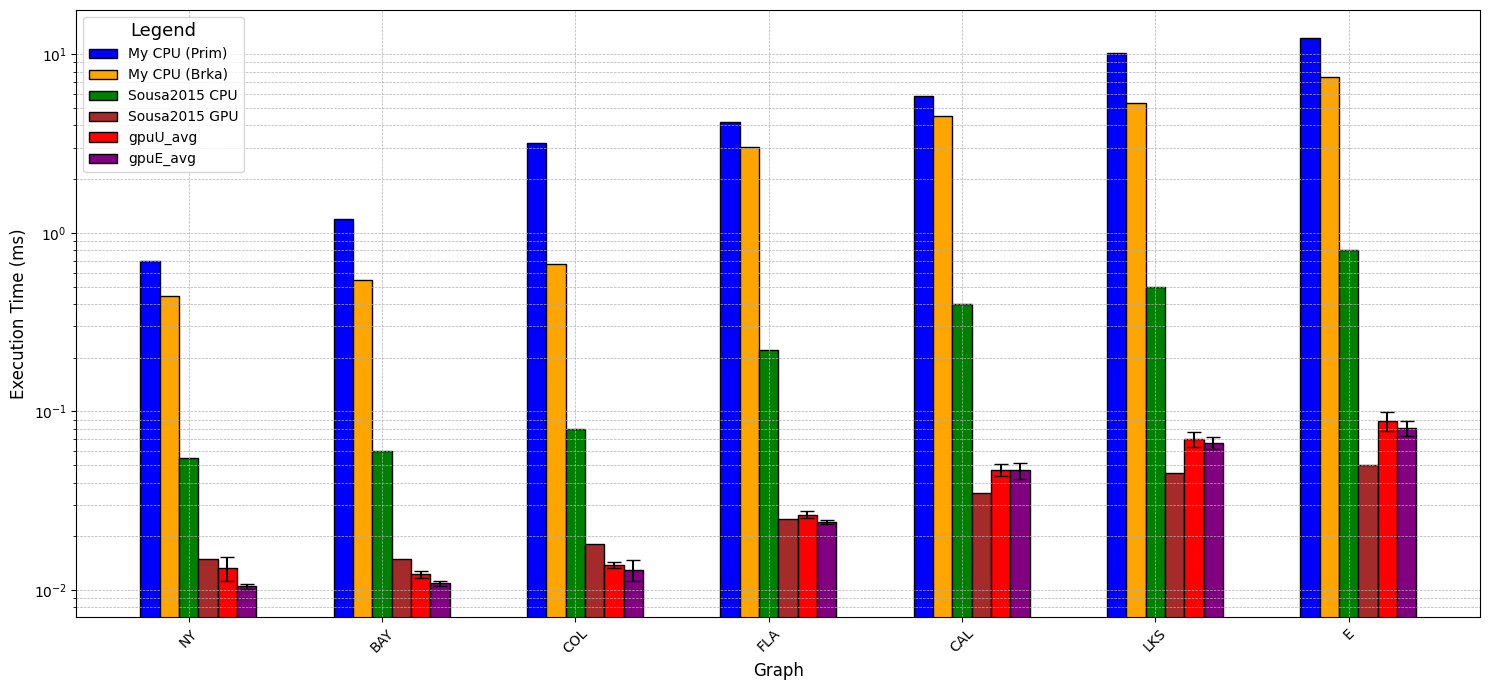

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ["NY", "BAY", "COL", "FLA", "CAL", "LKS", "E"]
num_categories = len(categories)
colors = ["blue", "orange", "green", "brown", "red", "purple"]

# Example execution times (ms) for each configuration
data = {
    "My CPU (Prim)": ets_dict["cpu"],
    "My CPU (Brka)": ets_dict["bka"],
    "Sousa2015 CPU": np.asarray([0.055, 0.06, 0.08, 0.22, 0.4, 0.5, 0.8]),
    "Sousa2015 GPU": np.asarray([0.015, 0.015, 0.018, 0.025, 0.035, 0.045, 0.05]),
    "gpuU_avg": np.empty(0),
    "gpuE_avg": np.empty(0),
    "gpuU_std": np.empty(0),
    "gpuE_std": np.empty(0)
}

base_dir = "/content/result_"
platforms = ["gpuU", "gpuE"]
p = 0

for platform in platforms:
    filepath = base_dir + platform

    with open(filepath, "r") as f:
        lines = f.readlines()
        avg_time = np.zeros(num_categories)
        std_time = np.zeros(num_categories)

        for i in range(num_categories):
            j = 0
            checkWeight = 0
            times = np.zeros(5)
            while j < 10:
                if checkWeight == 0:
                    checkWeight = lines[10 * i + j]
                else:
                    weight = lines[10 * i + j]
                    if checkWeight != weight:
                        print(f"The two weight vectors are different at position {10 * i} {checkWeight}  {weight}")
                        exit(1)
                j += 1
                times[int(j / 2)] = lines[10 * i + j]
                j += 1

            avg_time[i] = np.mean(times)
            std_time[i] = np.std(times)
        f.close()
    if platform == "gpuU":
        data["gpuU_avg"] = avg_time[::-1]
        data["gpuU_std"] = std_time[::-1]
    else:
        data[f"{platform}_avg"] = avg_time
        data[f"{platform}_std"] = std_time

print(data)

# Parameters for bar width and positions
bar_width = 0.1
x = np.arange(num_categories)

# Create figure and set log scale for y-axis
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_yscale("log")

# Plot each data series with a different color and hatch pattern
for i, (label, values) in enumerate(data.items()):
    print(values)
    print(label)
    if label == "gpuU_std":
        ax.errorbar(x + (i - 2) * bar_width, data["gpuU_avg"], values, capsize=5, ecolor='black', linestyle="")
    elif label == "gpuE_std":
        ax.errorbar(x + (i - 2) * bar_width, data["gpuE_avg"], values, capsize=5, ecolor='black', linestyle="")
    else:
        ax.bar(x + i * bar_width, values, width=bar_width, label=label, edgecolor='black', color=colors[i])


# Set labels, title, and legend
ax.set_xlabel("Graph", fontsize=12)
ax.set_ylabel("Execution Time (ms)", fontsize=12)
ax.set_xticks(x + bar_width * 2)  # Center x-ticks
ax.set_xticklabels(categories, rotation=45)
ax.legend(loc="upper left", fontsize=10, title="Legend", title_fontsize='13')

# Show grid and plot
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()